Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data breast
url_test = "https://raw.githubusercontent.com/jamessaldo/final-task/master/breastCancer_test.data"
url_train =  "https://raw.githubusercontent.com/jamessaldo/final-task/master/breastCancer_train.data"
data_train = pd.read_csv(url_test, header=None)
data_test = pd.read_csv(url_train, header=None)
data_breast = data_train.append(data_test, ignore_index = True)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data Breast Cancer:',data_breast.isnull().sum().sum())

Total Missing Value pada Data Breast Cancer: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data breast
data_new_breast = data_breast.drop([24481],axis=1)
scaler = MinMaxScaler()
data_new_breast = scaler.fit_transform(data_new_breast)
data_new_breast = DataFrame(data_new_breast)
data_new_breast['label'] = list(data_breast[24481])
dic = {'non-relapse':0, 'relapse':1}
data_new_breast.replace(dic,inplace=True)

# 2. Define Reusable Function

## Fitness Function

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def fitness(dataset, orde):
  start = timeit.default_timer()
  X = pd.DataFrame(dataset.iloc[:, 0:len(dataset.columns)-1].values)
  Y = pd.DataFrame(dataset.iloc[:, len(dataset.columns)-1].values)

  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # # Melakukan proses klasifikasi LR
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
  # Inisialisasi FLNN
  Model = Sequential()
  # Menambah input layer dan hidden layer pertama
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
  # Menambah output layer
  Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Menjalankan ANN
  Model.compile(optimizer = Adam(learning_rate=0.6), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # Fitting ANN ke training set
  history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

  #Memprediksi hasil test set
  y_pred = Model(X_test)
  y_pred =(y_pred >= 0.5)

  F1 = f1_score(y_test, y_pred, average='macro')

  print("F1 Score : ", F1)

  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return F1

## FLNN Classifier

In [6]:
def FLNN_Classifier(dataset, cancer_name, orde):
  start = timeit.default_timer()
  X = dataset.drop(['label'], axis=1)
  Y = dataset['label']
  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y.reset_index().label
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # Melakukan proses K-Fold
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
  kf.get_n_splits(df_)

  # Melakukan proses klasifikasi FLNN
  Hasil_Akurasi = []
  Hasil_F1 = []
  for train_index, test_index in kf.split(X,Y):
    print("Train :" , train_index, "Test :", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], label[train_index], label[test_index]
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.6), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    hasil = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    #F1 = f1_score(y_test, y_pred, average)

    print("Akurasi : ", hasil)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))
    Hasil_Akurasi.append(hasil)
    Hasil_F1.append(F1)

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

  Akurasi = np.array(Hasil_Akurasi)
  F1_Score = np.array(Hasil_F1)
  avg_akurasi = Akurasi.mean()
  avg_F1 = F1_Score.mean()

  print("avg accuraccy "+cancer_name+" = ",avg_akurasi)
  print("avg F1_Score "+cancer_name+" = ",avg_F1)

  print("max accuraccy "+cancer_name+" = ",Akurasi.max())
  print("max F1_Score "+cancer_name+" = ",F1_Score.max())

  print("min accuraccy "+cancer_name+" = ",Akurasi.min())
  print("min F1_Score "+cancer_name+" = ",F1_Score.min())
  
  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return avg_akurasi, avg_F1

## Genetic Algorithm

In [7]:
# define parameters
mutationRate = 0.1
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, dataset, orde): #using Entropy as fitness
  datasetGA = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(dataset.columns)-1):
    if indv[i] == 1:
      datasetGA[idxDatasetGA] = dataset[i]
      idxDatasetGA += 1
  datasetGA['label'] = dataset['label']
  Acc_score, F1_score = FLNN_Classifier(datasetGA, "Breast Cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [8]:
def GeneticAlgorithm(dataset,orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(dataset.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(dataset.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 90):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    # ent = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], dataset, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(dataset.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(dataset.columns[i])
  dataset_GA = dataset.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return dataset_GA

# 3. Feature Selection with IG

## Breast

In [9]:
data_X = data_new_breast.drop(['label'],axis=1)
data_Y = data_new_breast['label']

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=0)

sel_k_best = SelectKBest(mutual_info_classif, k=100)
sel_k_best.fit(data_X, data_Y)
data_X_new = sel_k_best.transform(data_X)

Breast_IG = pd.DataFrame(data_X_new)
Breast_IG['label'] = data_Y
useddata_breast = Breast_IG
print(useddata_breast.shape)
Breast_IG

(97, 101)


0         1         2         3         4         5         6  \
0   0.138947  0.006717  0.531469  0.320896  0.008422  0.003883  0.602176   
1   0.168947  0.007284  0.955711  0.314925  0.004524  0.004291  0.879565   
2   0.062105  0.005363  0.742424  0.094030  0.008155  0.002270  0.712510   
3   0.046316  0.007254  0.360140  0.246269  0.007926  0.001971  0.672883   
4   0.137895  0.005831  1.000000  0.144776  0.007996  0.006093  0.729604   
..       ...       ...       ...       ...       ...       ...       ...   
92  0.218947  0.004199  0.865967  0.419403  0.007073  0.005486  0.796426   
93  0.120526  0.005264  0.336830  1.000000  0.005436  0.024303  0.842269   
94  0.174211  0.006458  0.368298  0.311940  0.007291  0.006282  0.770785   
95  0.119474  0.005254  0.607226  0.638806  0.008859  0.005107  0.665890   
96  0.193684  0.009354  0.745921  0.229851  0.009920  0.005924  0.798757   

           7         8         9  ...        91        92        93        94  \
0   0.442957  0.397614  0.205460  ...  0.822736  0.679924  0.292683  0.005540   
1   0.442320  0.314115  0.119253  ...  0.000000  0.490530  0.674058  0.007072   
2   0.398343  0.296223  0.718391  ...  0.536609  0.492424  0.138581  0.005053   
3   0.414914  0.431412  0.524425  ...  1.000000  0.316288  0.184035  0.006157   
4   0.640535  0.576541  0.103448  ...  0.348748  0.085227  0.840355  0.005113   
..       ...       ...       ...  ...       ...       ...       ...       ...   
92  0.652008  0.449304  0.646552  ...  0.561657  0.299242  0.460089  0.004963   
93  0.471638  0.520875  0.649425  ...  0.394990  0.068182  0.227273  0.006694   
94  0.355641  0.691849  0.714080  ...  0.368979  0.272727  0.284922  0.003372   
95  0.653920  0.310139  0.331897  ...  0.545279  0.462121  0.337029  0.006794   
96  0.773741  0.642147  0.359195  ...  0.234104  0.465909  0.248337  0.006416   

          95        96        97        98        99  label  
0   0.533149  0.458824  0.003322  0.443590  0.006083      1  
1   0.469613  0.456471  0.003292  0.484615  0.005834      1  
2   0.350829  0.190588  0.001726  0.524359  0.005396      1  
3   0.461326  0.451765  0.002823  0.805128  0.004072      1  
4   0.279006  0.160000  0.002384  0.276923  0.005466      1  
..       ...       ...       ...       ...       ...    ...  
92  0.267956  0.331765  0.002205  0.410256  0.006551      0  
93  0.444751  0.242353  0.002534  0.366667  0.005217      0  
94  0.596685  0.529412  0.002664  0.697436  0.005327      0  
95  0.486188  0.254118  0.002813  0.561538  0.005775      0  
96  0.439227  0.338824  0.002394  0.612821  0.003405      0  

[97 rows x 101 columns]

# 4. Classification

## Breast + IG

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


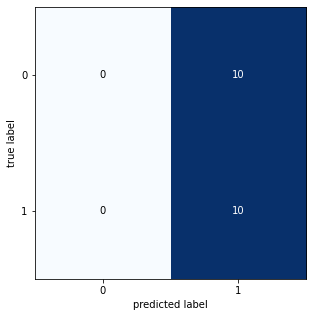

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



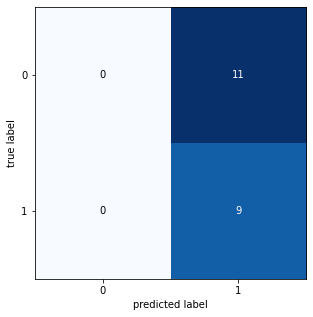

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



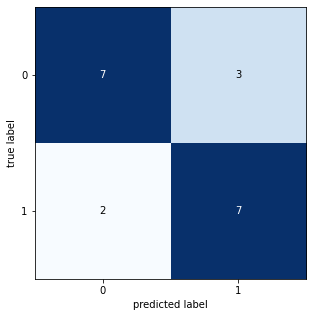

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



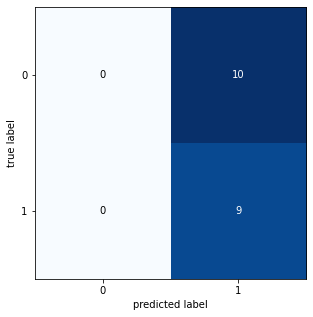

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



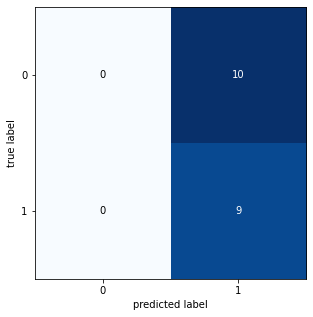

avg accuraccy Breast cancer =  0.5268421052631579
avg F1_Score Breast cancer =  0.40467548180796814
max accuraccy Breast cancer =  0.7368421052631579
max F1_Score Breast cancer =  0.7368421052631577
min accuraccy Breast cancer =  0.45
min F1_Score Breast cancer =  0.3103448275862069
Running Time:  32.4867317369999


(0.5268421052631579, 0.40467548180796814)

In [10]:
FLNN_Classifier(Breast_IG,"Breast cancer",2)

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


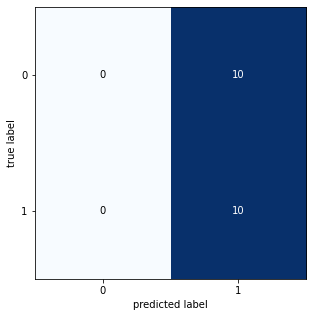

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



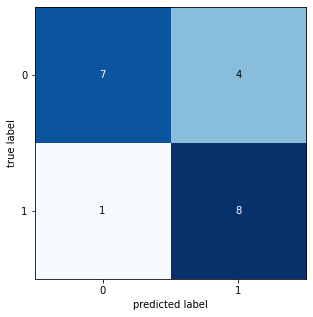

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



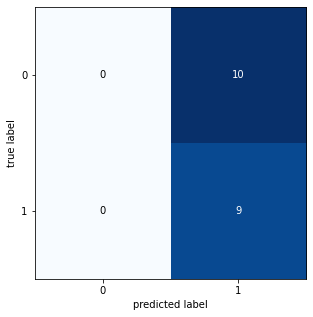

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692307
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.56      1.00      0.72         9

    accuracy                           0.63        19
   macro avg       0.78      0.65      0.59        19
weighted avg       0.79      0.63      0.58        19



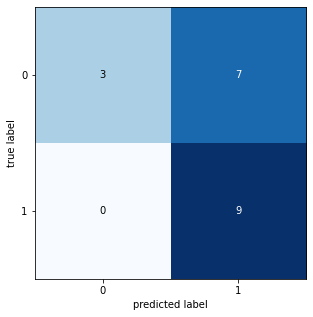

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



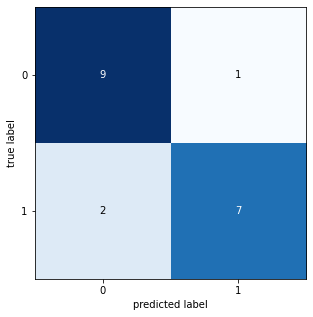

avg accuraccy Breast cancer =  0.6394736842105263
avg F1_Score Breast cancer =  0.5670481407137753
max accuraccy Breast cancer =  0.8421052631578947
max F1_Score Breast cancer =  0.8403361344537816
min accuraccy Breast cancer =  0.47368421052631576
min F1_Score Breast cancer =  0.32142857142857145
Running Time:  32.59424367599968


(0.6394736842105263, 0.5670481407137753)

In [11]:
FLNN_Classifier(Breast_IG,"Breast cancer",3)

Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



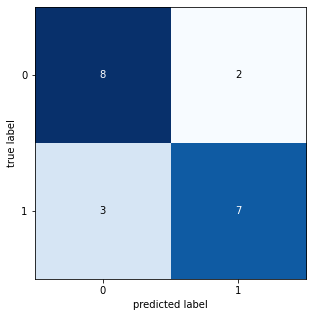

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



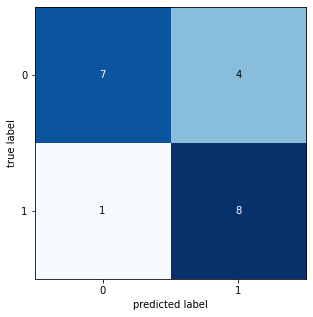

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



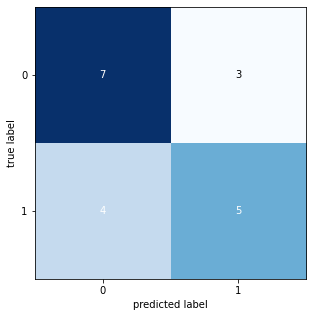

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



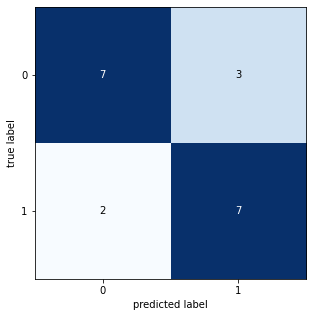

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7738095238095237
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.56      0.71         9

    accuracy                           0.79        19
   macro avg       0.86      0.78      0.77        19
weighted avg       0.85      0.79      0.78        19



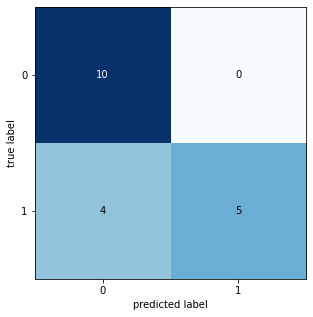

avg accuraccy Breast cancer =  0.7315789473684211
avg F1_Score Breast cancer =  0.7273698953265516
max accuraccy Breast cancer =  0.7894736842105263
max F1_Score Breast cancer =  0.7738095238095237
min accuraccy Breast cancer =  0.631578947368421
min F1_Score Breast cancer =  0.6274509803921569
Running Time:  32.74041308000051


(0.7315789473684211, 0.7273698953265516)

In [12]:
FLNN_Classifier(Breast_IG,"Breast cancer",4)

## Breast + IG + GA

Generation : 0
gene : [0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
     

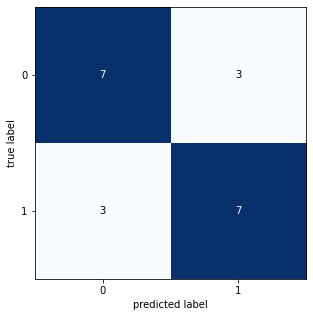

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


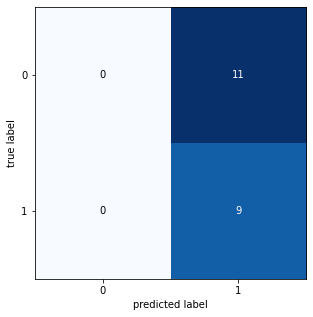

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



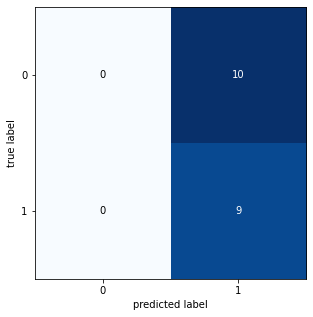

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



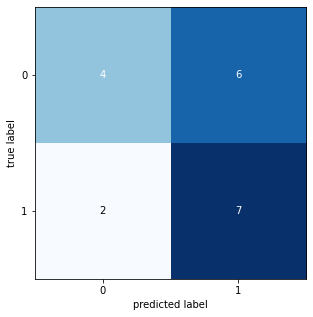

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



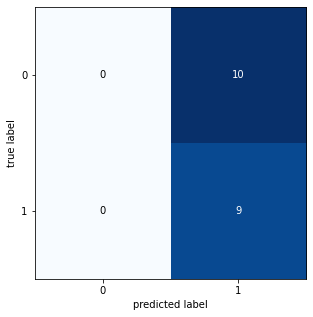

avg accuraccy Breast Cancer =  0.5352631578947369
avg F1_Score Breast Cancer =  0.44427675772503356
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.7
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  44.83300610599963
gene : [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 

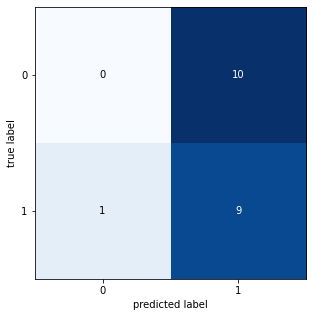

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


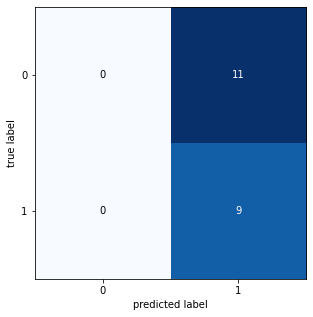

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



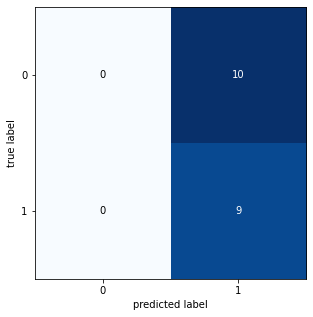

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



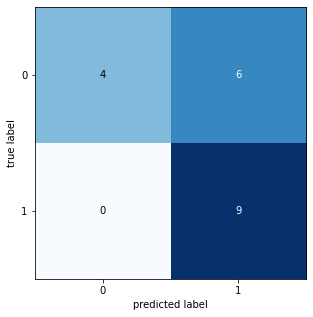

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692308
              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.75      0.33      0.46         9

    accuracy                           0.63        19
   macro avg       0.68      0.62      0.59        19
weighted avg       0.67      0.63      0.60        19



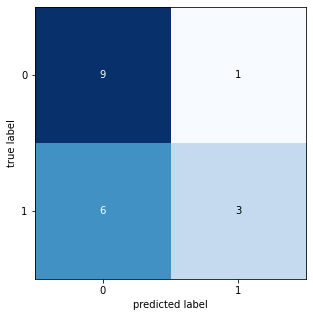

avg accuraccy Breast Cancer =  0.5378947368421052
avg F1_Score Breast Cancer =  0.43872034861690035
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6607142857142857
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  44.38867749200017
gene : [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


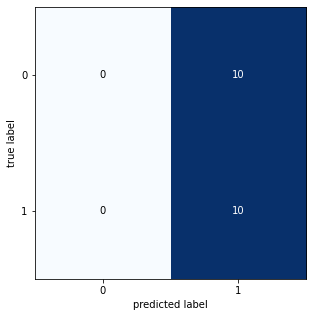

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



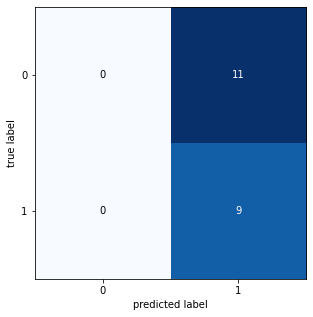

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



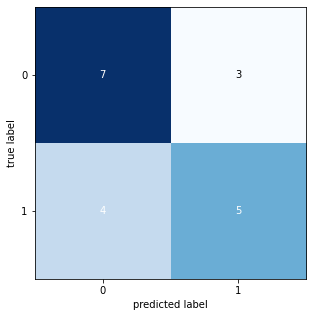

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



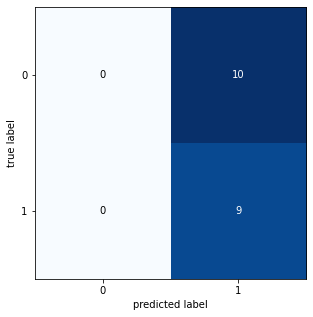

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



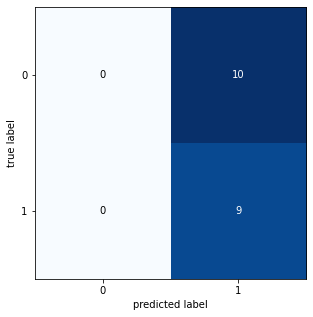

avg accuraccy Breast Cancer =  0.5057894736842106
avg F1_Score Breast Cancer =  0.382797256833768
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6274509803921569
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  44.44143968099979
gene : [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

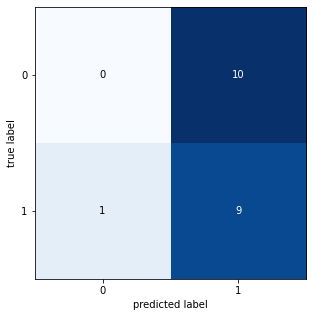

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


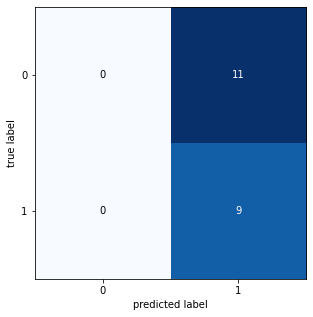

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



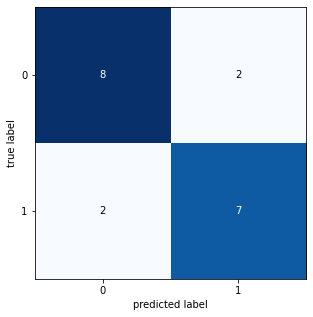

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



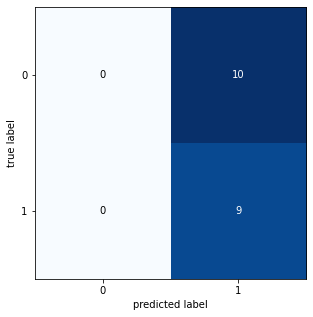

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



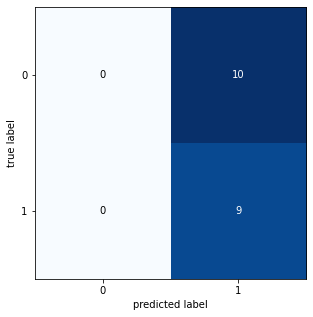

avg accuraccy Breast Cancer =  0.5273684210526317
avg F1_Score Breast Cancer =  0.41048713738368914
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  44.40816166900004
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

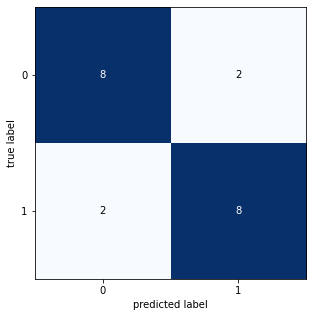

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



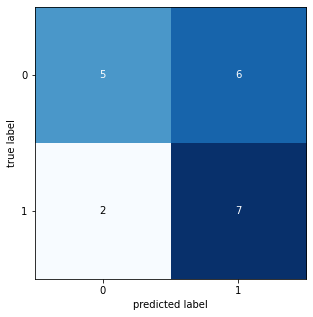

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



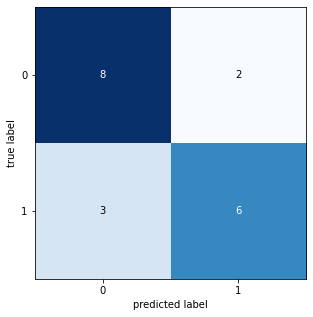

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



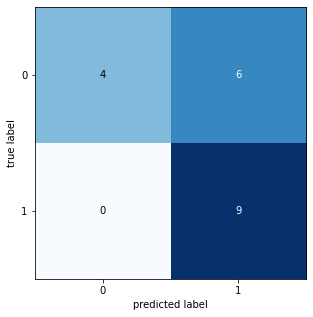

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



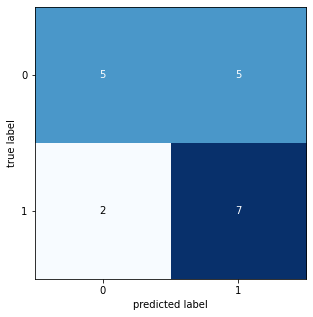

avg accuraccy Breast Cancer =  0.6905263157894737
avg F1_Score Breast Cancer =  0.6836036838978016
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.8000000000000002
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.595959595959596
Running Time:  44.15610197299975
gene : [0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


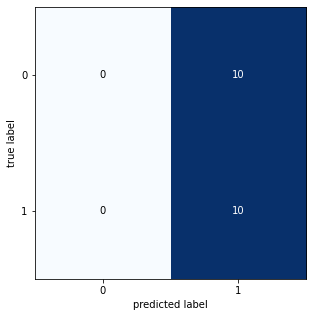

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



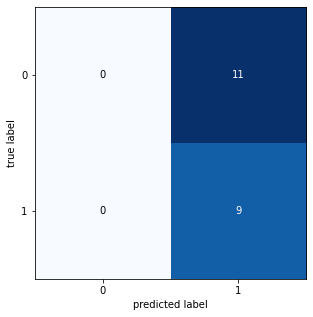

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



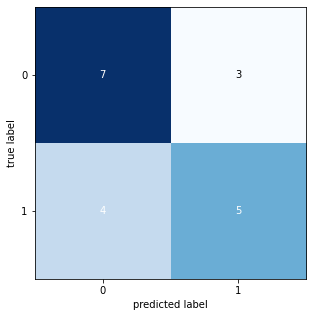

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



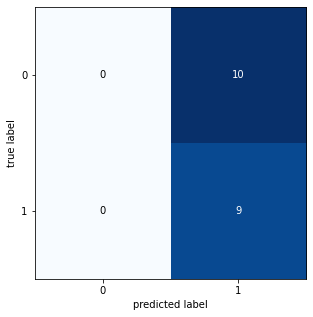

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



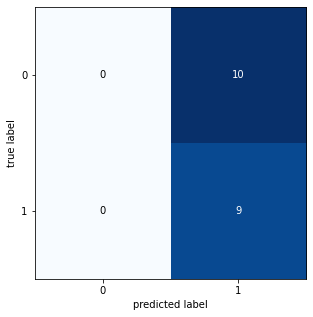

avg accuraccy Breast Cancer =  0.5057894736842106
avg F1_Score Breast Cancer =  0.382797256833768
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6274509803921569
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  44.62516674499966
gene : [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


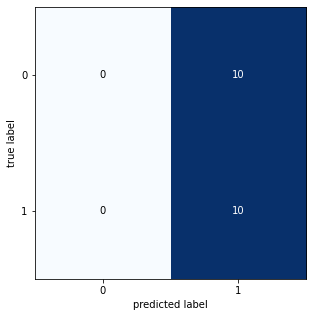

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



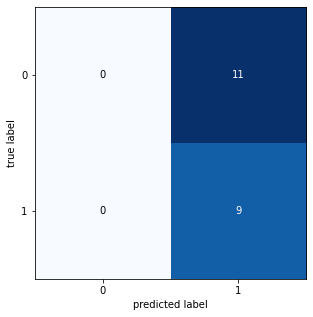

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



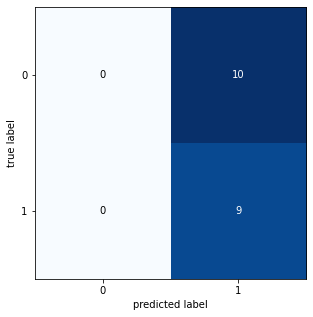

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



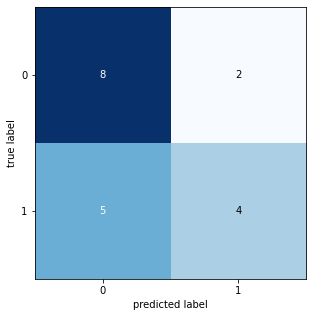

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



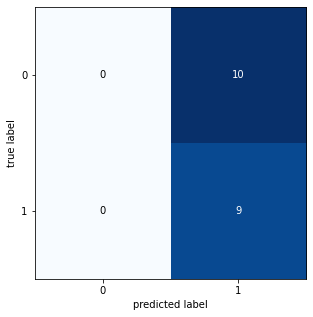

avg accuraccy Breast Cancer =  0.5057894736842105
avg F1_Score Breast Cancer =  0.3802056114799743
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6144927536231883
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  43.85933955600012
gene : [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

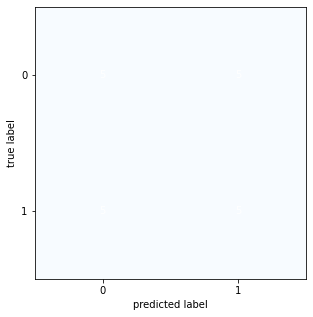

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



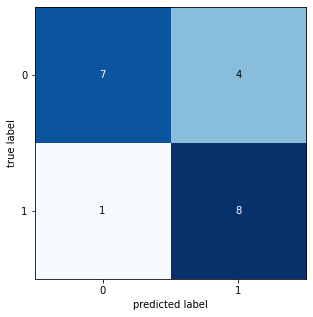

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


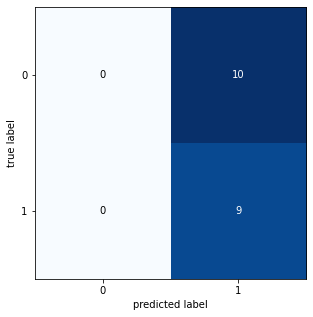

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6346153846153846
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       1.00      0.33      0.50         9

    accuracy                           0.68        19
   macro avg       0.81      0.67      0.63        19
weighted avg       0.80      0.68      0.64        19



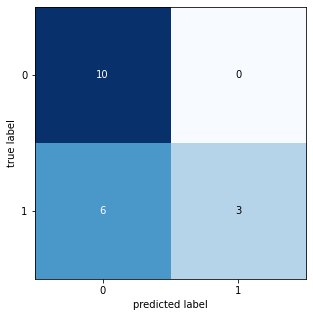

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



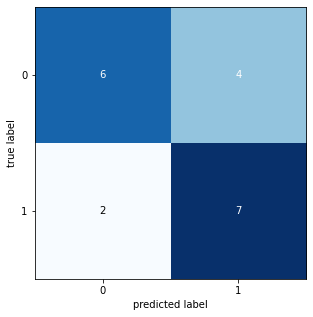

avg accuraccy Breast Cancer =  0.618421052631579
avg F1_Score Breast Cancer =  0.5777501445922498
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  43.87538154499998
gene : [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

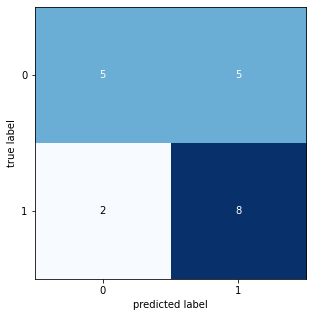

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


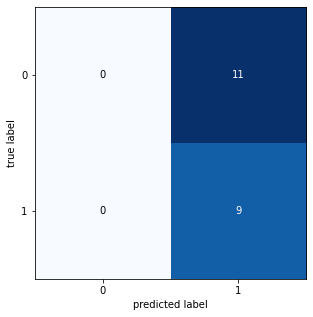

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



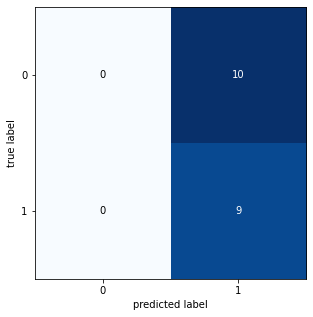

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



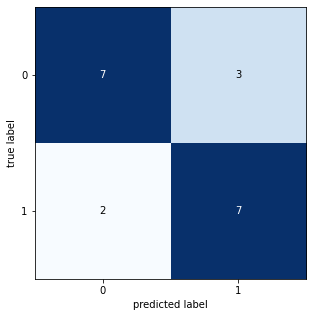

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



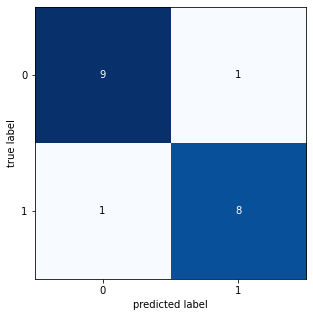

avg accuraccy Breast Cancer =  0.6410526315789473
avg F1_Score Breast Cancer =  0.5810007365475451
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  43.6219460329994
gene : [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


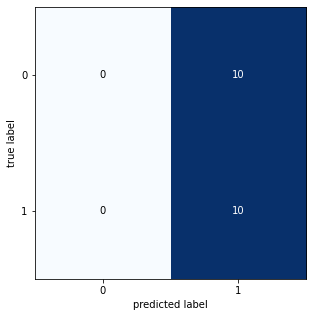

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



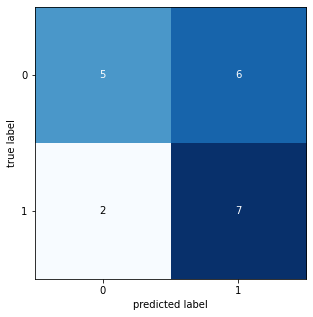

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



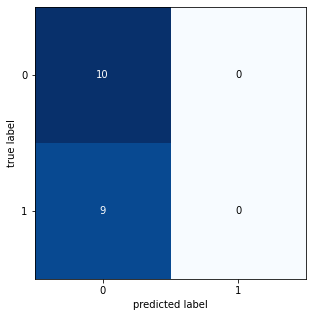

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



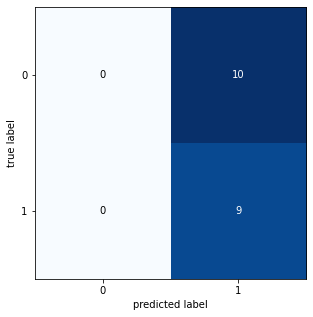

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



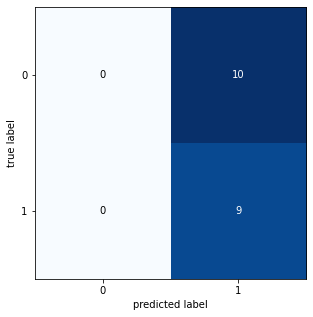

avg accuraccy Breast Cancer =  0.5147368421052632
avg F1_Score Breast Cancer =  0.38339553167139373
max accuraccy Breast Cancer =  0.6
max F1_Score Breast Cancer =  0.595959595959596
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  43.41120703100023
gen terbaik : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.6836036838978016  || Akurasi terbaik : 0.6905263157894737  || jumlah fitur : 48

Generation : 1
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,

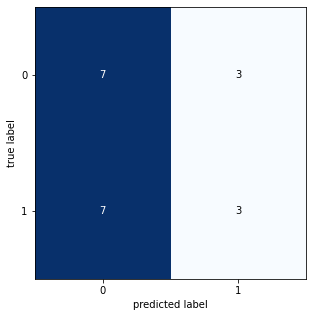

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


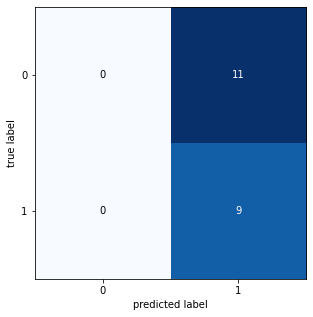

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



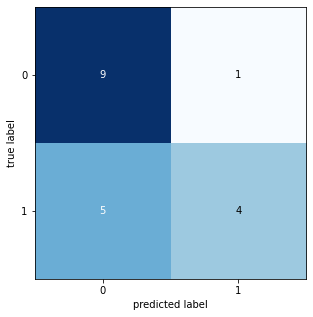

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



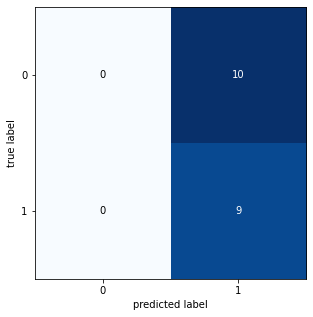

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



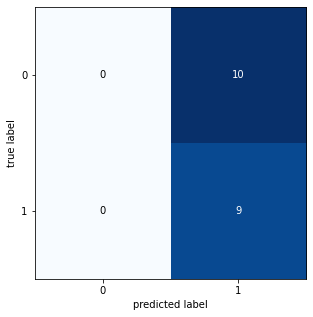

avg accuraccy Breast Cancer =  0.5163157894736843
avg F1_Score Breast Cancer =  0.41861658456486045
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6607142857142857
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.820318213000064
gene : [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


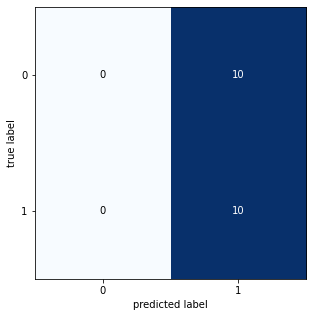

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



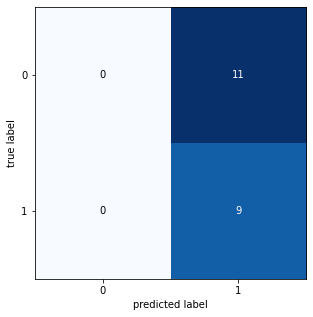

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



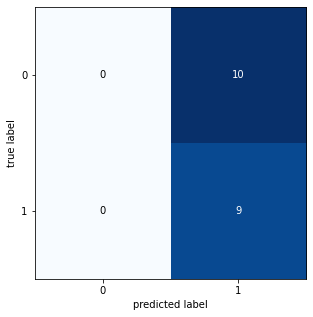

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



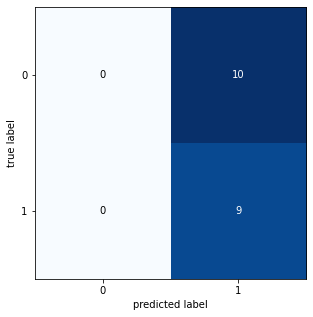

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



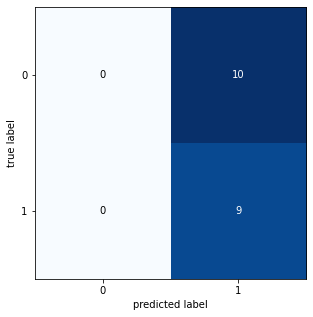

avg accuraccy Breast Cancer =  0.4742105263157894
avg F1_Score Breast Cancer =  0.3215927750410509
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.95841838800061
gene : [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

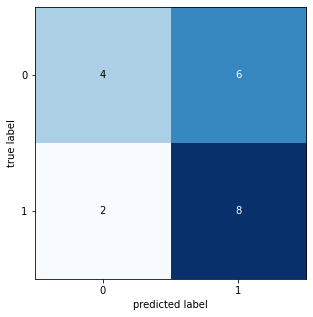

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



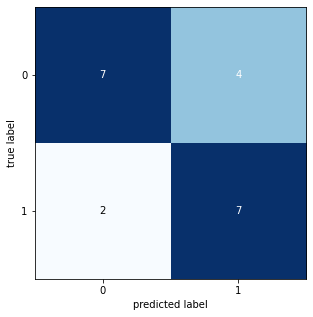

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


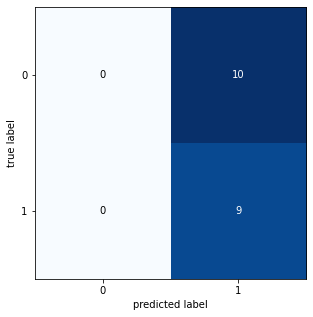

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



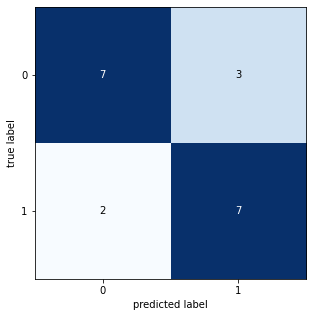

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



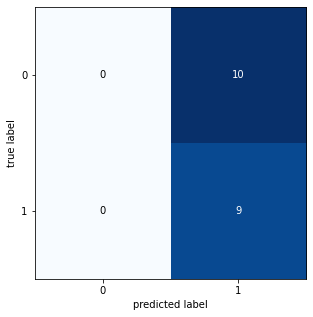

avg accuraccy Breast Cancer =  0.5968421052631578
avg F1_Score Breast Cancer =  0.5326065162907268
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.16870872199979
gene : [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

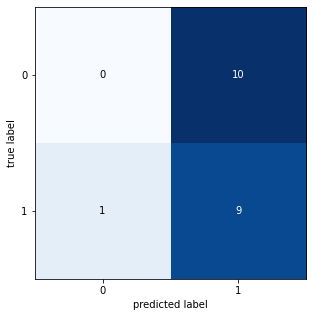

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.3548387096774194
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


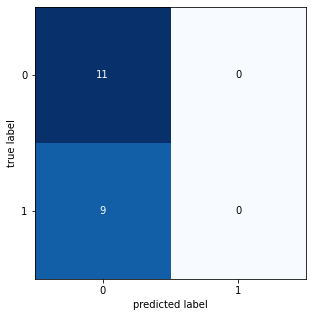

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



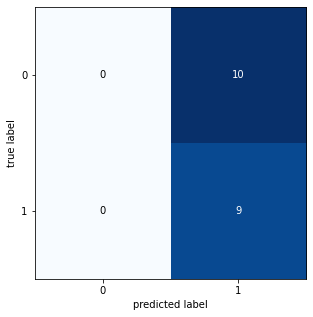

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



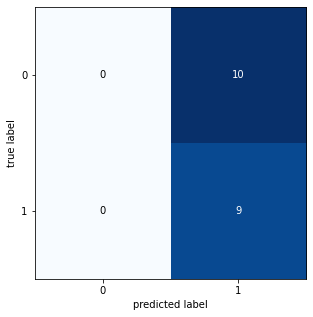

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8347826086956522
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.67      0.80         9

    accuracy                           0.84        19
   macro avg       0.88      0.83      0.83        19
weighted avg       0.88      0.84      0.84        19



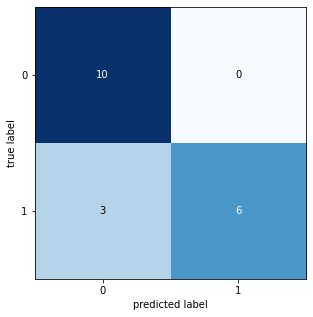

avg accuraccy Breast Cancer =  0.5578947368421052
avg F1_Score Breast Cancer =  0.4285646577632843
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8347826086956522
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.502208494000115
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

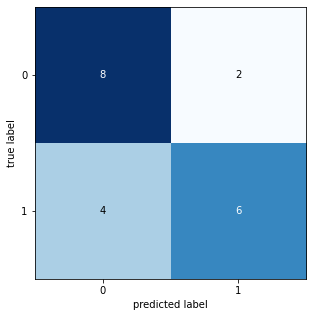

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


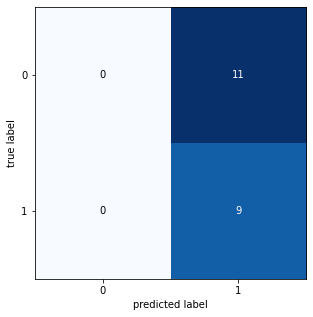

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



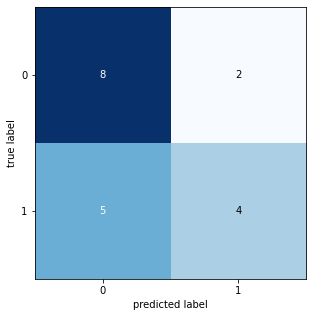

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



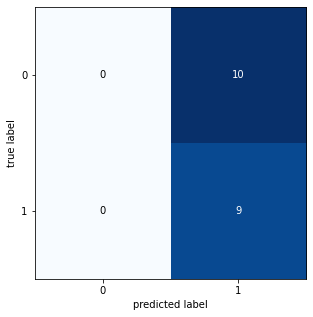

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



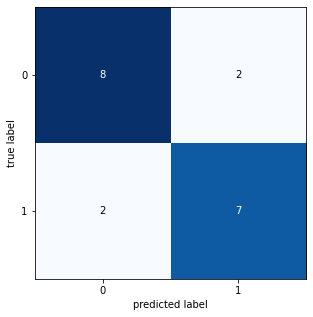

avg accuraccy Breast Cancer =  0.6089473684210527
avg F1_Score Breast Cancer =  0.5464249476993105
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.460941078999895
gene : [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


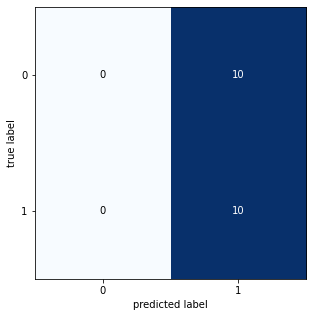

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



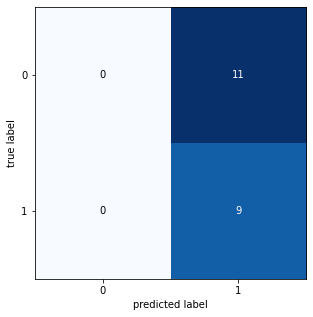

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



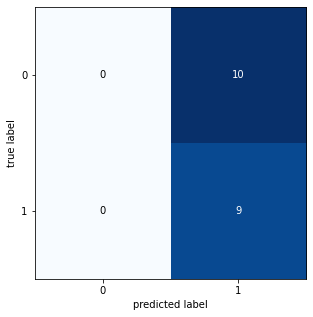

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



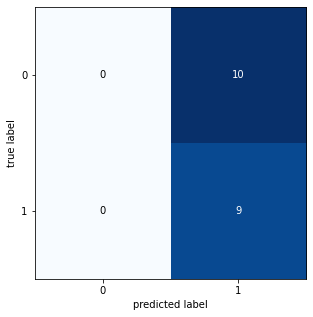

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



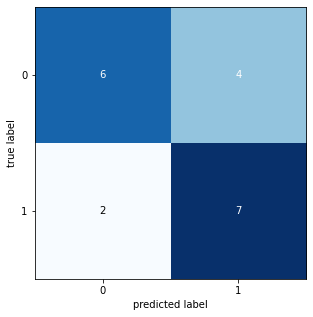

avg accuraccy Breast Cancer =  0.5163157894736842
avg F1_Score Breast Cancer =  0.3939737274220033
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.37460593600008
gene : [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


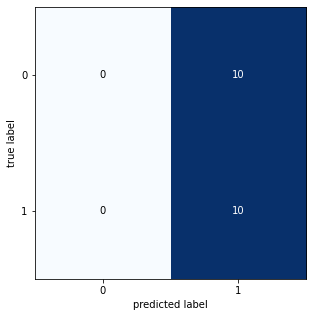

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6703296703296703
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.80      0.44      0.57         9

    accuracy                           0.70        20
   macro avg       0.73      0.68      0.67        20
weighted avg       0.73      0.70      0.68        20



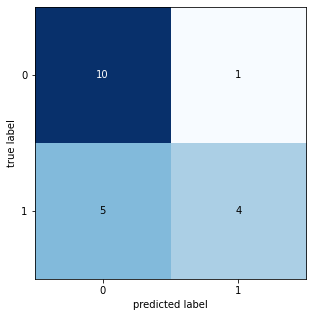

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



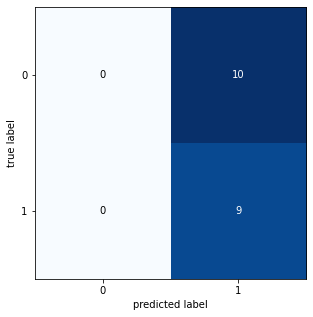

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



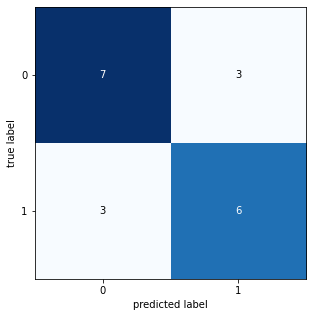

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



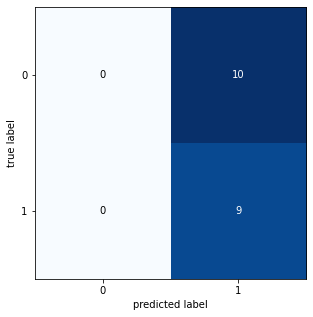

avg accuraccy Breast Cancer =  0.5663157894736842
avg F1_Score Breast Cancer =  0.465970695970696
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.79133820000061
gene : [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

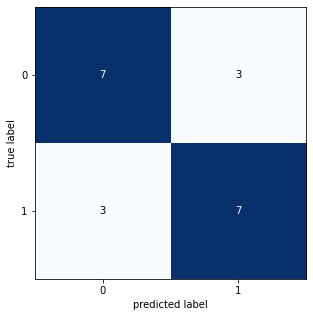

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



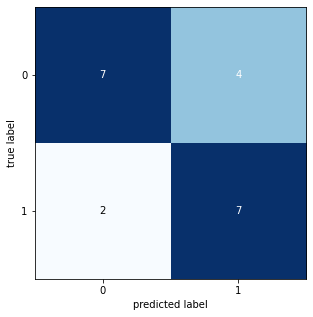

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


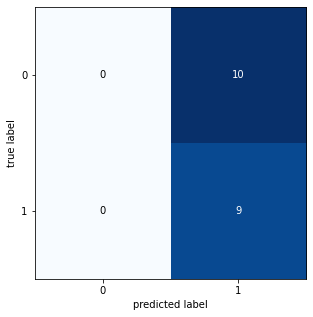

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



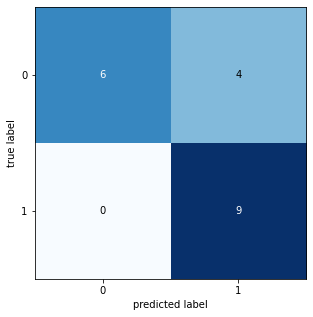

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



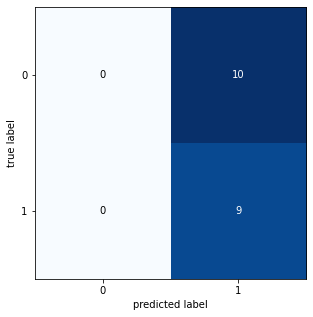

avg accuraccy Breast Cancer =  0.6273684210526316
avg F1_Score Breast Cancer =  0.5653896103896103
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  43.989330682999935
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


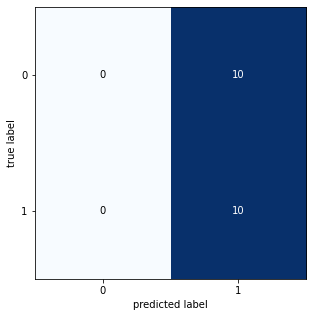

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



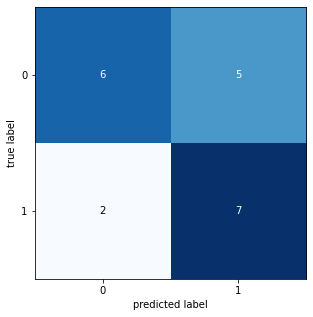

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



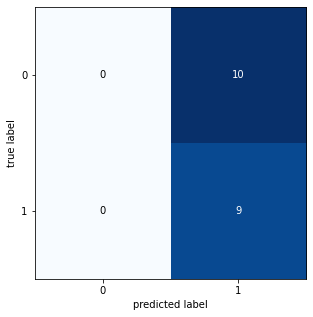

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



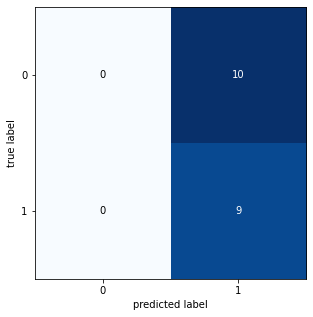

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



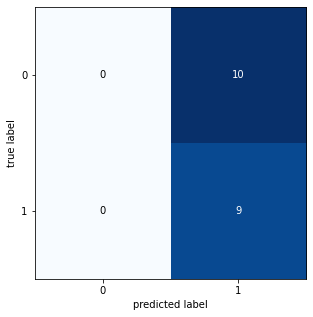

avg accuraccy Breast Cancer =  0.5142105263157895
avg F1_Score Breast Cancer =  0.3893483709273183
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6491228070175439
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.84784373799994
gene : [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


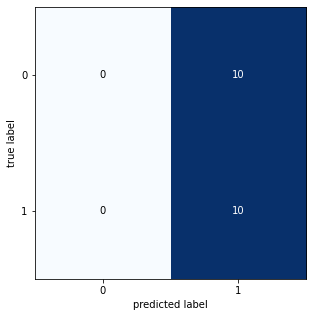

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



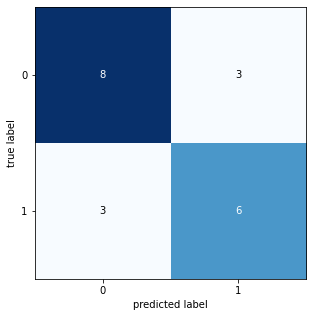

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



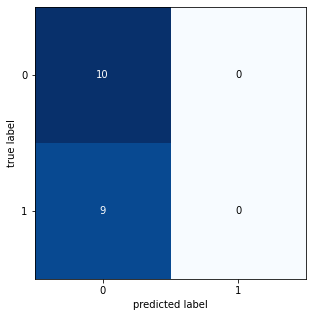

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



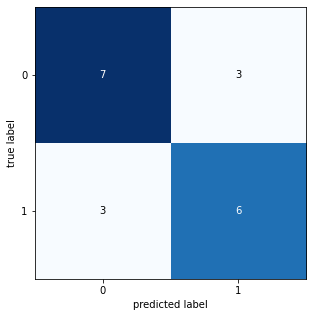

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



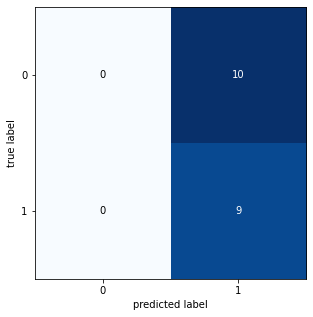

avg accuraccy Breast Cancer =  0.5768421052631579
avg F1_Score Breast Cancer =  0.4759785042543664
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.696969696969697
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.243317994999416
gen terbaik : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.6836036838978016  || Akurasi terbaik : 0.6905263157894737  || jumlah fitur : 48

Generation : 2
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


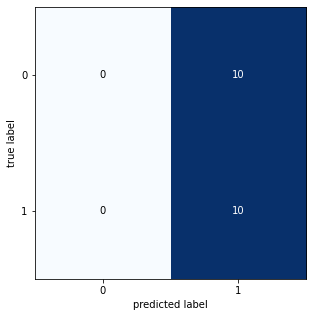

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



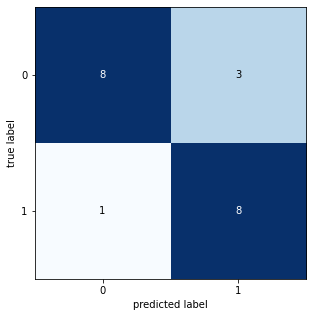

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



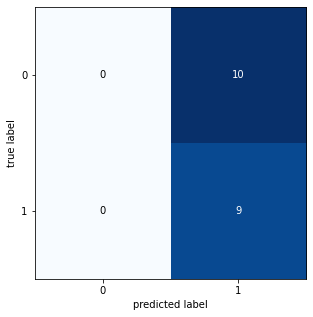

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



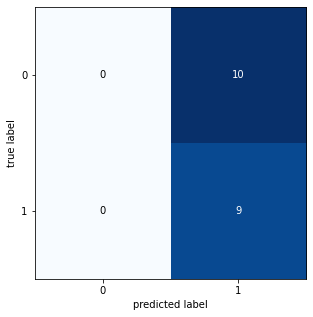

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



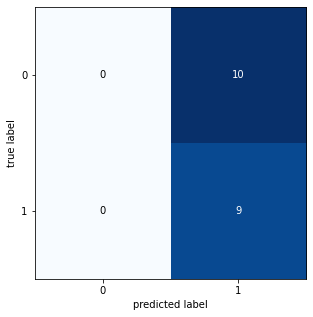

avg accuraccy Breast Cancer =  0.5442105263157895
avg F1_Score Breast Cancer =  0.4195238095238095
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7999999999999999
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.97479712799941
gene : [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


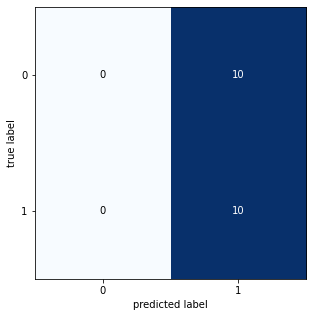

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



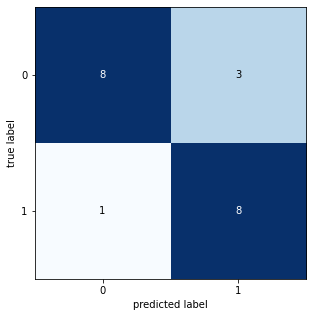

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



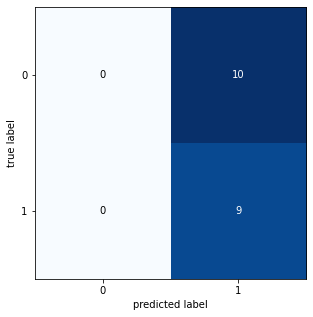

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



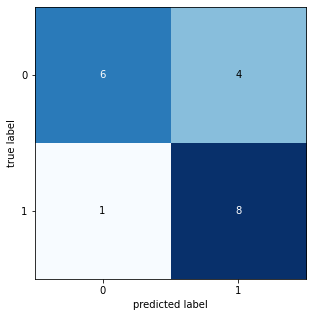

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



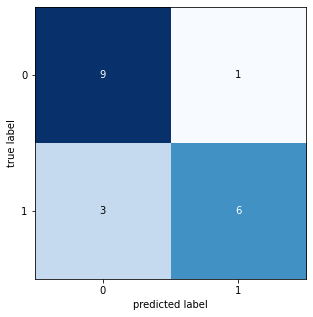

avg accuraccy Breast Cancer =  0.6599999999999999
avg F1_Score Breast Cancer =  0.5945492742551567
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7999999999999999
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.08138730599967
gene : [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

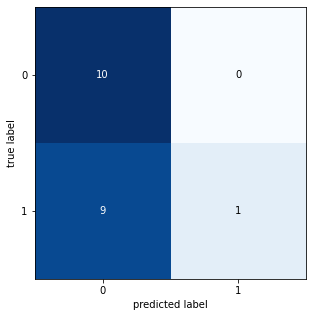

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



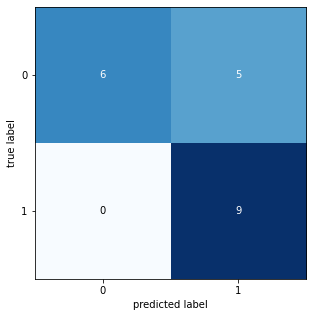

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



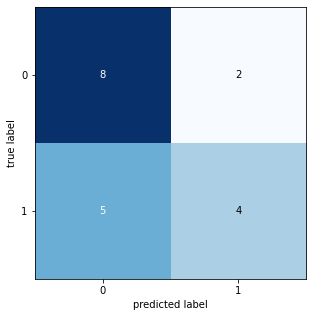

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


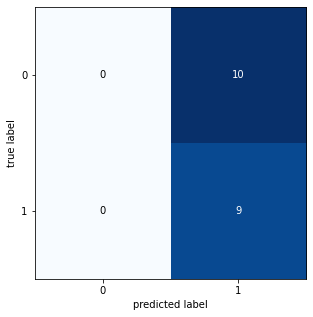

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



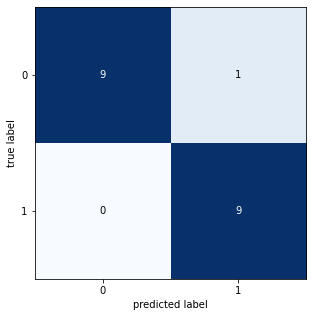

avg accuraccy Breast Cancer =  0.6705263157894736
avg F1_Score Breast Cancer =  0.6126543895034109
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.69005292200018
gene : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


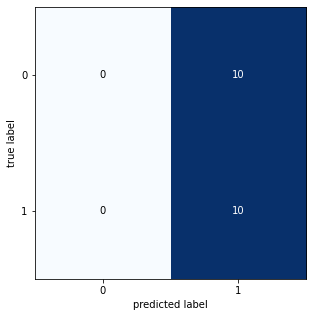

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



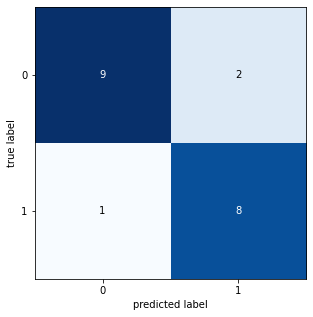

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



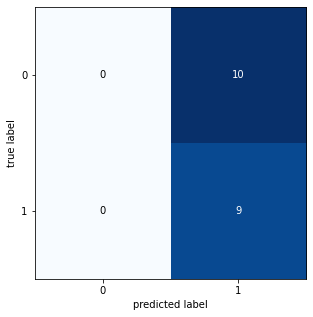

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



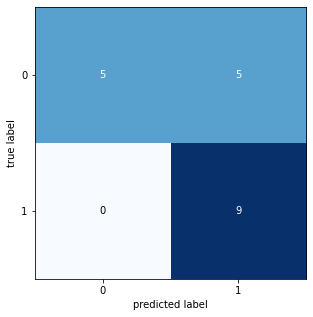

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



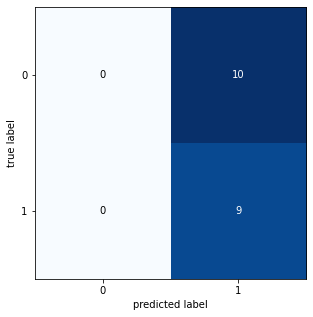

avg accuraccy Breast Cancer =  0.6068421052631578
avg F1_Score Breast Cancer =  0.5100904435000545
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.20852138800001
gene : [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

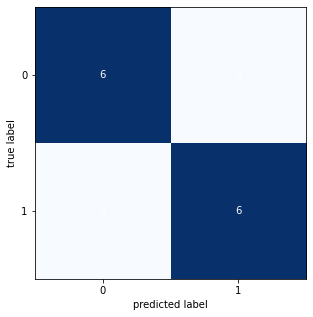

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


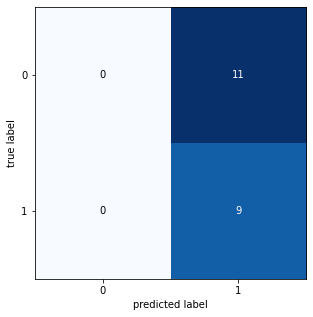

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



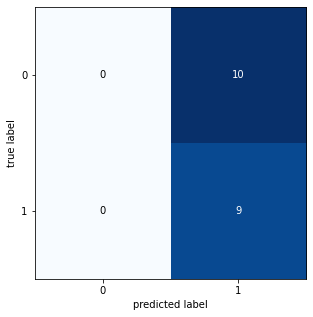

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



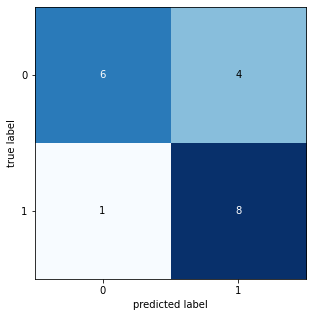

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



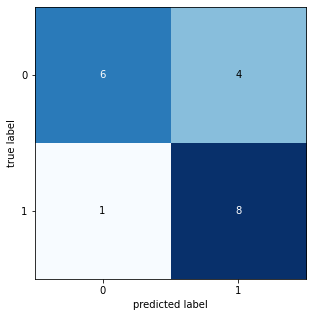

avg accuraccy Breast Cancer =  0.5994736842105264
avg F1_Score Breast Cancer =  0.5399121027721433
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.991765904000204
gene : [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

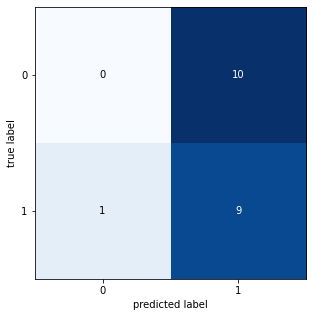

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



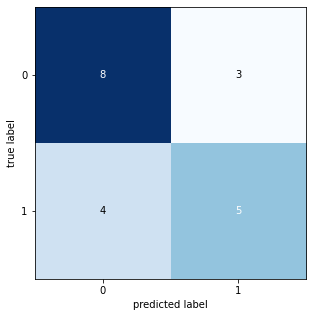

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



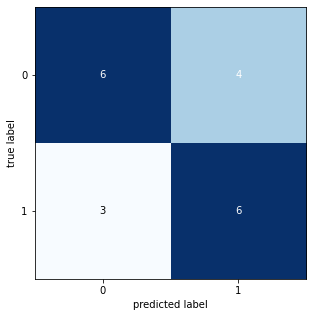

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


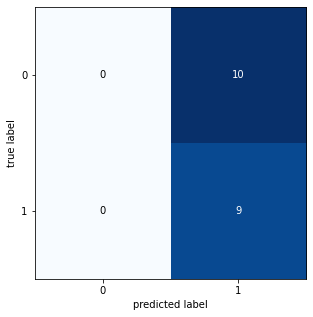

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



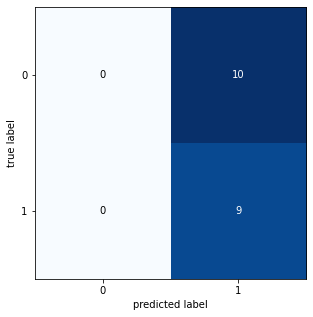

avg accuraccy Breast Cancer =  0.5357894736842106
avg F1_Score Breast Cancer =  0.4453449303654232
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6419437340153453
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.36260447600034
gene : [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

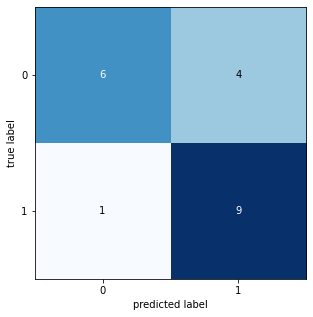

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



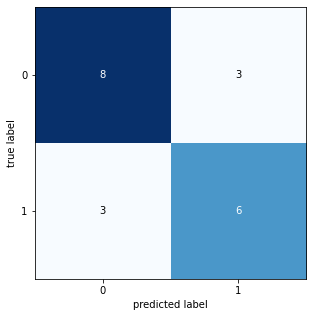

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



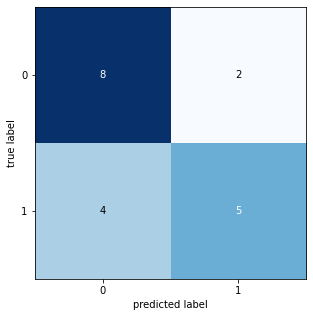

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



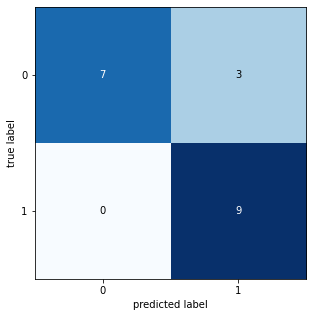

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


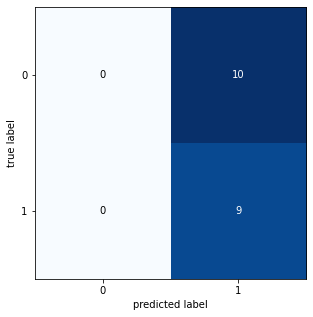

avg accuraccy Breast Cancer =  0.6900000000000001
avg F1_Score Breast Cancer =  0.6558232581570178
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.21020982000027
gene : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

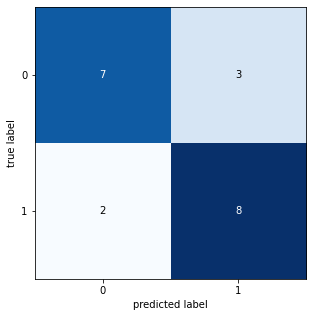

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



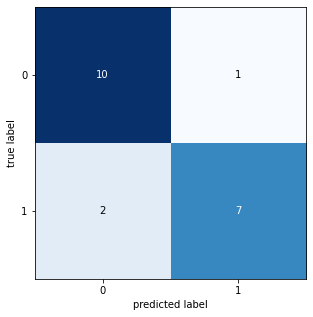

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


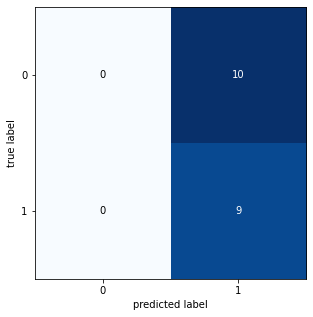

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



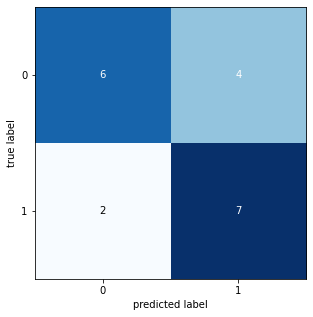

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



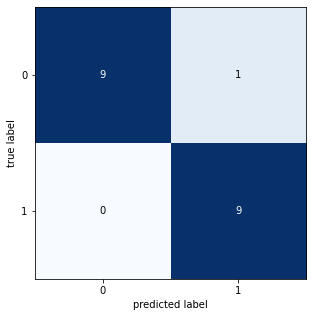

avg accuraccy Breast Cancer =  0.7410526315789474
avg F1_Score Breast Cancer =  0.7096102147953003
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.176980103999995
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1

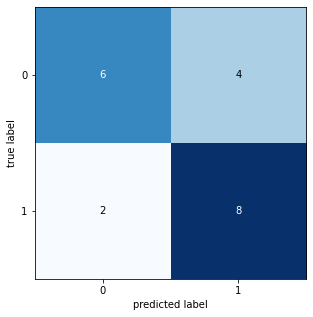

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



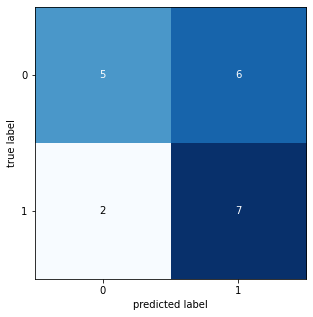

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



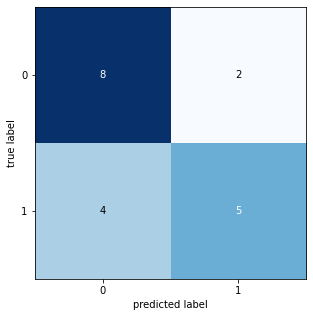

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



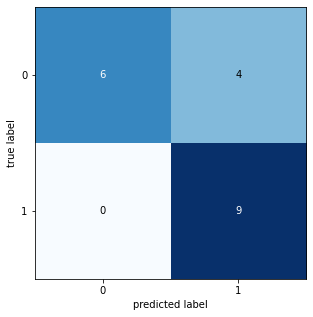

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



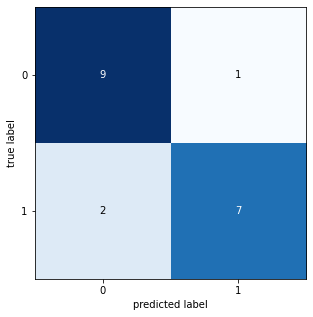

avg accuraccy Breast Cancer =  0.7231578947368421
avg F1_Score Breast Cancer =  0.7186985400220695
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.6
min F1_Score Breast Cancer =  0.595959595959596
Running Time:  40.5723834140008
gene : [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1

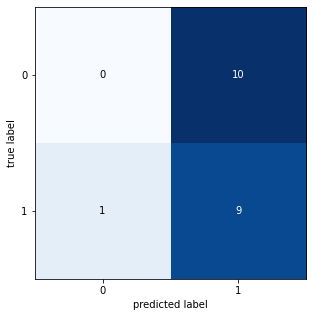

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.3548387096774194
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


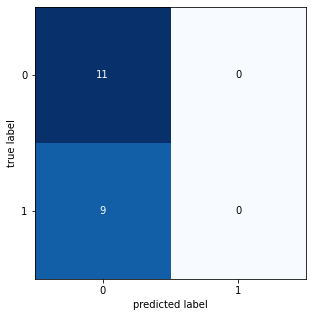

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



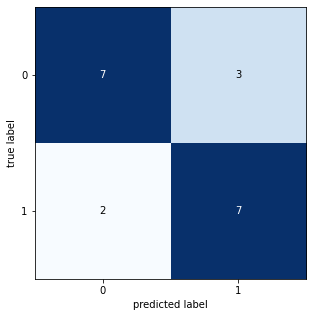

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



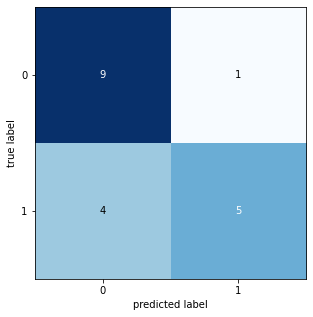

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.57      0.89      0.70         9

    accuracy                           0.63        19
   macro avg       0.69      0.64      0.61        19
weighted avg       0.69      0.63      0.61        19



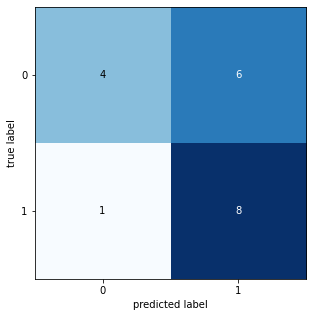

avg accuraccy Breast Cancer =  0.6210526315789474
avg F1_Score Breast Cancer =  0.5482312154618786
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.72260345799987
gen terbaik : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.7186985400220695  || Akurasi terbaik : 0.7231578947368421  || jumlah fitur : 48

Generation : 3
gene : [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 

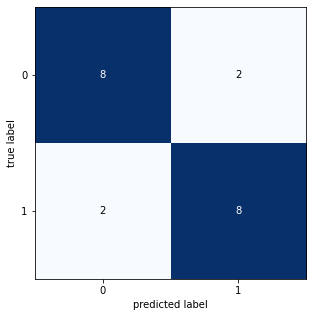

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


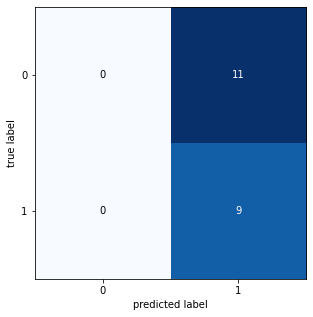

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



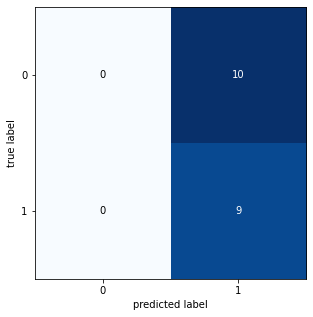

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



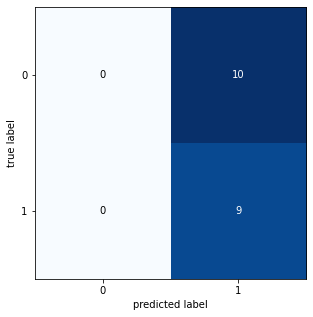

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



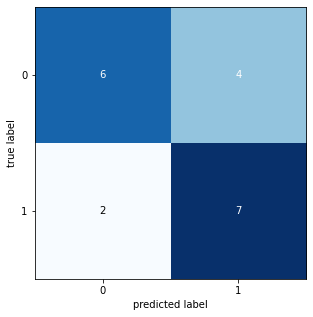

avg accuraccy Breast Cancer =  0.5763157894736841
avg F1_Score Breast Cancer =  0.4873070607553366
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.8000000000000002
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.83868690899999
gene : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

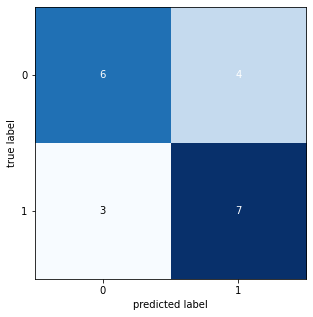

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


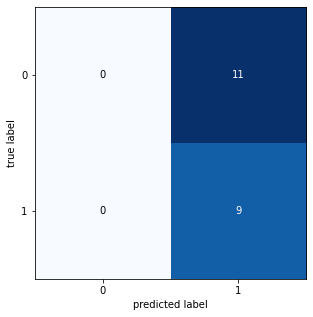

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



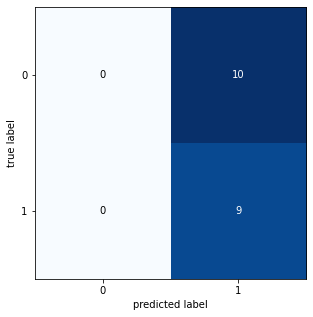

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



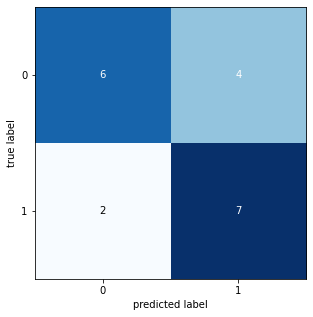

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



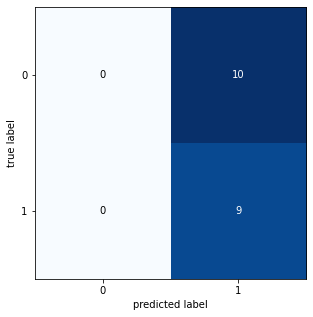

avg accuraccy Breast Cancer =  0.5463157894736843
avg F1_Score Breast Cancer =  0.4571316221588454
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.79698220099999
gene : [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

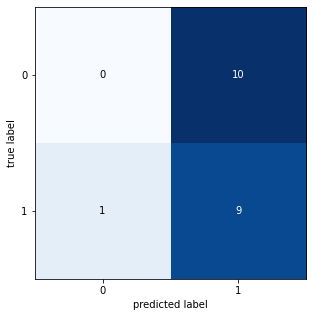

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666666
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.86      0.67      0.75         9

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.79        20
weighted avg       0.81      0.80      0.80        20



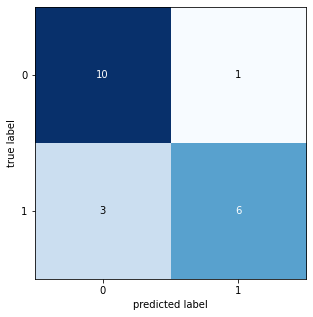

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


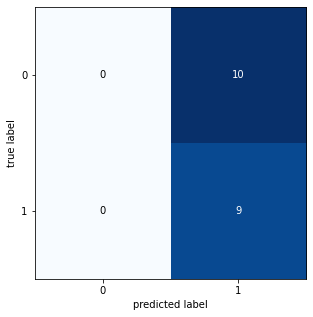

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



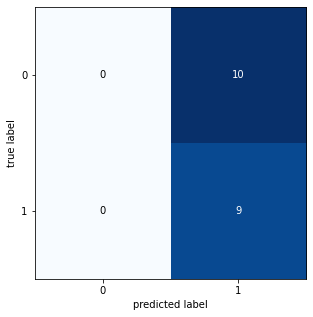

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



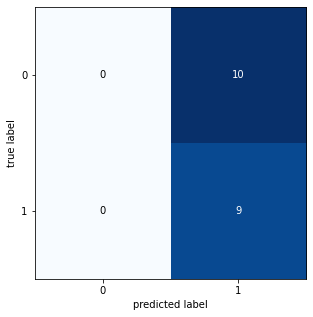

avg accuraccy Breast Cancer =  0.5342105263157895
avg F1_Score Breast Cancer =  0.41325944170771756
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7916666666666666
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.293598381000265
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

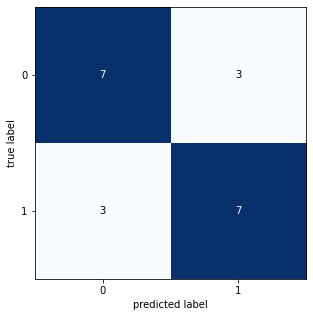

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6011396011396011
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.75      0.33      0.46         9

    accuracy                           0.65        20
   macro avg       0.69      0.62      0.60        20
weighted avg       0.68      0.65      0.62        20



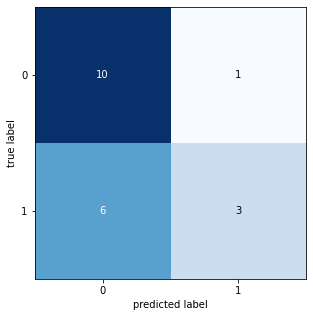

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


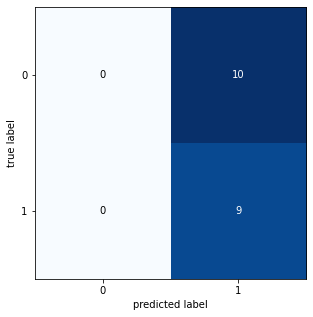

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



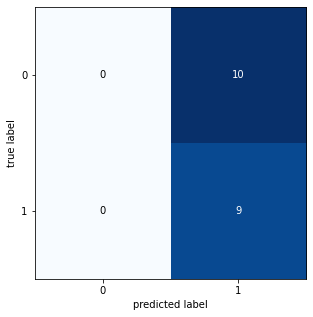

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



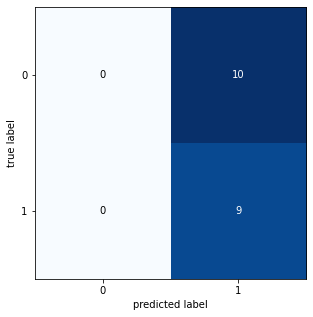

avg accuraccy Breast Cancer =  0.5542105263157895
avg F1_Score Breast Cancer =  0.453085063085063
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.7
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.806022921000476
gene : [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


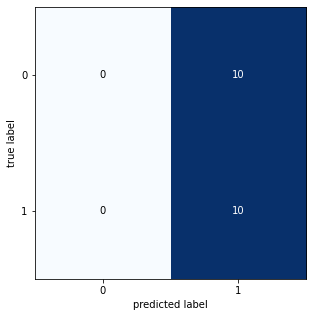

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



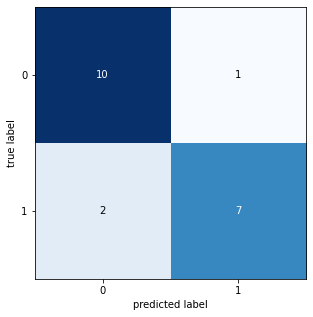

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



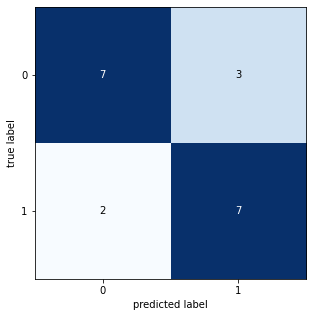

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



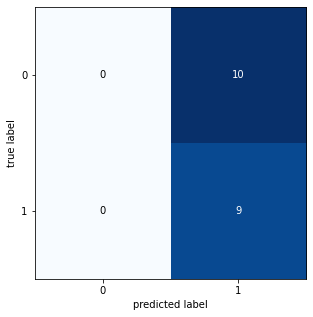

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



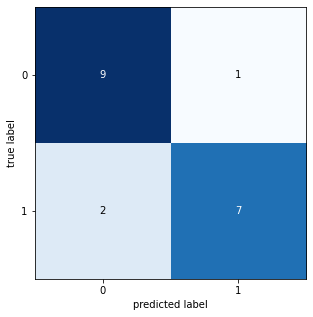

avg accuraccy Breast Cancer =  0.6805263157894738
avg F1_Score Breast Cancer =  0.6156974918113699
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.70488811999985
gene : [1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

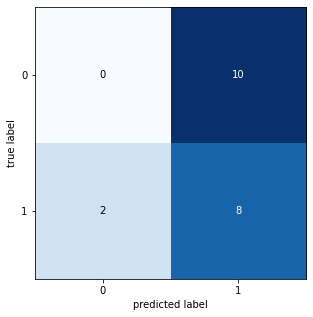

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5604395604395604
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.60      0.33      0.43         9

    accuracy                           0.60        20
   macro avg       0.60      0.58      0.56        20
weighted avg       0.60      0.60      0.57        20



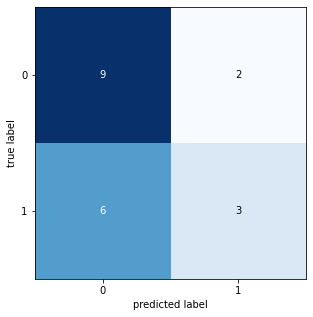

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


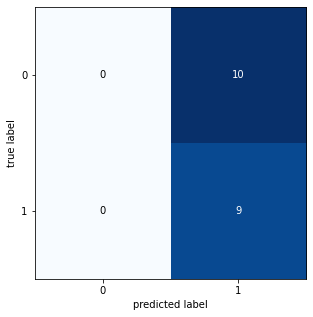

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



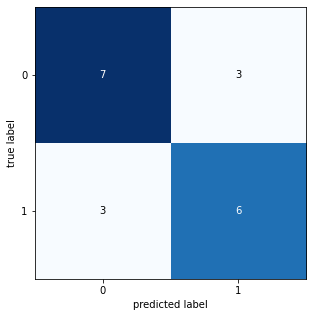

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



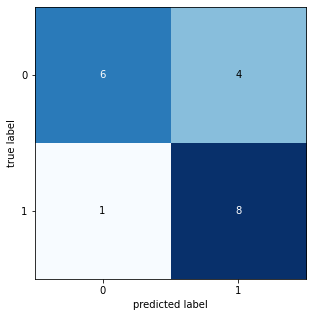

avg accuraccy Breast Cancer =  0.5789473684210527
avg F1_Score Breast Cancer =  0.516961861667744
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.4
min F1_Score Breast Cancer =  0.2857142857142857
Running Time:  41.15972194799997
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


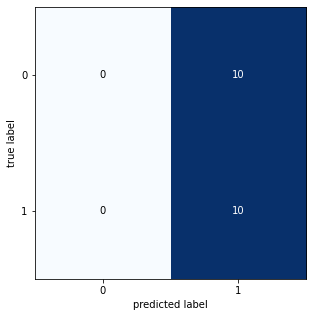

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



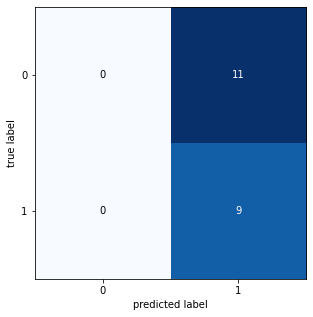

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



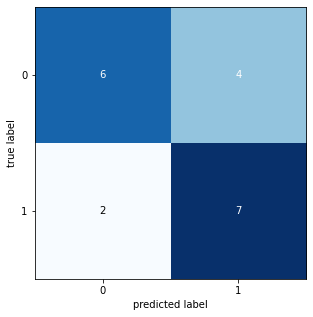

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



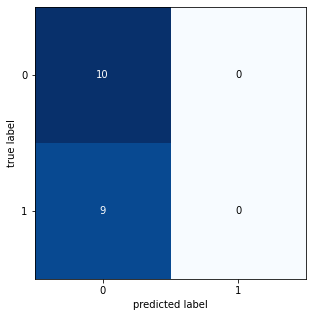

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



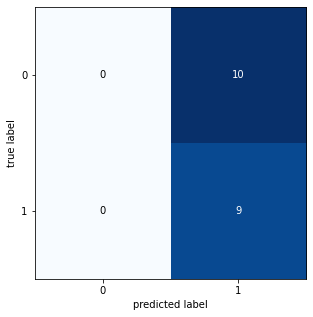

avg accuraccy Breast Cancer =  0.5268421052631579
avg F1_Score Breast Cancer =  0.39865353037766826
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.79852650799967
gene : [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

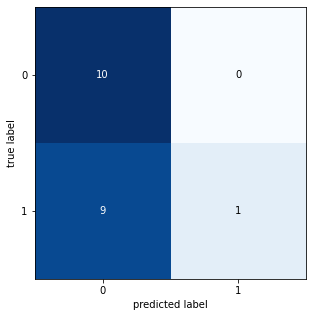

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



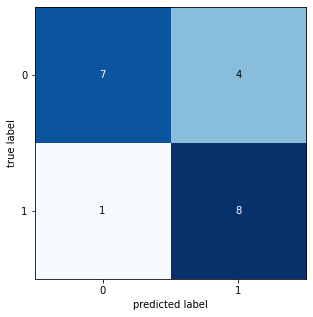

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



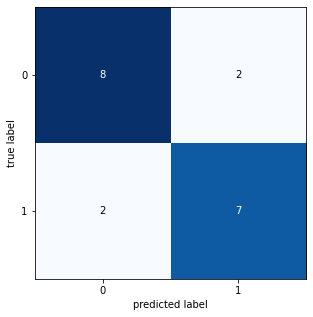

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


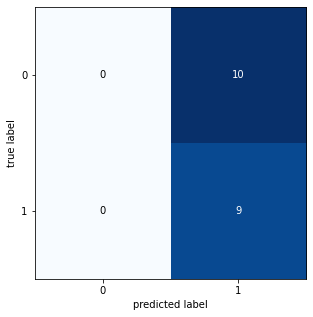

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



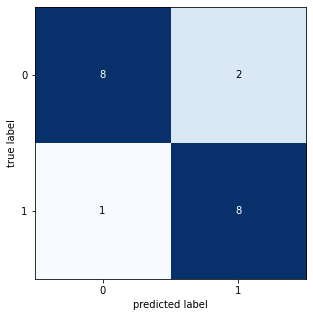

avg accuraccy Breast Cancer =  0.6810526315789474
avg F1_Score Breast Cancer =  0.6275065668350605
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.73965396800031
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


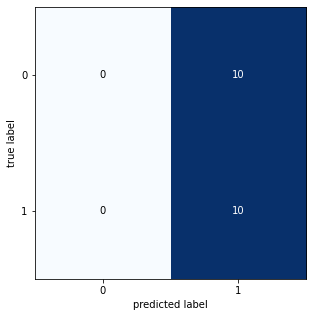

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



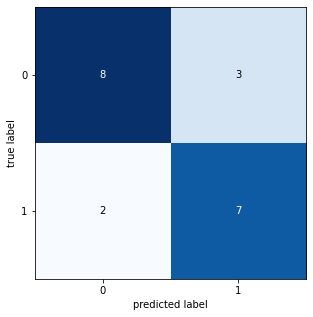

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



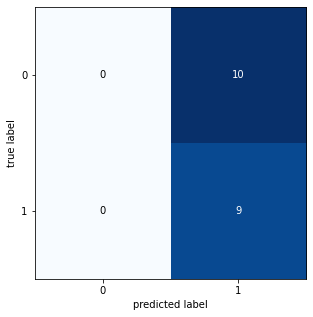

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



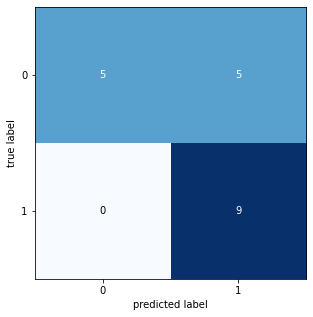

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



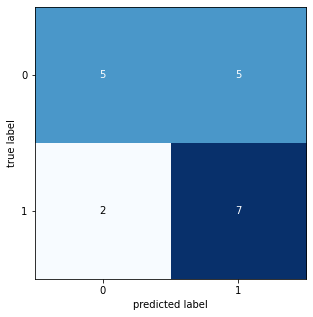

avg accuraccy Breast Cancer =  0.618421052631579
avg F1_Score Breast Cancer =  0.5512447999794883
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.22200376100045
gene : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

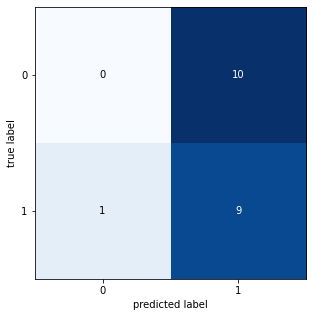

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


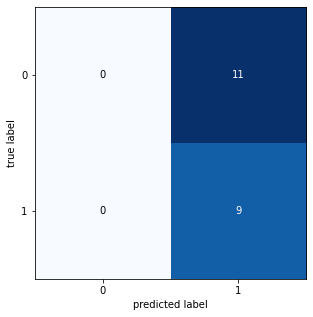

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



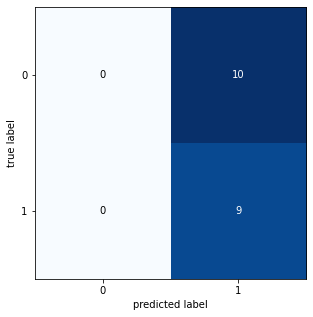

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



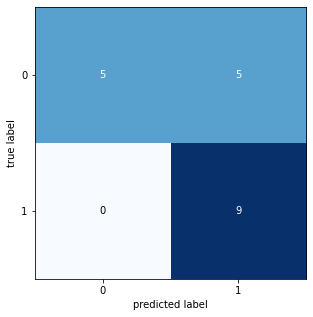

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



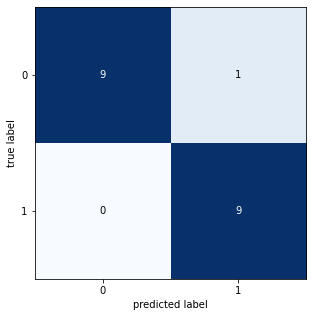

avg accuraccy Breast Cancer =  0.611578947368421
avg F1_Score Breast Cancer =  0.5228248657626076
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.66569492100007
gen terbaik : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.7186985400220695  || Akurasi terbaik : 0.7231578947368421  || jumlah fitur : 48

Generation : 4
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0

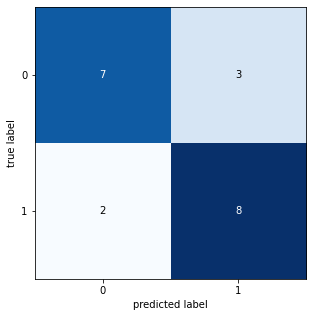

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



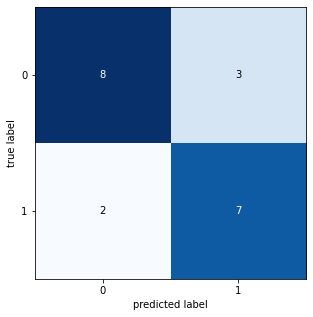

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



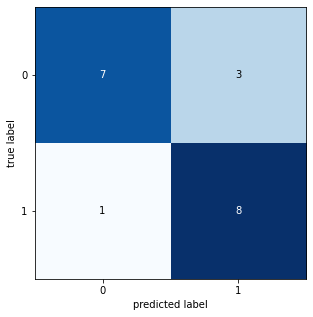

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



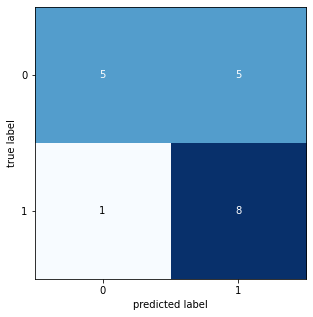

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



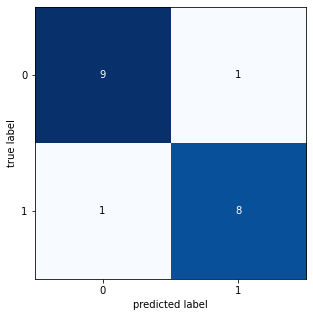

avg accuraccy Breast Cancer =  0.7736842105263159
avg F1_Score Breast Cancer =  0.7716433128275233
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.6842105263157895
min F1_Score Breast Cancer =  0.6761363636363638
Running Time:  41.301535807999244
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

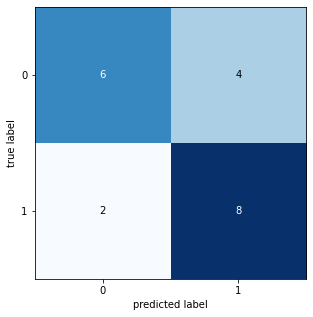

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


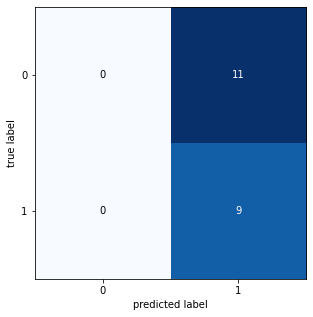

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



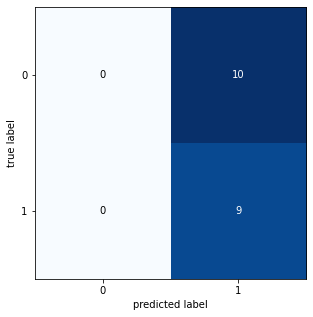

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



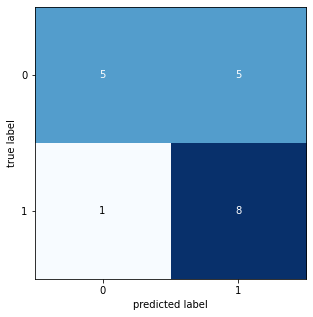

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



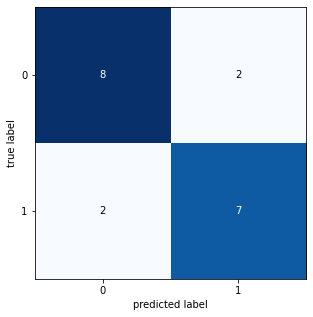

avg accuraccy Breast Cancer =  0.6194736842105263
avg F1_Score Breast Cancer =  0.5587536697019455
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.18824681699971
gene : [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

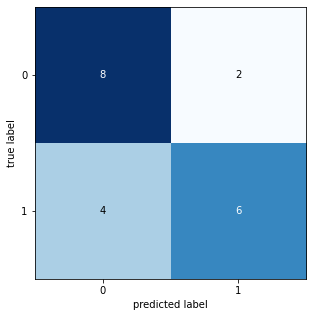

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


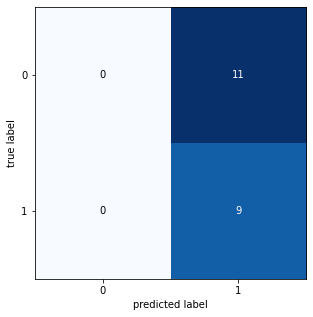

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



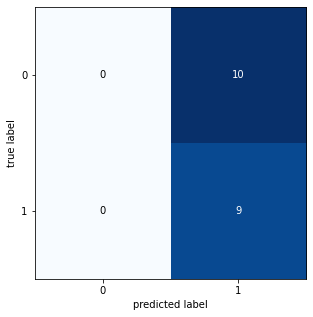

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



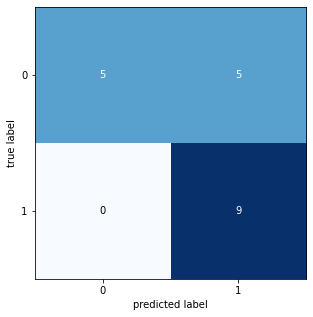

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



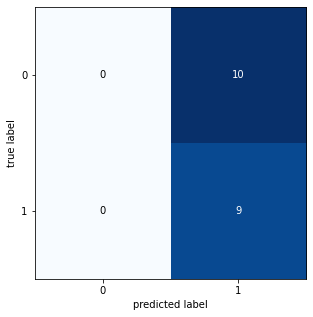

avg accuraccy Breast Cancer =  0.5668421052631578
avg F1_Score Breast Cancer =  0.4749618697144934
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7246376811594203
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.687459511999805
gene : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

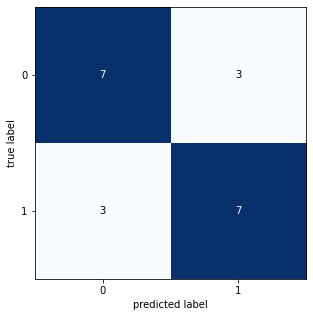

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


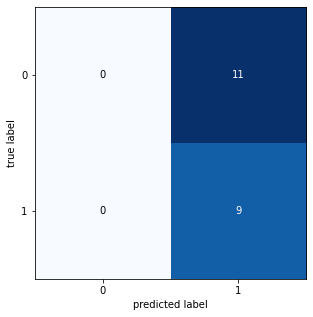

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



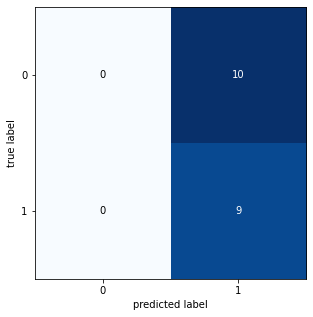

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



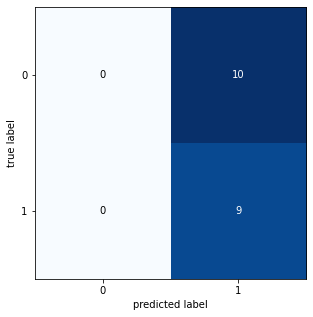

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



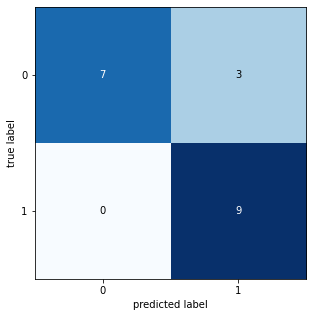

avg accuraccy Breast Cancer =  0.5878947368421052
avg F1_Score Breast Cancer =  0.4987076209794262
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.7328479910002
gene : [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

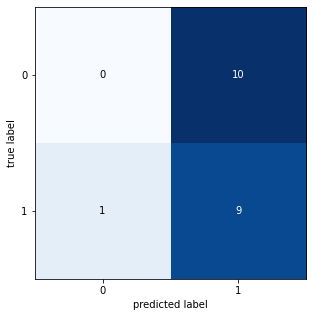

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



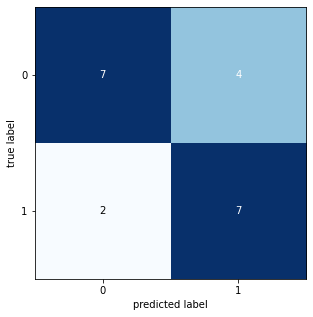

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



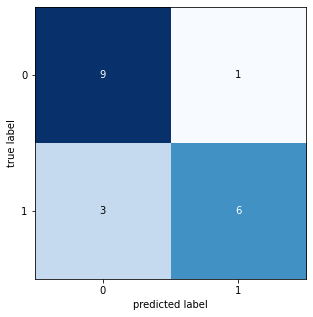

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


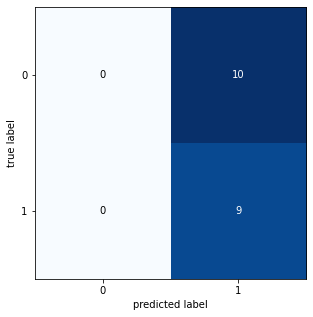

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



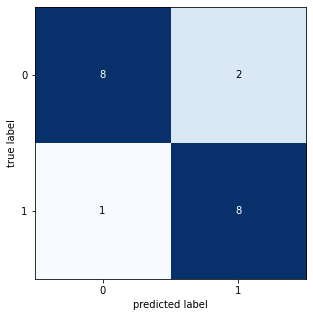

avg accuraccy Breast Cancer =  0.6510526315789473
avg F1_Score Breast Cancer =  0.5915939142527165
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.37411566100036
gene : [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

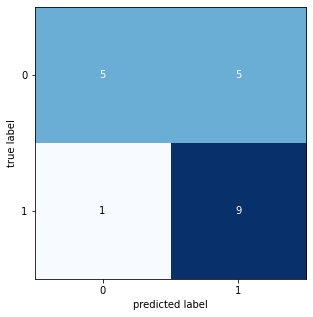

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6428571428571429
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       1.00      0.33      0.50         9

    accuracy                           0.70        20
   macro avg       0.82      0.67      0.64        20
weighted avg       0.81      0.70      0.66        20



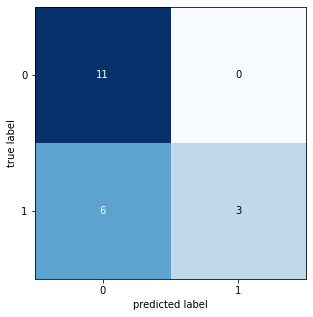

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



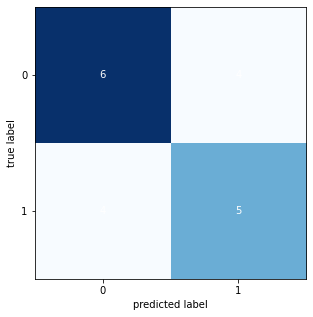

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



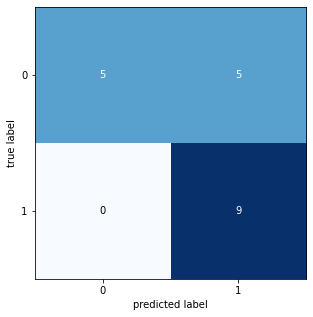

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



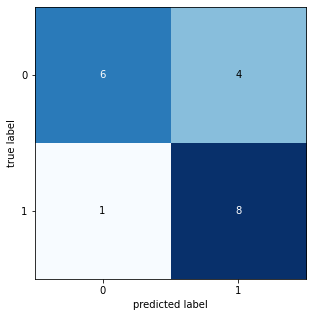

avg accuraccy Breast Cancer =  0.6905263157894737
avg F1_Score Breast Cancer =  0.6733332318434619
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.5789473684210527
min F1_Score Breast Cancer =  0.5777777777777777
Running Time:  40.97214191799958
gene : [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


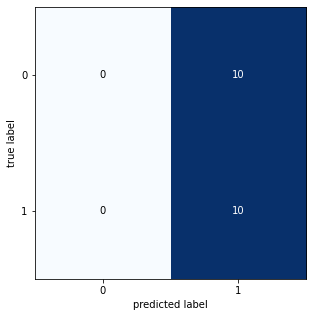

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



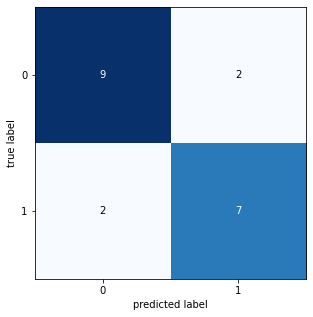

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



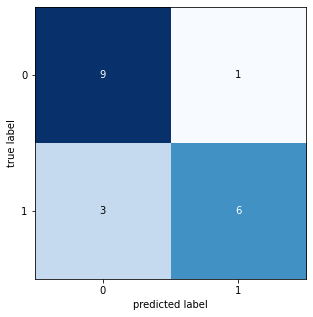

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



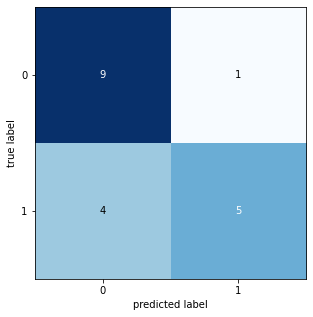

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



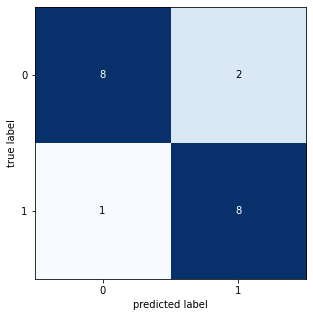

avg accuraccy Breast Cancer =  0.7336842105263158
avg F1_Score Breast Cancer =  0.6964293969442711
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  40.87487074300043
gene : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

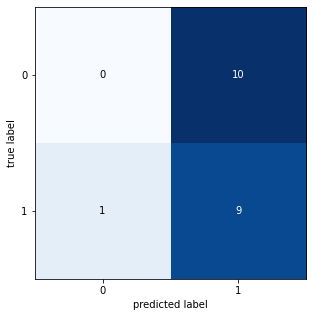

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


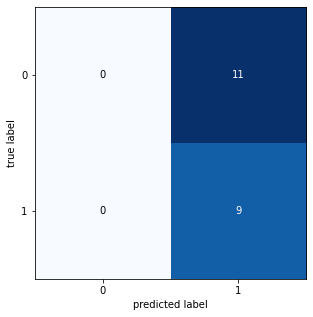

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



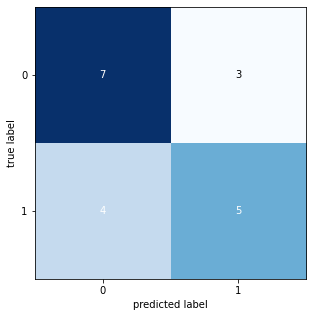

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



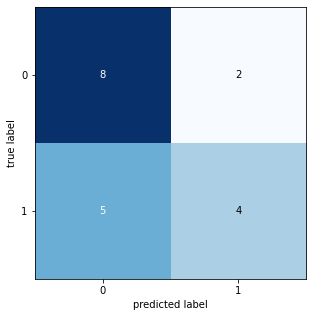

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



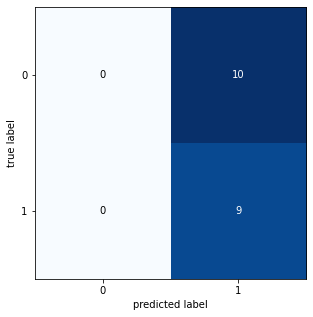

avg accuraccy Breast Cancer =  0.5273684210526316
avg F1_Score Breast Cancer =  0.43681239212326606
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6274509803921569
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.34163040000021
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

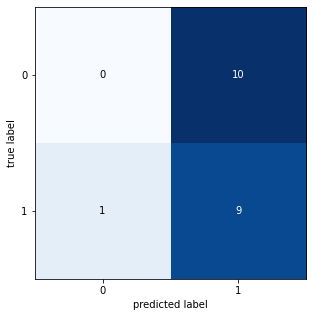

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


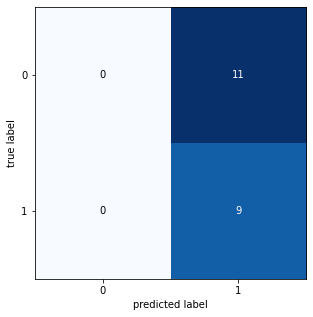

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



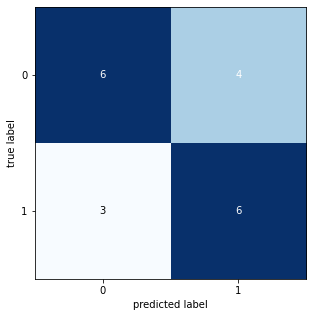

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



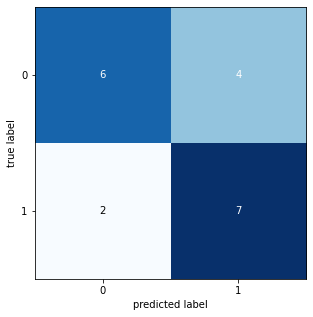

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



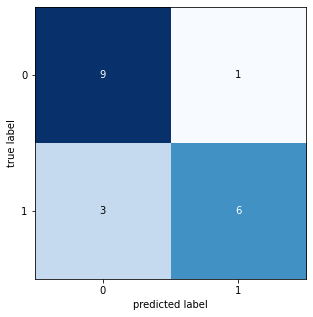

avg accuraccy Breast Cancer =  0.6010526315789473
avg F1_Score Breast Cancer =  0.5439385689930155
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7840909090909092
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.97910188300011
gene : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


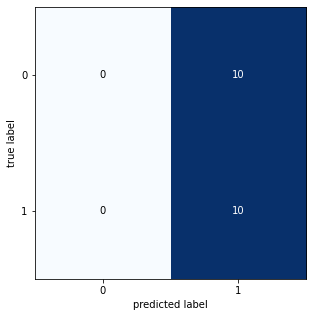

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



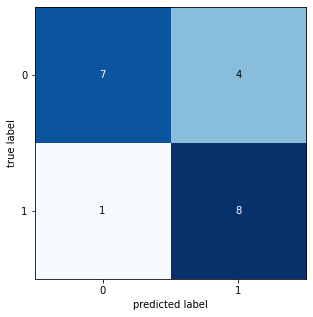

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



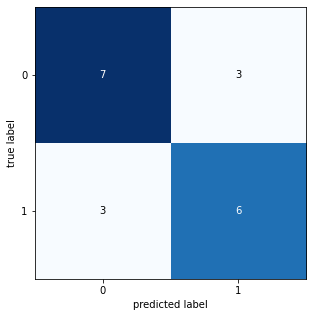

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



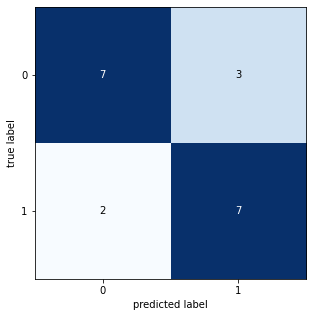

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



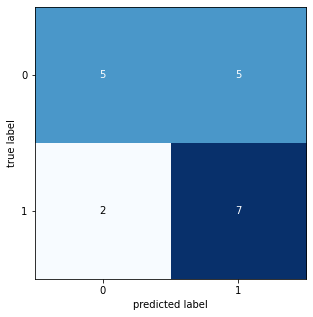

avg accuraccy Breast Cancer =  0.6605263157894736
avg F1_Score Breast Cancer =  0.6260666371811883
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  41.2906651760004
gen terbaik : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.7716433128275233  || Akurasi terbaik : 0.7736842105263159  || jumlah fitur : 50

Running Time:  2075.597649182


In [13]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 2)

Generation : 0
gene : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


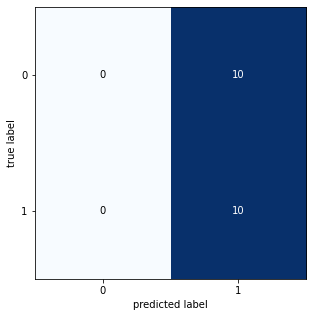

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



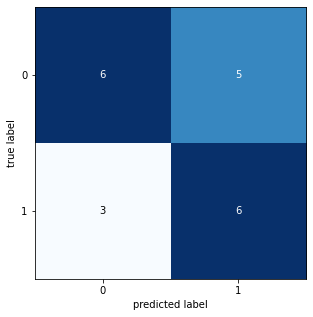

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



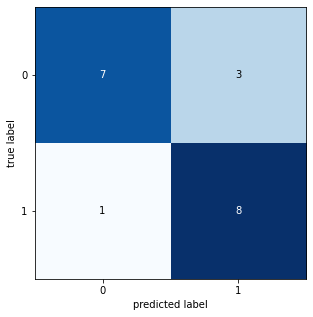

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



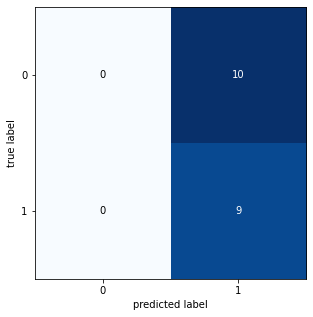

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



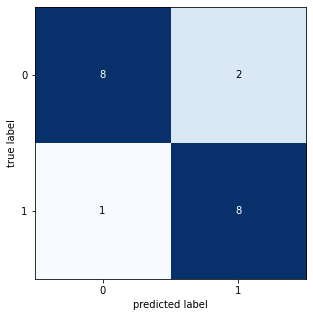

avg accuraccy Breast Cancer =  0.6410526315789473
avg F1_Score Breast Cancer =  0.5771512113617376
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.15198277299987
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

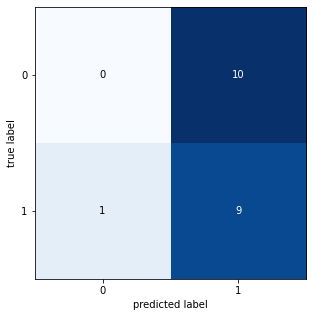

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



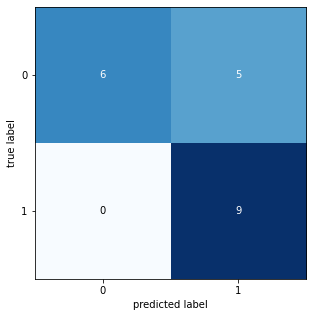

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



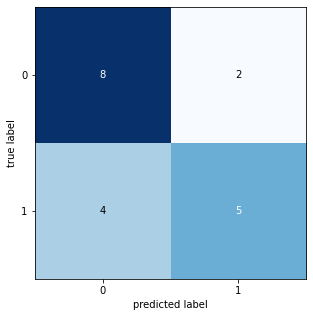

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


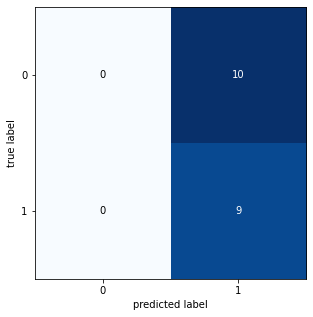

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



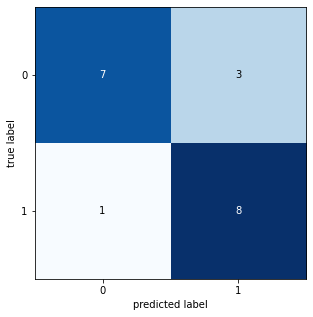

avg accuraccy Breast Cancer =  0.6294736842105264
avg F1_Score Breast Cancer =  0.5682088351673412
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.818280301000414
gene : [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

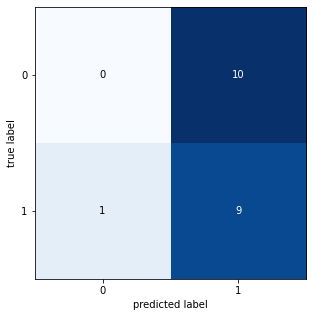

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



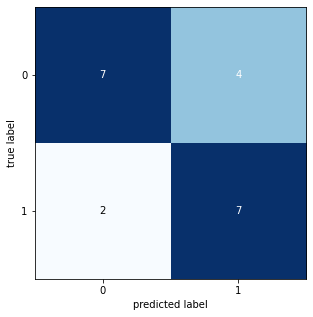

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


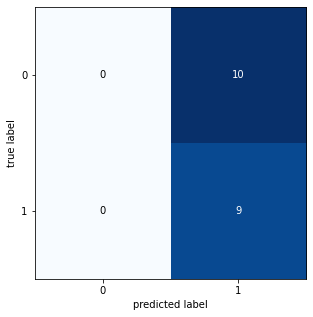

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



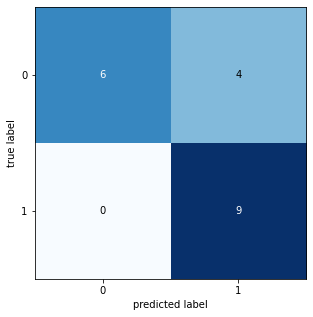

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



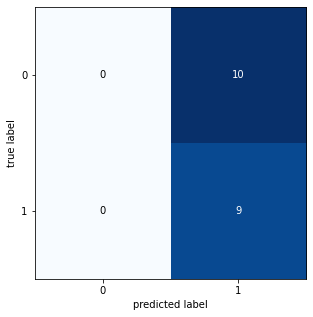

avg accuraccy Breast Cancer =  0.5773684210526315
avg F1_Score Breast Cancer =  0.4874585759068518
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.27497832200061
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


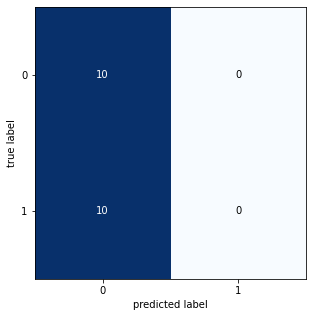

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.8958333333333334
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.78      0.88         9

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20



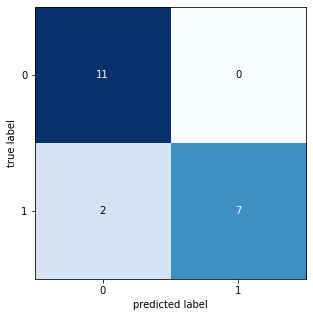

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



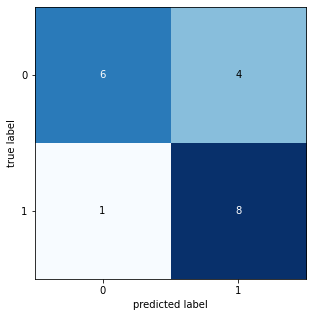

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



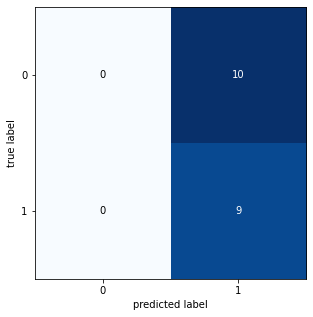

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



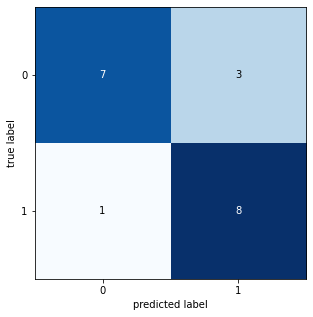

avg accuraccy Breast Cancer =  0.68
avg F1_Score Breast Cancer =  0.6146755368814192
max accuraccy Breast Cancer =  0.9
max F1_Score Breast Cancer =  0.8958333333333334
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.172480907000136
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

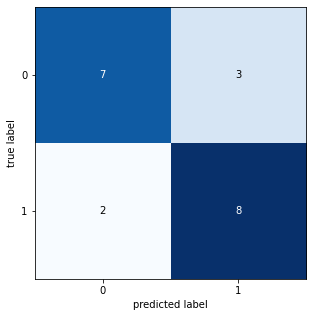

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



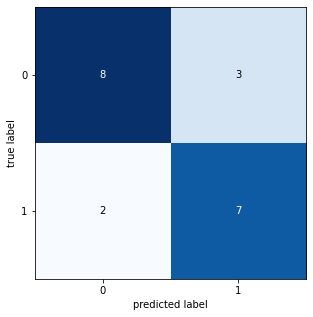

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


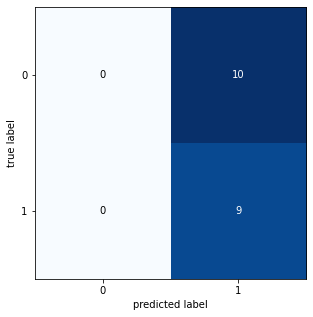

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



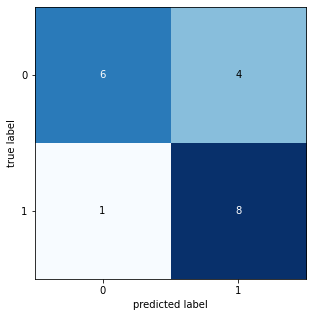

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



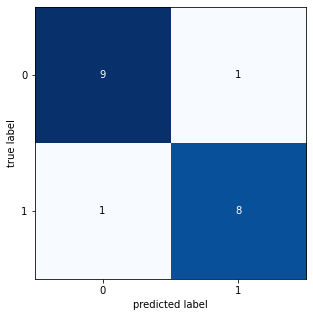

avg accuraccy Breast Cancer =  0.7210526315789474
avg F1_Score Breast Cancer =  0.689702688092781
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444444
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.29180940999959
gene : [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


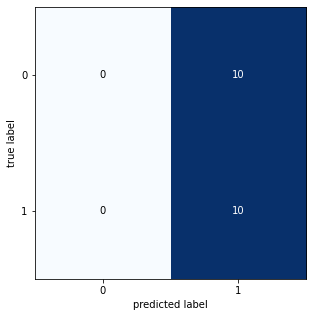

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



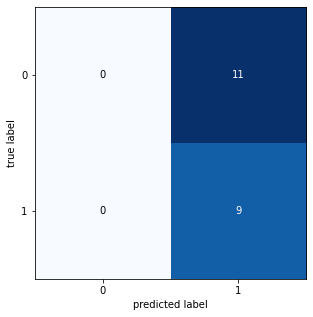

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



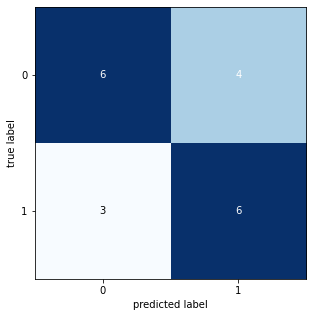

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



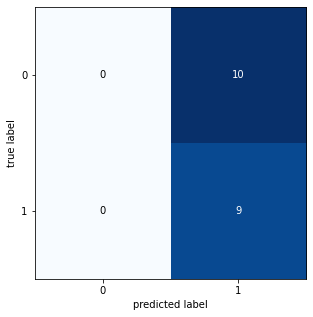

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



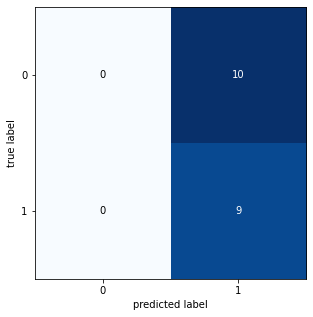

avg accuraccy Breast Cancer =  0.5057894736842106
avg F1_Score Breast Cancer =  0.38362285022902076
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.631578947368421
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.002743281999756
gene : [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

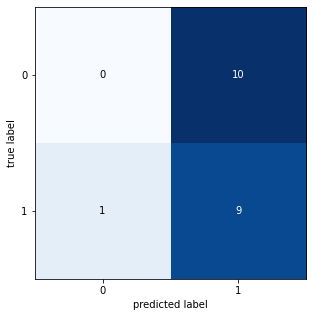

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


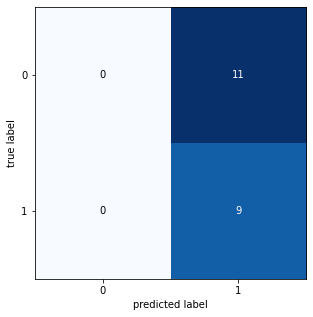

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



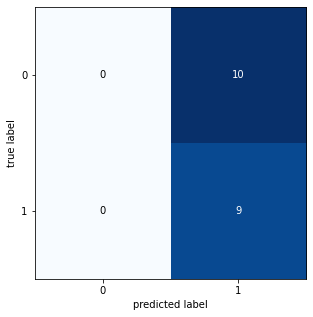

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



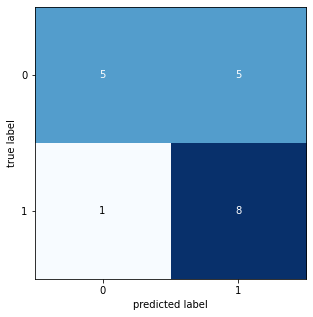

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



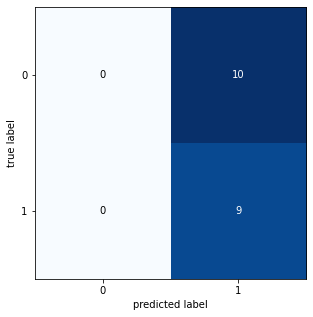

avg accuraccy Breast Cancer =  0.5063157894736843
avg F1_Score Breast Cancer =  0.3879366323331841
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6761363636363638
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.70603592800035
gene : [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


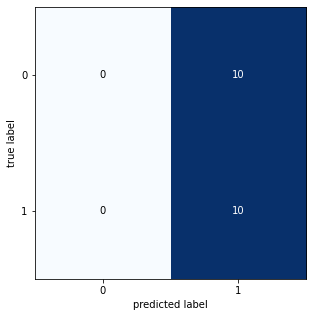

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



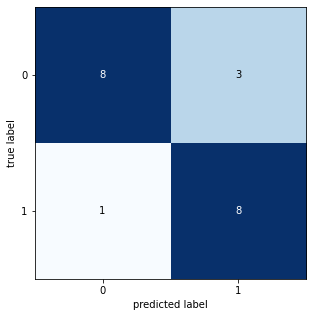

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



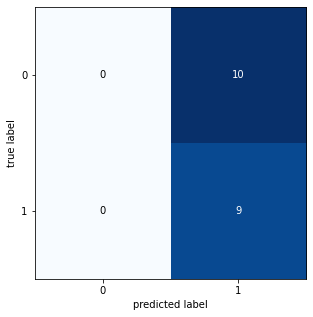

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



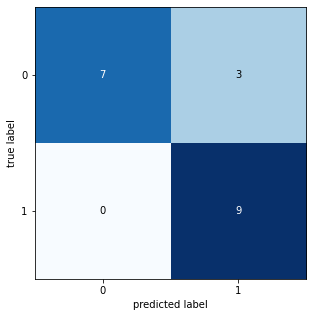

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



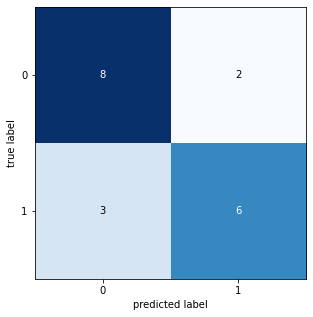

avg accuraccy Breast Cancer =  0.6705263157894736
avg F1_Score Breast Cancer =  0.6057983193277311
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.30058279399964
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

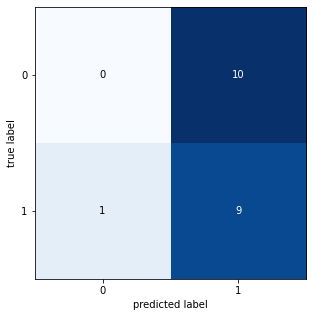

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6011396011396011
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.75      0.33      0.46         9

    accuracy                           0.65        20
   macro avg       0.69      0.62      0.60        20
weighted avg       0.68      0.65      0.62        20



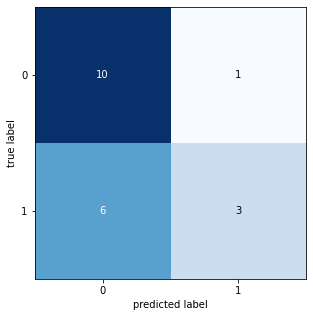

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



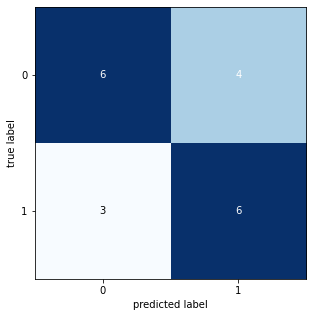

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


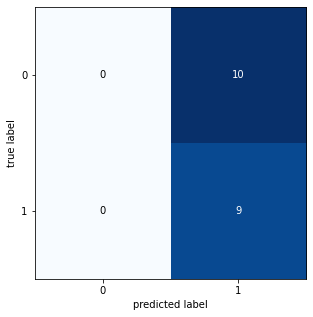

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



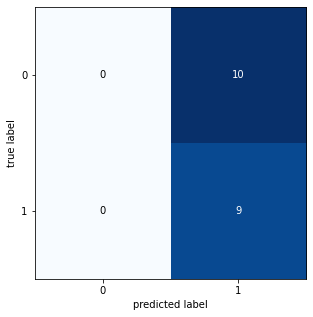

avg accuraccy Breast Cancer =  0.5357894736842106
avg F1_Score Breast Cancer =  0.4371841037902744
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.631578947368421
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.166489306000585
gene : [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

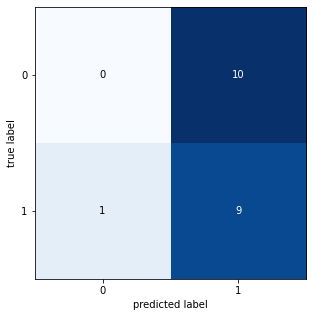

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7802197802197801
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       1.00      0.56      0.71         9

    accuracy                           0.80        20
   macro avg       0.87      0.78      0.78        20
weighted avg       0.85      0.80      0.79        20



Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


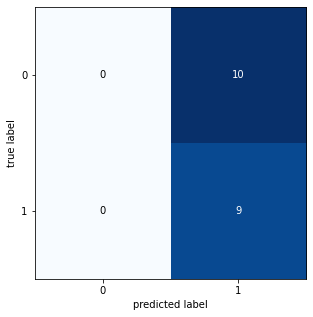

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



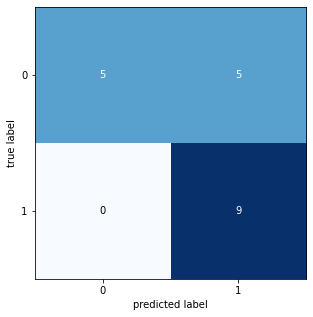

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8920454545454546
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.78      0.88         9

    accuracy                           0.89        19
   macro avg       0.92      0.89      0.89        19
weighted avg       0.91      0.89      0.89        19



avg accuraccy Breast Cancer =  0.6710526315789473
avg F1_Score Breast Cancer =  0.6057352629878866
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8920454545454546
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.715489158999844
gen terbaik : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
F-1 Score terbaik : 0.689702688092781  || Akurasi terbaik : 0.7210526315789474  || jumlah fitur : 45

Generation : 1
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 

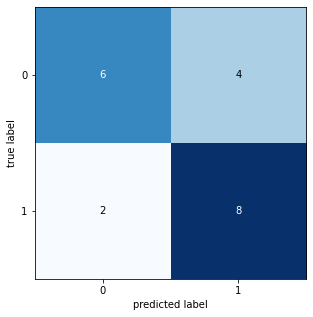

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666666
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.86      0.67      0.75         9

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.79        20
weighted avg       0.81      0.80      0.80        20



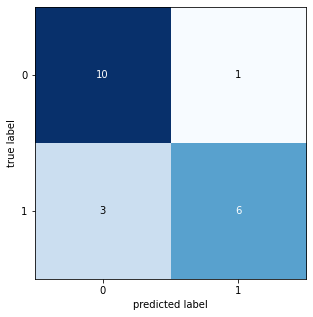

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


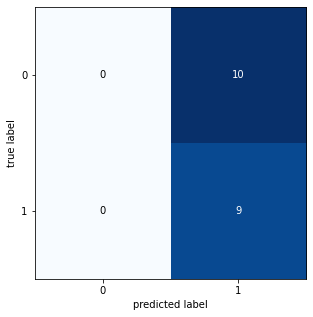

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5128205128205129
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.53      1.00      0.69         9

    accuracy                           0.58        19
   macro avg       0.76      0.60      0.51        19
weighted avg       0.78      0.58      0.50        19



Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



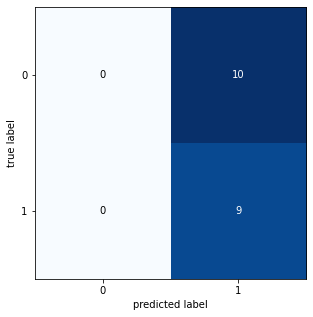

avg accuraccy Breast Cancer =  0.6052631578947368
avg F1_Score Breast Cancer =  0.5288628038628038
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7916666666666666
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.83104443299999
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


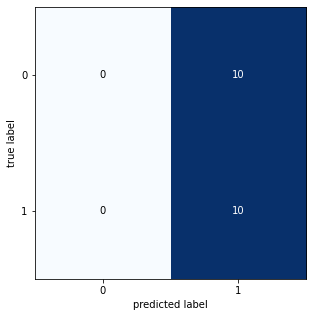

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.4
F1_Score :  0.2857142857142857
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.42      0.89      0.57         9

    accuracy                           0.40        20
   macro avg       0.21      0.44      0.29        20
weighted avg       0.19      0.40      0.26        20



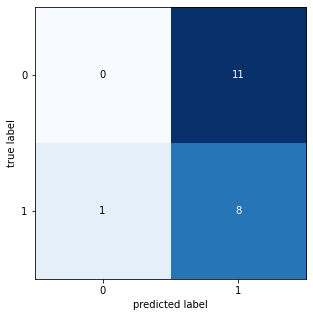

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



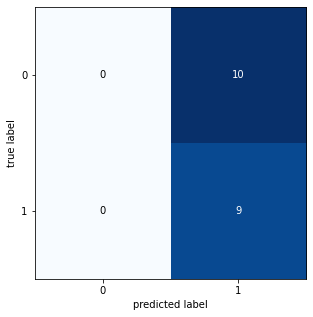

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



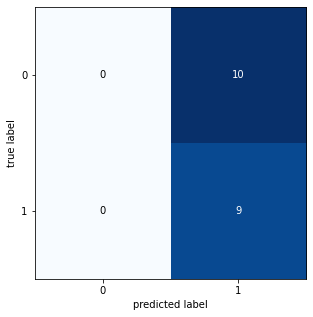

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



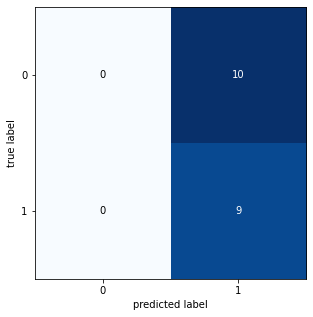

avg accuraccy Breast Cancer =  0.46421052631578946
avg F1_Score Breast Cancer =  0.31666666666666665
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.3333333333333333
min accuraccy Breast Cancer =  0.4
min F1_Score Breast Cancer =  0.2857142857142857
Running Time:  43.10553830899971
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


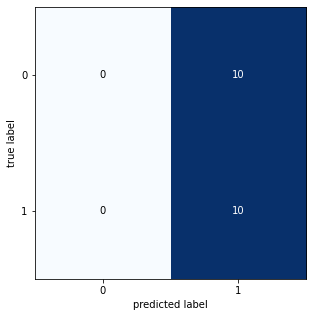

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511277
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.50      0.56      0.53         9

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7738095238095237
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.56      0.71         9

    accuracy                           0.79        19
   macro avg       0.86      0.78      0.77        19
weighted avg       0.85      0.79      0.78        19



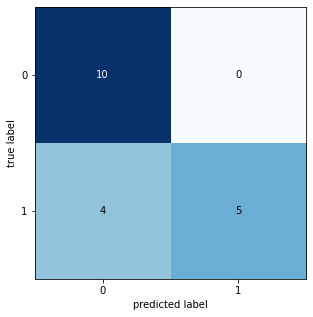

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



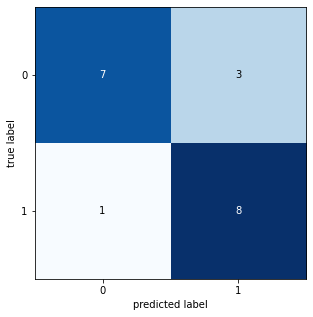

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



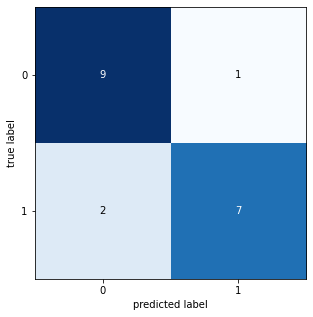

avg accuraccy Breast Cancer =  0.6942105263157895
avg F1_Score Breast Cancer =  0.657048012187331
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  43.30930386399996
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

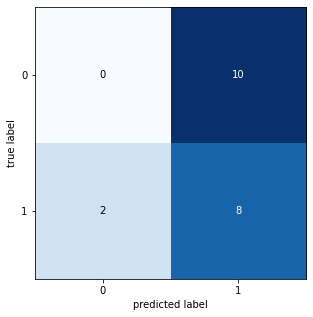

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


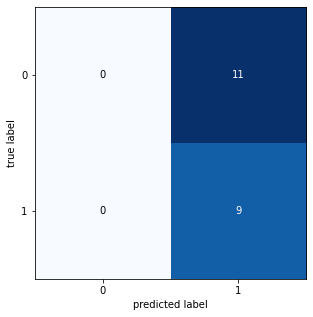

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



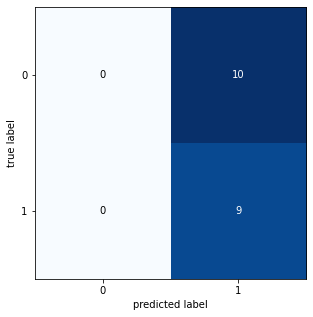

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



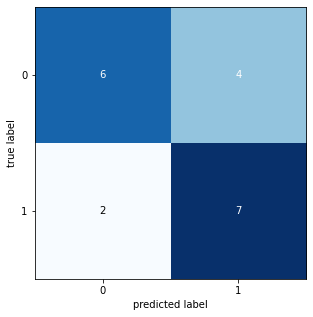

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



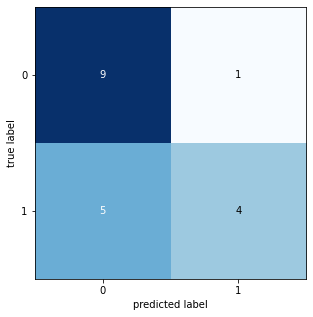

avg accuraccy Breast Cancer =  0.5384210526315789
avg F1_Score Breast Cancer =  0.45230706075533667
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.4
min F1_Score Breast Cancer =  0.2857142857142857
Running Time:  40.92051500799971
gene : [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


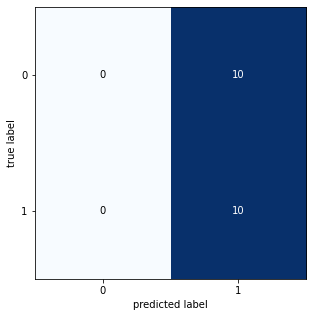

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



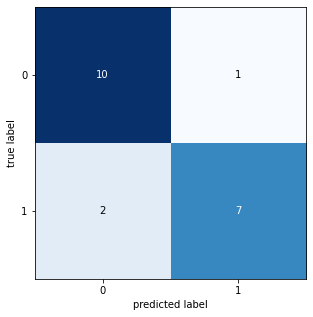

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



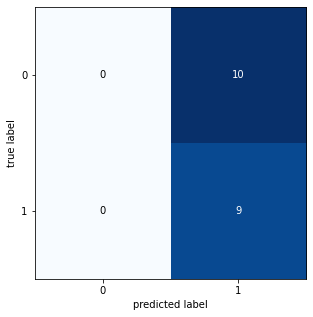

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



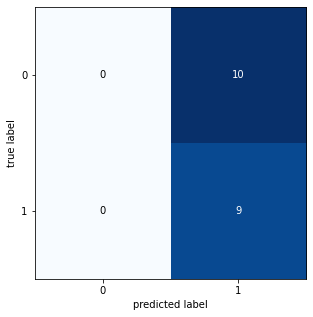

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



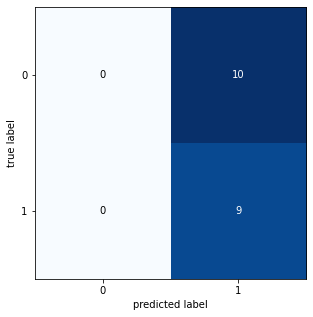

avg accuraccy Breast Cancer =  0.5542105263157895
avg F1_Score Breast Cancer =  0.4288332724394105
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.792659217999244
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

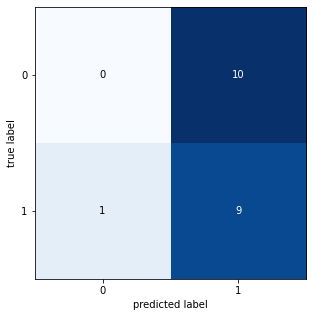

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


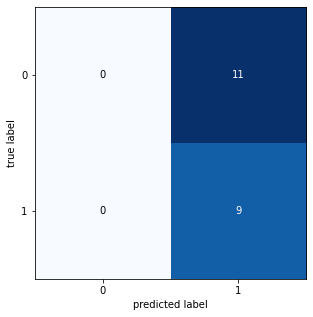

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



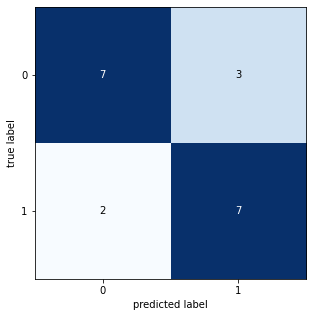

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



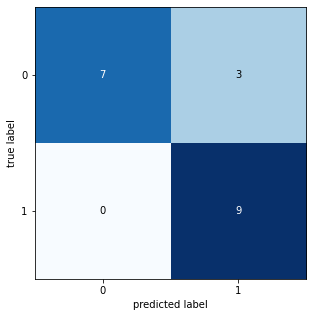

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



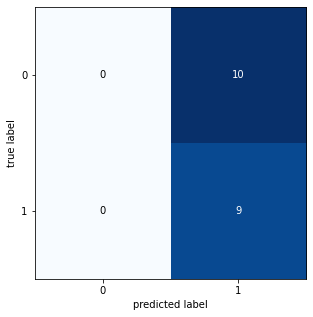

avg accuraccy Breast Cancer =  0.5905263157894737
avg F1_Score Breast Cancer =  0.503859293263585
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.26717256000029
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


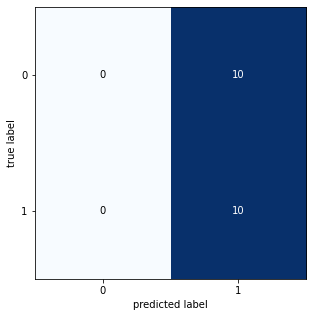

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



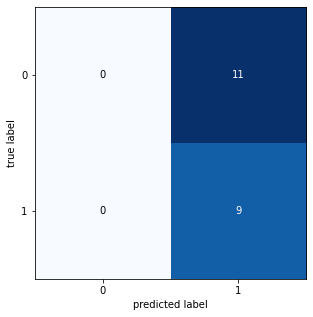

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



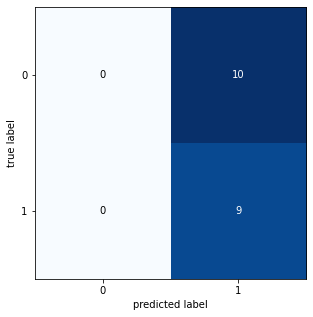

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



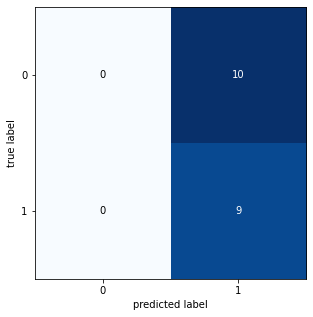

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



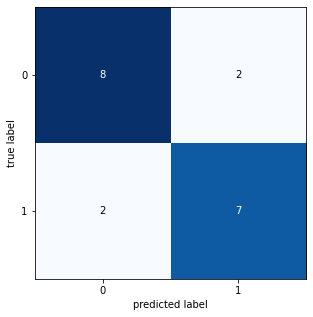

avg accuraccy Breast Cancer =  0.5373684210526315
avg F1_Score Breast Cancer =  0.41508483853311445
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.788888888888889
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.56220645999929
gene : [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


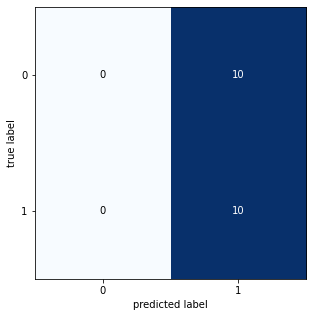

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



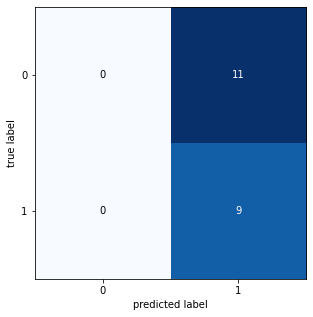

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



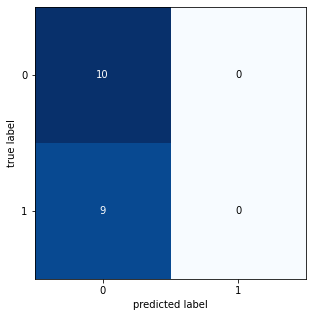

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



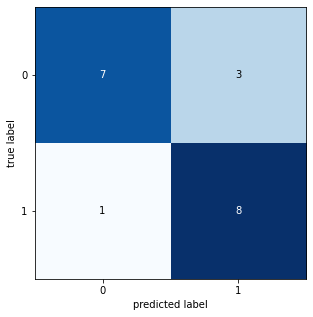

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



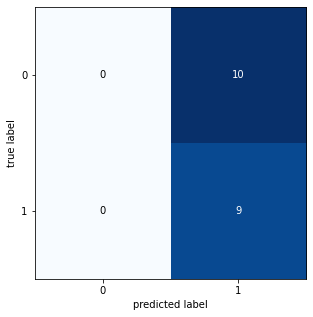

avg accuraccy Breast Cancer =  0.5478947368421053
avg F1_Score Breast Cancer =  0.4197646414887794
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.33651362599994
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

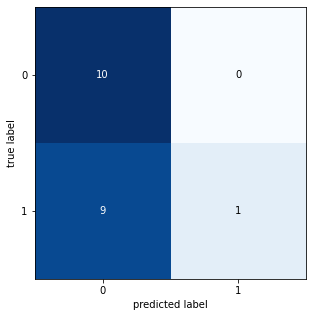

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



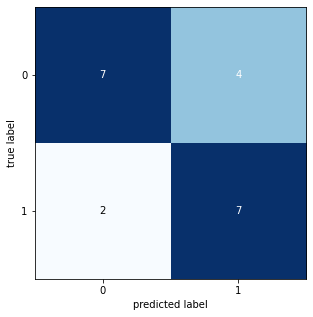

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



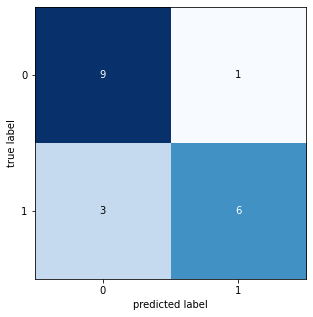

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


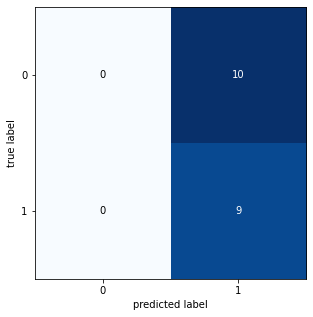

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



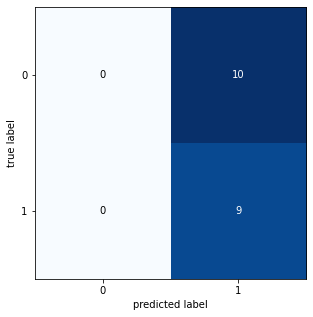

avg accuraccy Breast Cancer =  0.5973684210526317
avg F1_Score Breast Cancer =  0.512536945812808
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7840909090909092
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  37.07206391
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


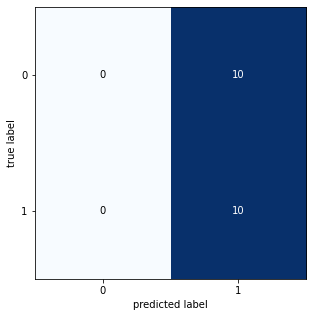

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



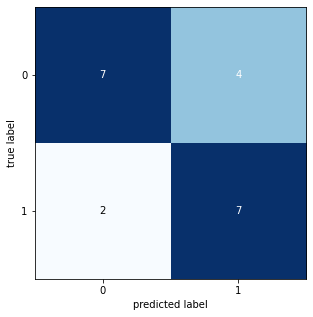

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



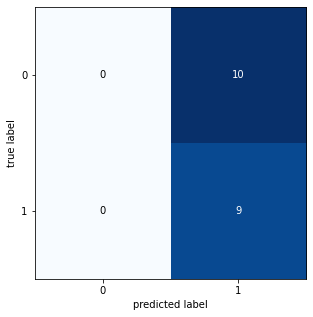

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



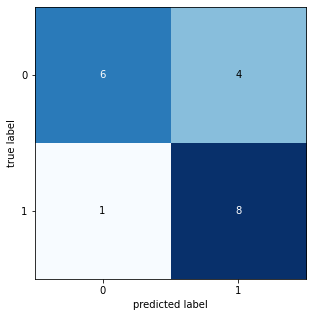

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



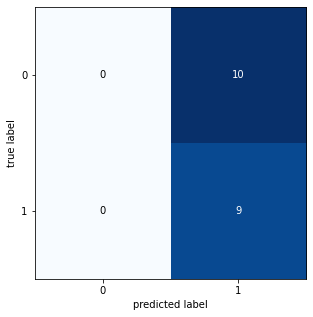

avg accuraccy Breast Cancer =  0.5768421052631579
avg F1_Score Breast Cancer =  0.48201680672268915
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.88453459500033
gen terbaik : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
F-1 Score terbaik : 0.689702688092781  || Akurasi terbaik : 0.7210526315789474  || jumlah fitur : 45

Generation : 2
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,

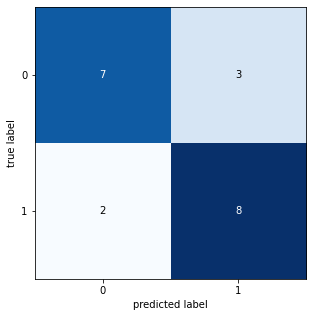

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



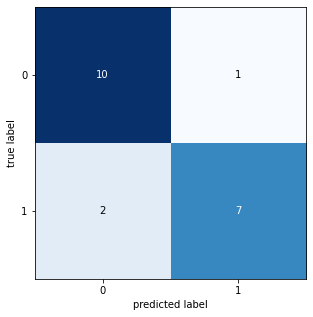

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


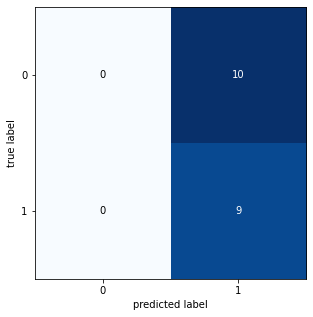

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



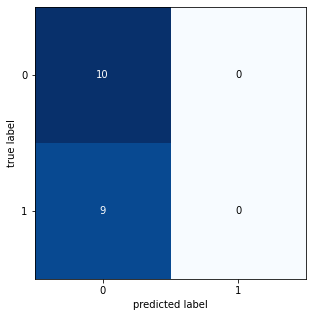

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



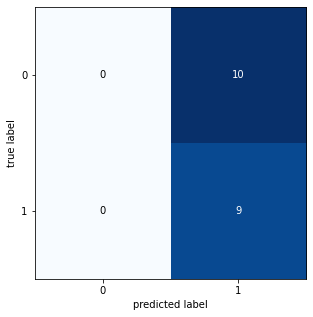

avg accuraccy Breast Cancer =  0.6147368421052632
avg F1_Score Breast Cancer =  0.5167210954452008
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.14013389699994
gene : [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


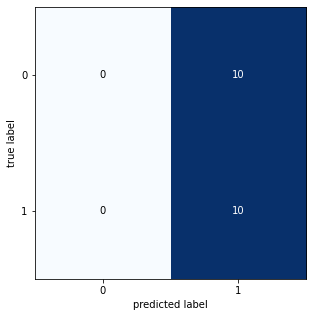

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.3548387096774194
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



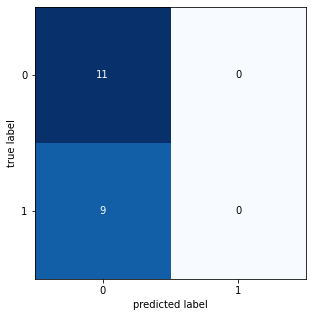

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



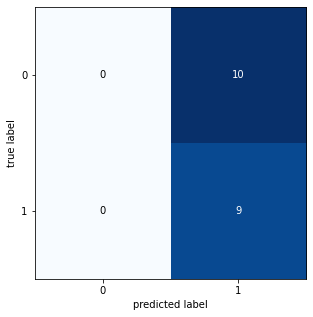

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



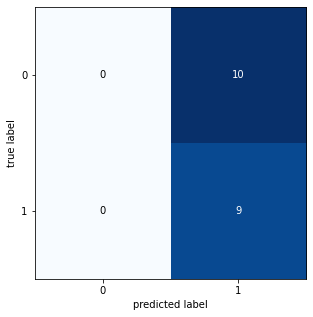

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



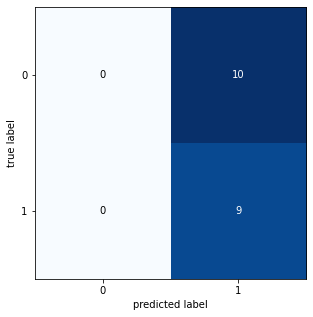

avg accuraccy Breast Cancer =  0.49421052631578943
avg F1_Score Breast Cancer =  0.3304915514592934
max accuraccy Breast Cancer =  0.55
max F1_Score Breast Cancer =  0.3548387096774194
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.421599074999904
gene : [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


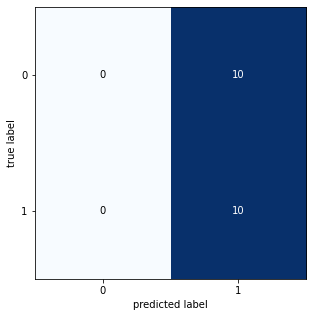

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



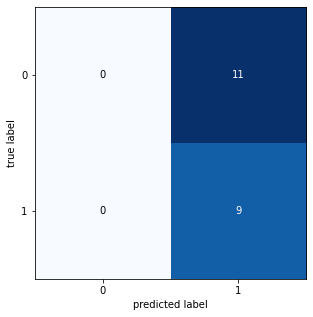

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



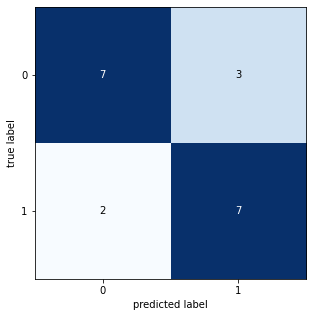

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



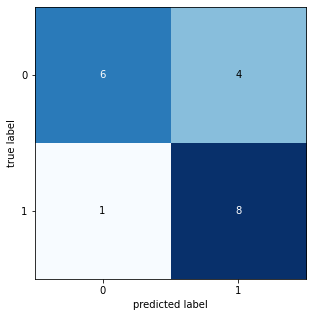

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



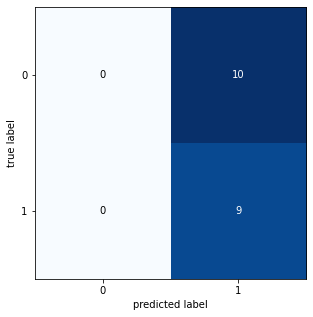

avg accuraccy Breast Cancer =  0.5794736842105264
avg F1_Score Breast Cancer =  0.48716847900684773
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.92151037399981
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


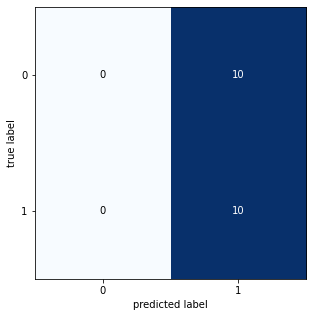

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



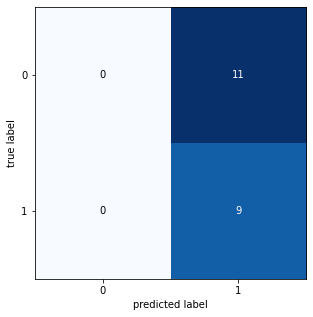

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



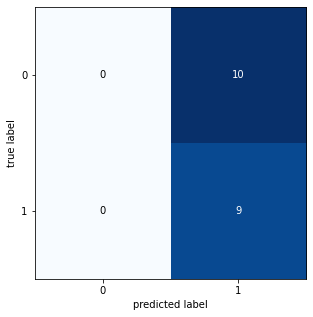

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



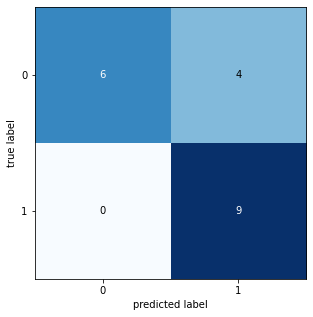

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8920454545454546
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.78      0.88         9

    accuracy                           0.89        19
   macro avg       0.92      0.89      0.89        19
weighted avg       0.91      0.89      0.89        19



avg accuraccy Breast Cancer =  0.621578947368421
avg F1_Score Breast Cancer =  0.528248619196895
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8920454545454546
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.400116976999925
gene : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

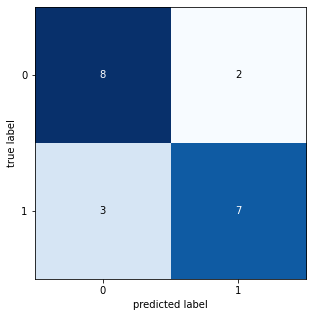

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



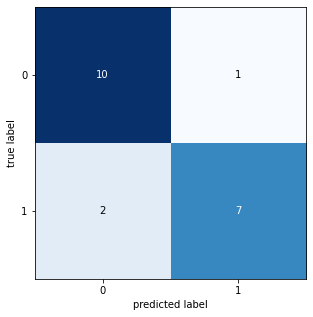

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


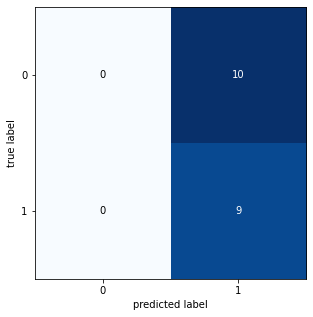

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



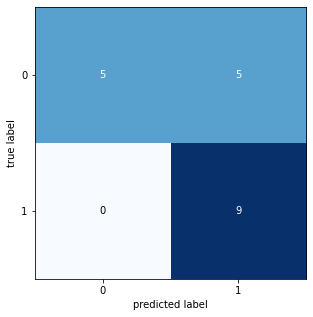

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



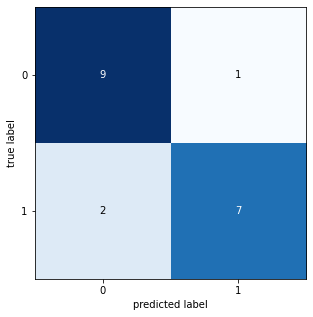

avg accuraccy Breast Cancer =  0.7305263157894737
avg F1_Score Breast Cancer =  0.6964646270407477
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  37.15405809100048
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

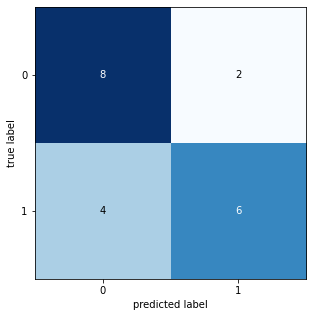

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


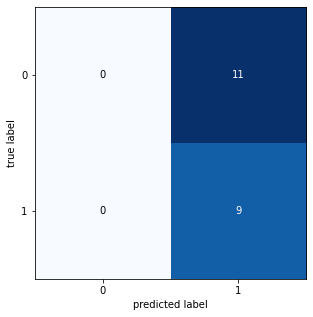

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



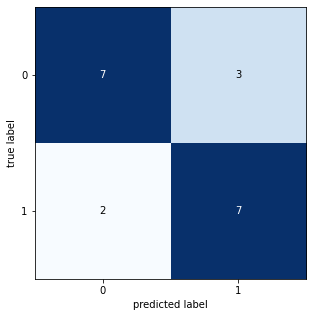

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



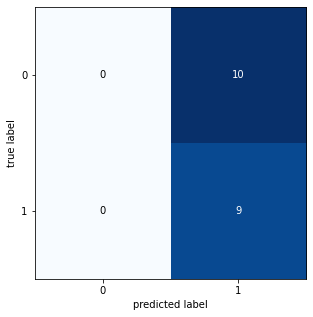

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



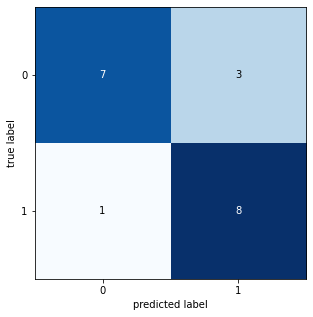

avg accuraccy Breast Cancer =  0.6300000000000001
avg F1_Score Breast Cancer =  0.5708948180273044
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.72658184100055
gene : [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

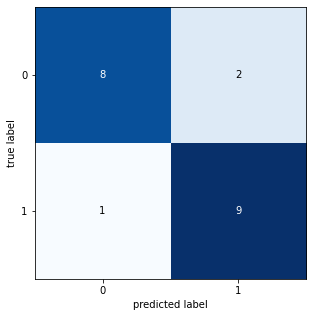

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


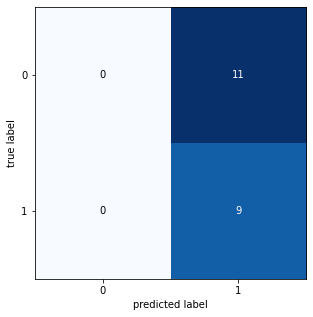

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



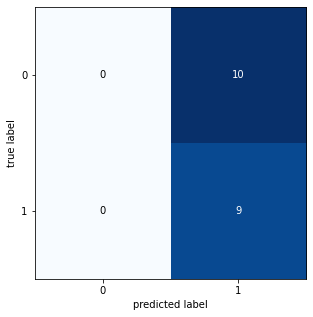

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



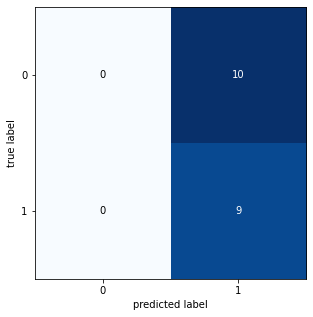

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



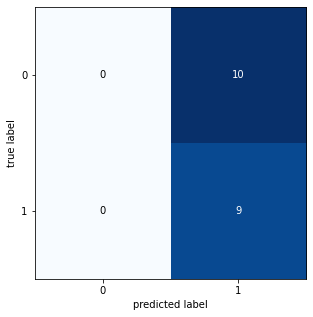

avg accuraccy Breast Cancer =  0.5442105263157895
avg F1_Score Breast Cancer =  0.4248509204044594
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.43526682099946
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


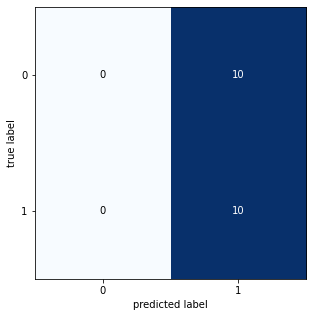

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



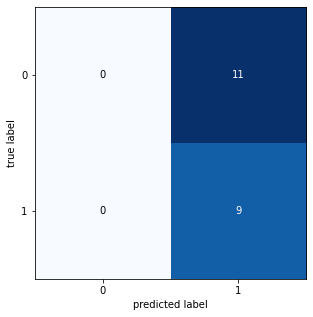

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



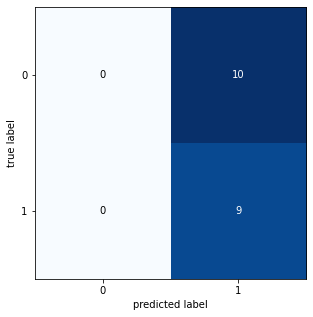

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.57      0.89      0.70         9

    accuracy                           0.63        19
   macro avg       0.69      0.64      0.61        19
weighted avg       0.69      0.63      0.61        19



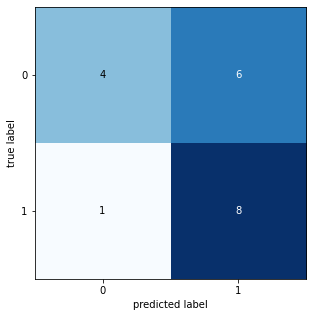

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



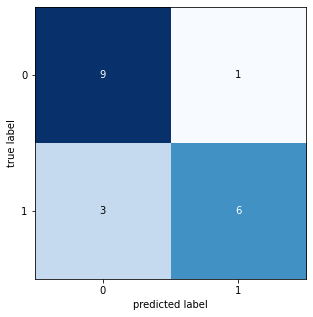

avg accuraccy Breast Cancer =  0.5689473684210526
avg F1_Score Breast Cancer =  0.47273807901244186
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7840909090909092
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.11950849099958
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

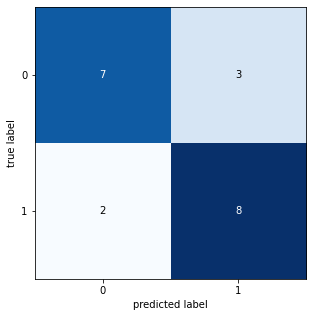

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



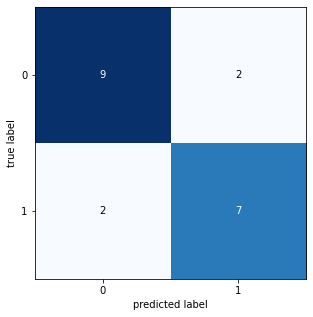

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


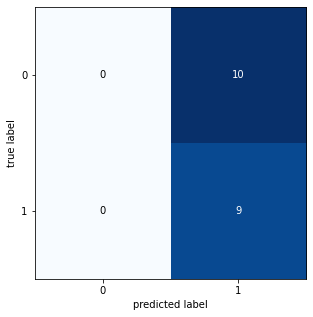

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



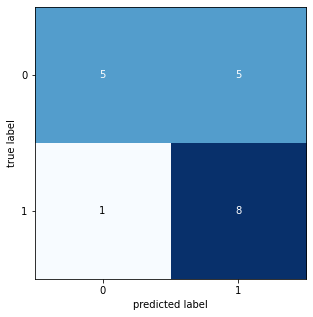

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



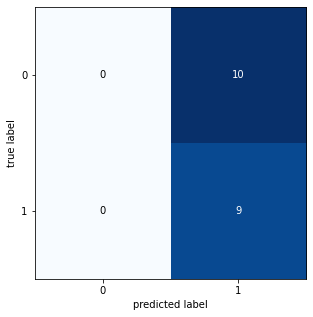

avg accuraccy Breast Cancer =  0.6363157894736842
avg F1_Score Breast Cancer =  0.573269347611453
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  37.82399432999955
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

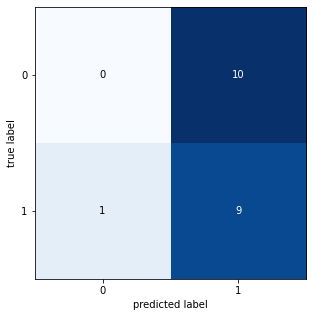

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


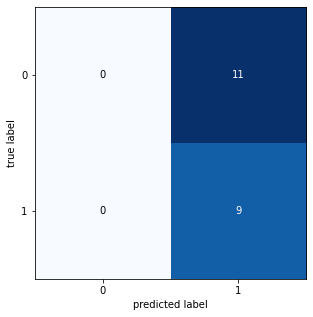

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



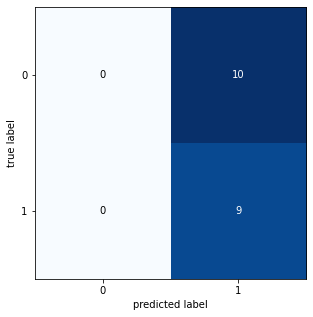

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6346153846153846
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       1.00      0.33      0.50         9

    accuracy                           0.68        19
   macro avg       0.81      0.67      0.63        19
weighted avg       0.80      0.68      0.64        19



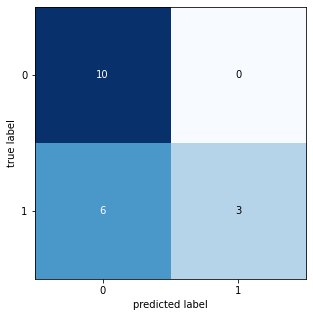

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



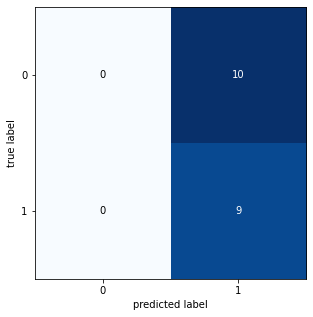

avg accuraccy Breast Cancer =  0.5063157894736843
avg F1_Score Breast Cancer =  0.37963243652898826
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6346153846153846
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.43767816000036
gen terbaik : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.6964646270407477  || Akurasi terbaik : 0.7305263157894737  || jumlah fitur : 56

Generation : 3
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,

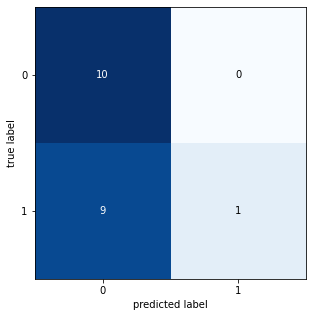

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


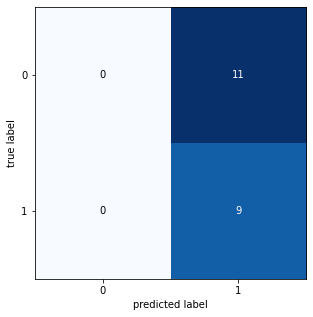

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



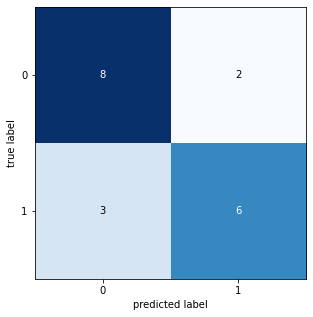

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



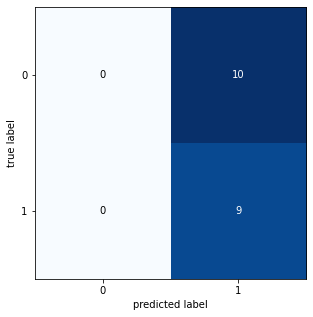

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



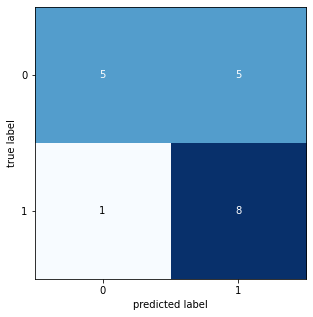

avg accuraccy Breast Cancer =  0.5789473684210527
avg F1_Score Breast Cancer =  0.4955079994380197
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.42082338899945
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

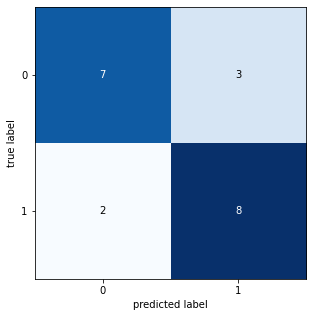

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



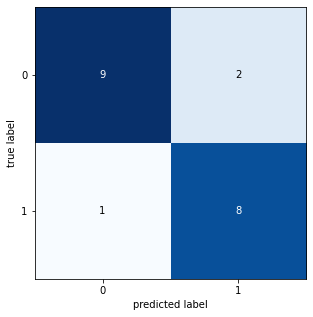

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



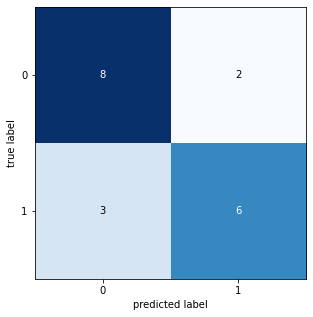

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



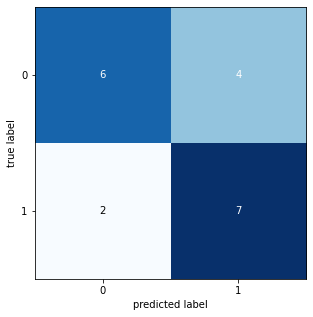

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


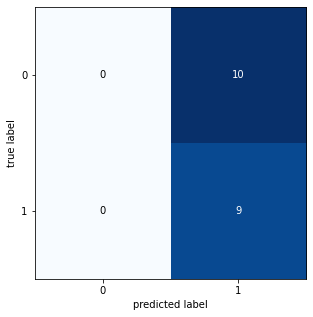

avg accuraccy Breast Cancer =  0.6989473684210527
avg F1_Score Breast Cancer =  0.6675305911838421
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  37.1398965519993
gene : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


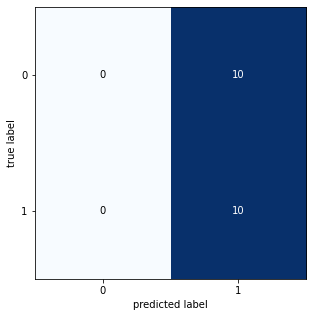

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



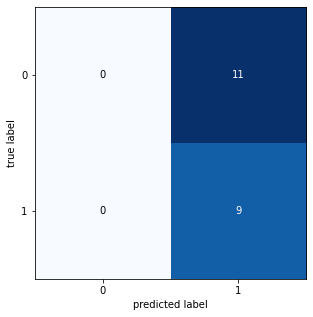

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



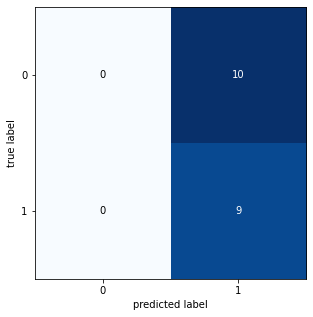

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



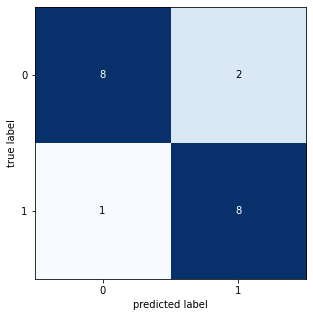

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



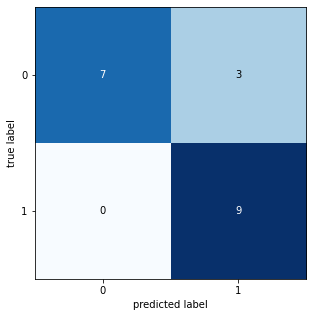

avg accuraccy Breast Cancer =  0.621578947368421
avg F1_Score Breast Cancer =  0.5295096259919576
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.163972199000455
gene : [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

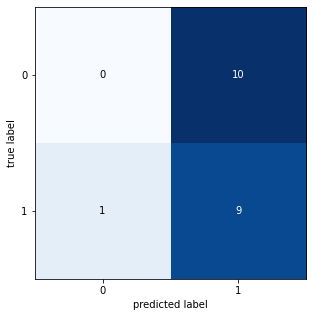

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


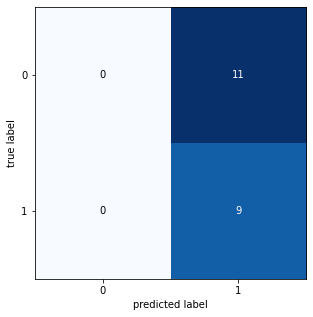

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



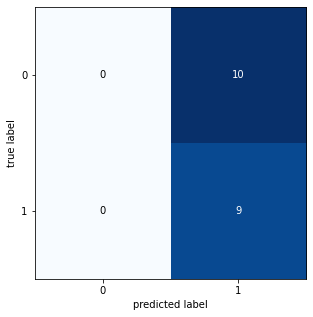

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



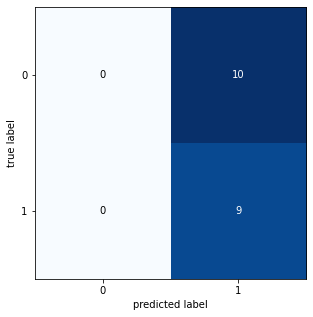

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



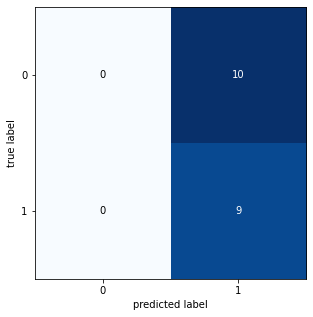

avg accuraccy Breast Cancer =  0.46421052631578946
avg F1_Score Breast Cancer =  0.3169950738916256
max accuraccy Breast Cancer =  0.47368421052631576
max F1_Score Breast Cancer =  0.32142857142857145
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.468622837999646
gene : [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


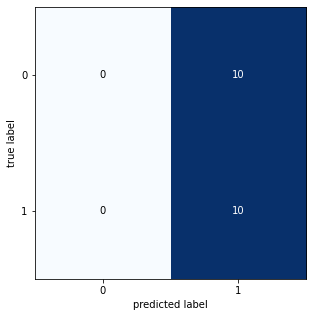

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



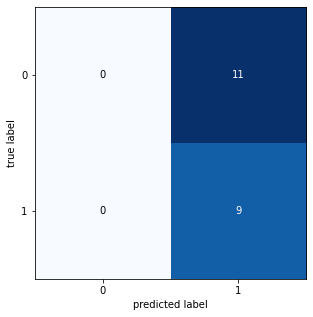

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



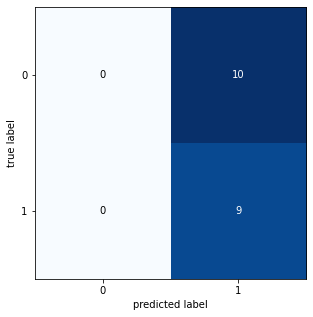

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



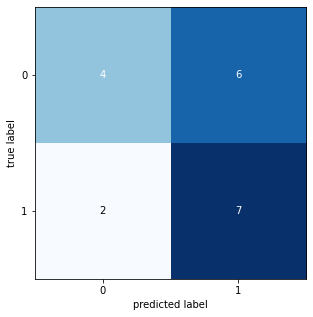

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



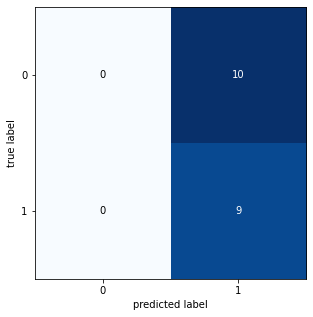

avg accuraccy Breast Cancer =  0.49526315789473685
avg F1_Score Breast Cancer =  0.37094342439170025
max accuraccy Breast Cancer =  0.5789473684210527
max F1_Score Breast Cancer =  0.5681818181818181
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.15899569999874
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


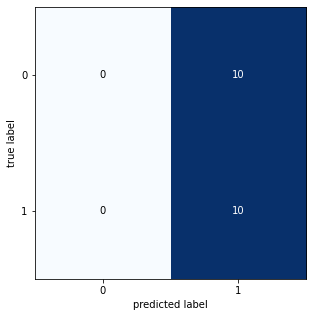

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



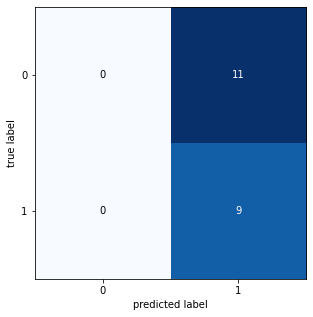

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



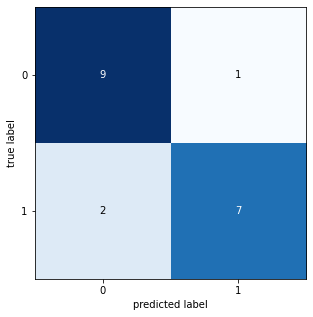

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



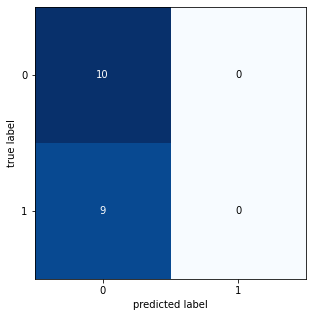

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



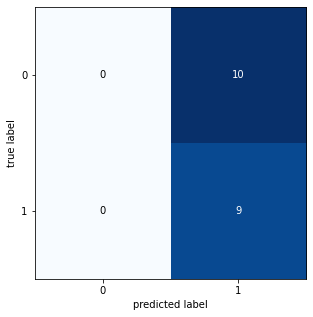

avg accuraccy Breast Cancer =  0.5584210526315789
avg F1_Score Breast Cancer =  0.430054090601758
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.54748050499984
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

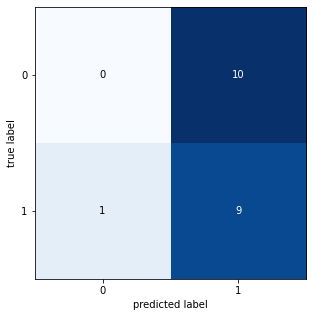

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


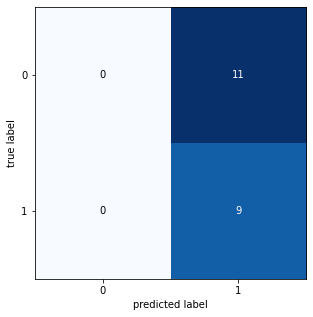

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



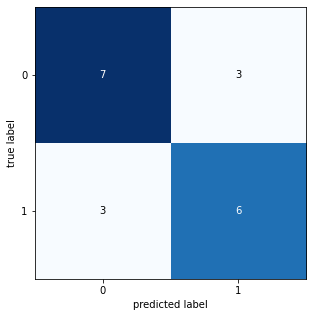

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



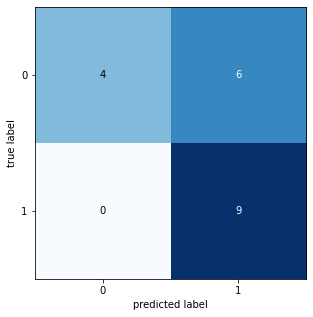

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



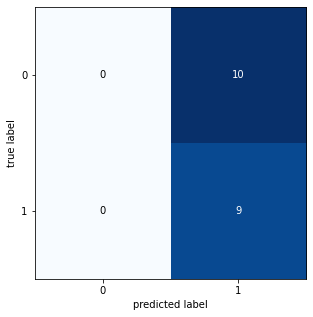

avg accuraccy Breast Cancer =  0.548421052631579
avg F1_Score Breast Cancer =  0.4572331691297209
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.22690483899896
gene : [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


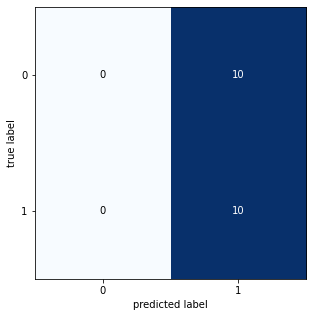

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7802197802197801
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       1.00      0.56      0.71         9

    accuracy                           0.80        20
   macro avg       0.87      0.78      0.78        20
weighted avg       0.85      0.80      0.79        20



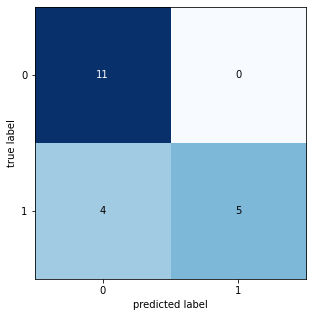

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



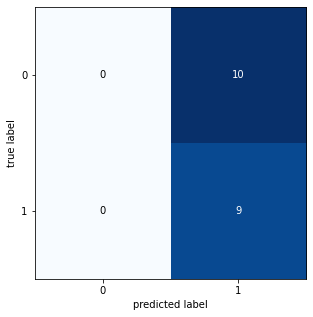

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



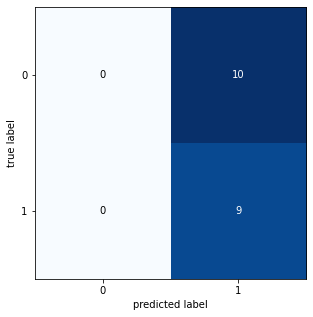

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



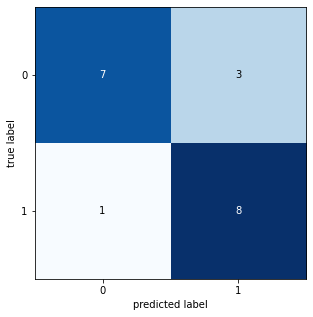

avg accuraccy Breast Cancer =  0.6073684210526317
avg F1_Score Breast Cancer =  0.509059829059829
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.973996939001154
gene : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


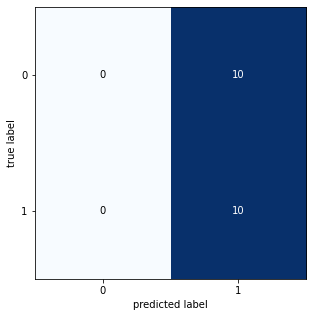

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



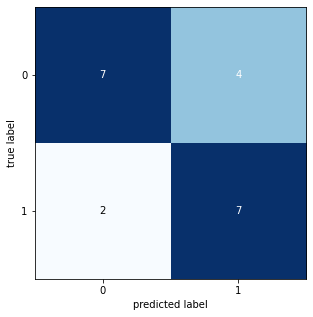

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



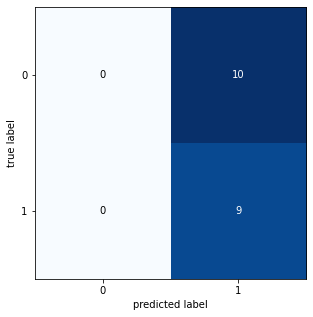

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



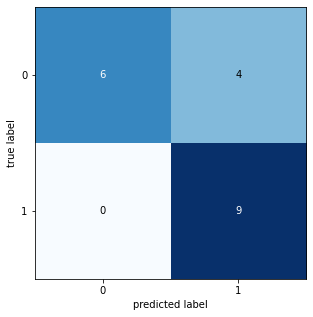

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



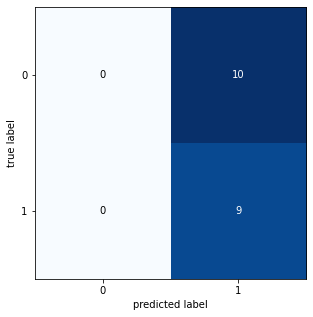

avg accuraccy Breast Cancer =  0.5873684210526315
avg F1_Score Breast Cancer =  0.492056277056277
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.591676552001445
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


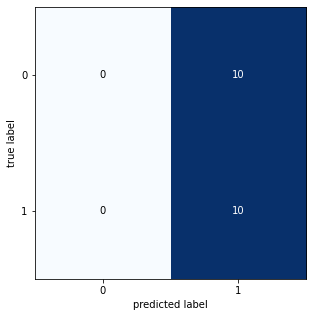

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



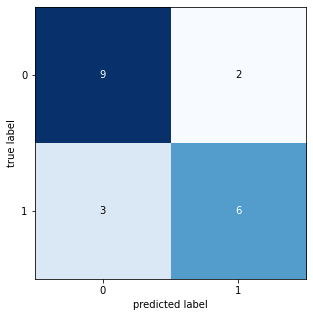

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



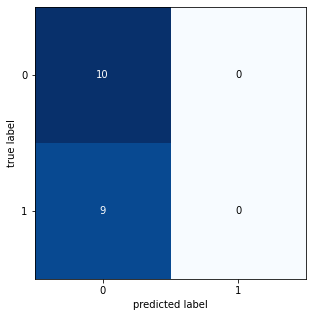

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



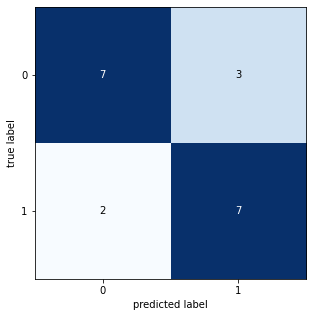

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



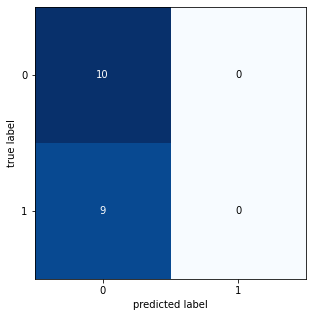

avg accuraccy Breast Cancer =  0.6078947368421053
avg F1_Score Breast Cancer =  0.5008152270613919
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.5
min F1_Score Breast Cancer =  0.3333333333333333
Running Time:  37.81154599000001
gen terbaik : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.6964646270407477  || Akurasi terbaik : 0.7305263157894737  || jumlah fitur : 56

Generation : 4
gene : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


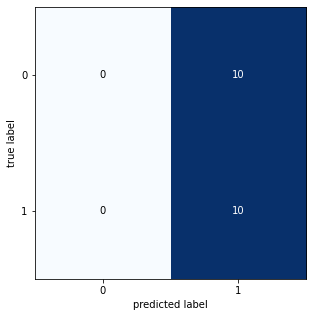

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



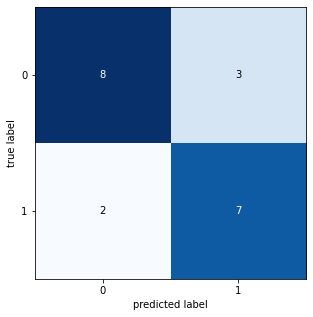

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



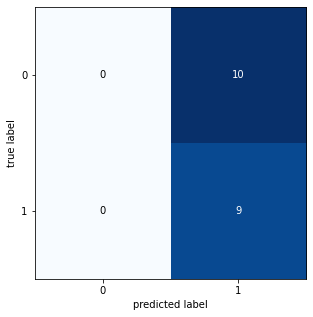

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



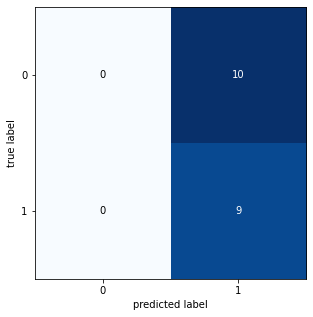

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



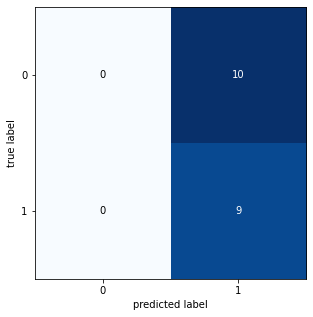

avg accuraccy Breast Cancer =  0.5342105263157895
avg F1_Score Breast Cancer =  0.40939849624060154
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.75727690799977
gene : [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

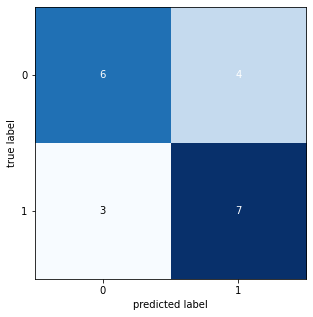

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



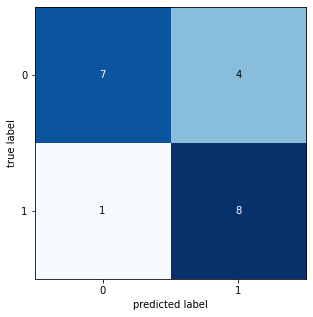

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


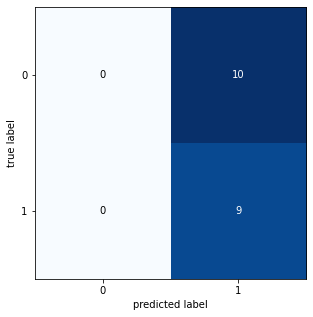

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



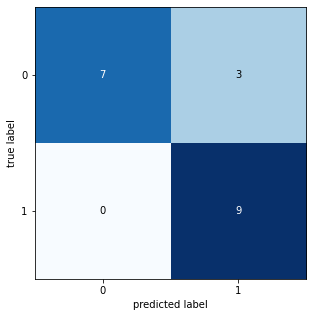

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



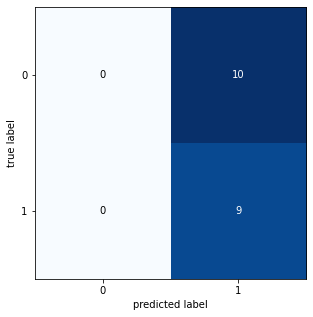

avg accuraccy Breast Cancer =  0.6378947368421052
avg F1_Score Breast Cancer =  0.5763379035824856
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.46225501299887
gene : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

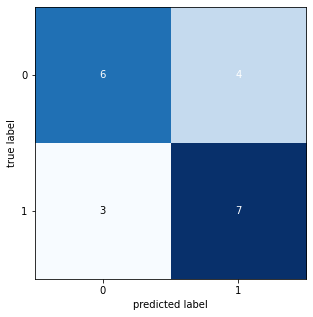

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



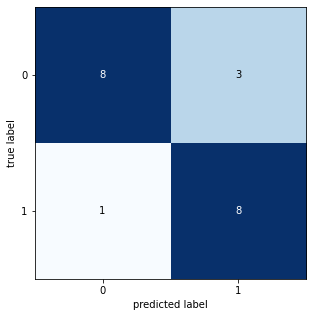

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


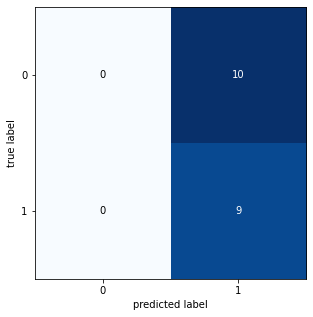

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



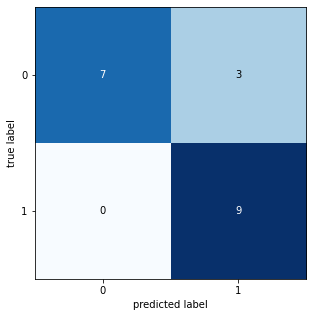

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



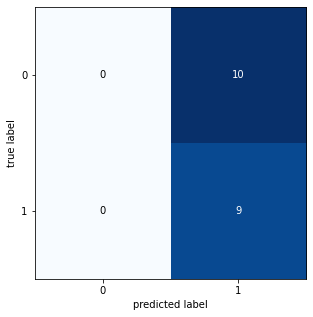

avg accuraccy Breast Cancer =  0.6478947368421053
avg F1_Score Breast Cancer =  0.5864632168656937
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.54965326199999
gene : [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

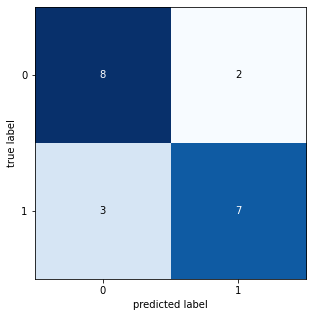

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


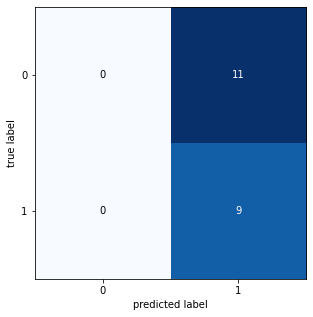

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



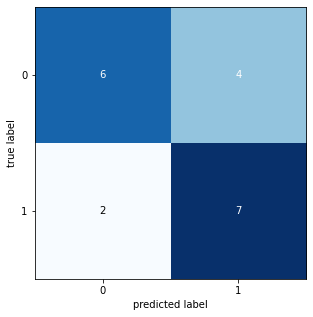

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



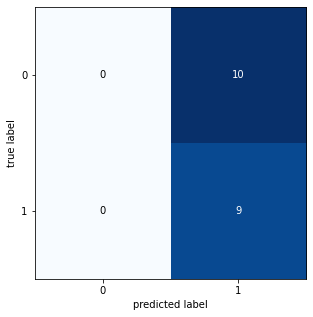

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



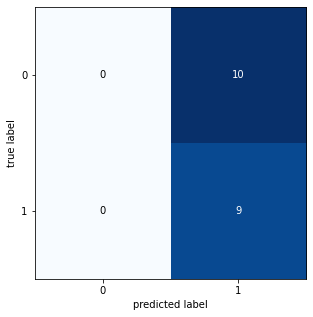

avg accuraccy Breast Cancer =  0.5663157894736843
avg F1_Score Breast Cancer =  0.47718174747212866
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.298073544001454
gene : [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


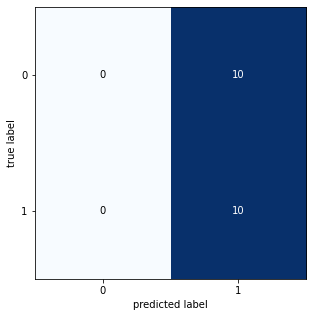

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



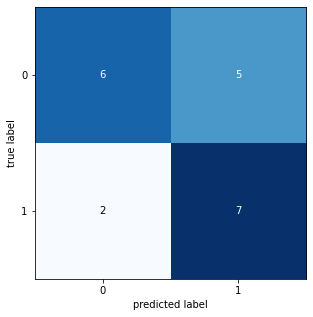

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



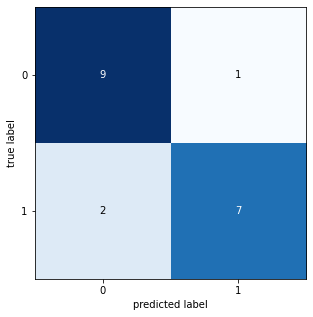

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



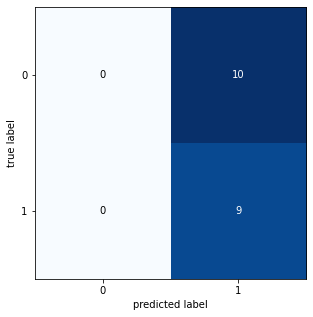

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7738095238095237
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.56      0.71         9

    accuracy                           0.79        19
   macro avg       0.86      0.78      0.77        19
weighted avg       0.85      0.79      0.78        19



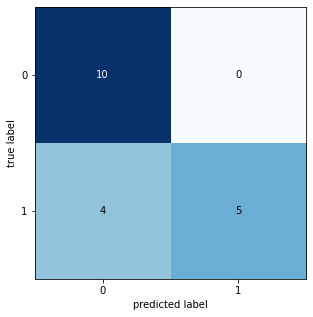

avg accuraccy Breast Cancer =  0.6510526315789473
avg F1_Score Breast Cancer =  0.5836060740085508
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  37.971900559999995
gene : [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


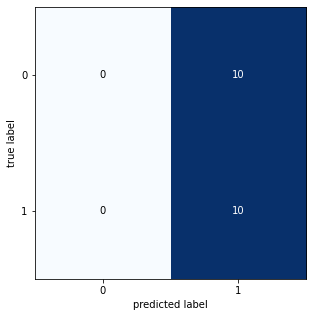

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



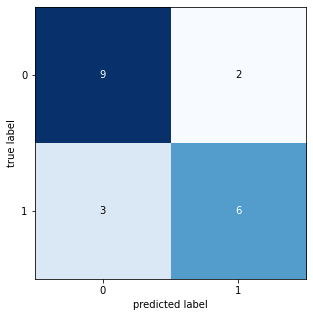

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



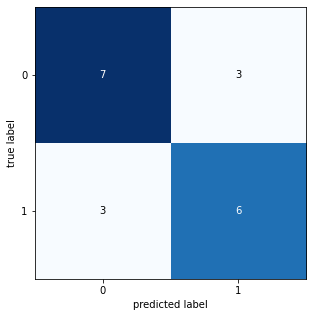

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



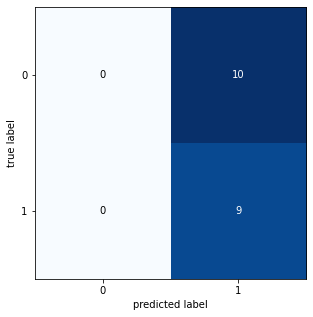

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



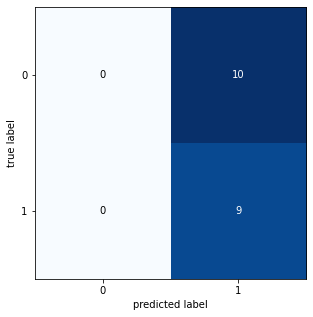

avg accuraccy Breast Cancer =  0.5763157894736842
avg F1_Score Breast Cancer =  0.48075386676409704
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.063668047001556
gene : [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


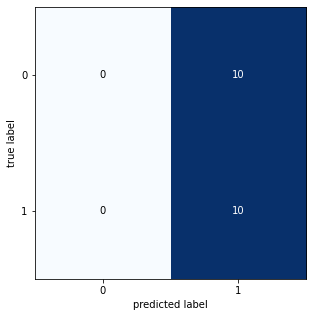

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.40476190476190477
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.47      1.00      0.64         9

    accuracy                           0.50        20
   macro avg       0.74      0.55      0.40        20
weighted avg       0.76      0.50      0.38        20



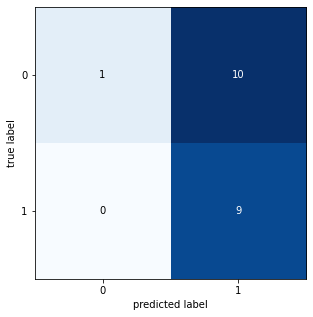

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



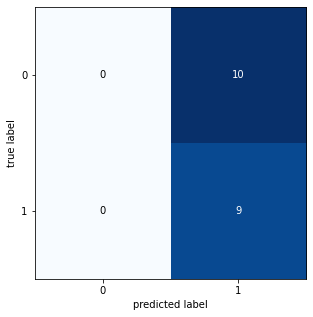

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



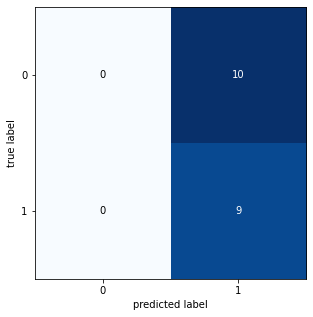

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



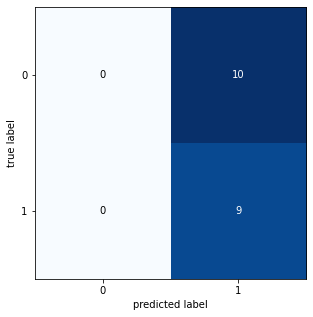

avg accuraccy Breast Cancer =  0.4842105263157895
avg F1_Score Breast Cancer =  0.3404761904761905
max accuraccy Breast Cancer =  0.5
max F1_Score Breast Cancer =  0.40476190476190477
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.93554499499987
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

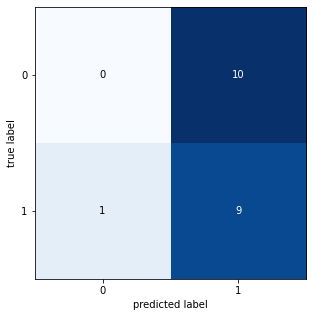

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


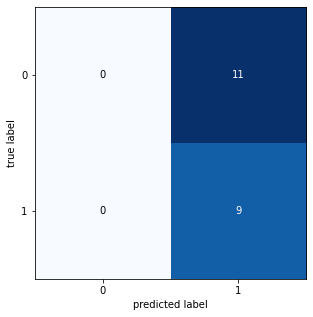

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



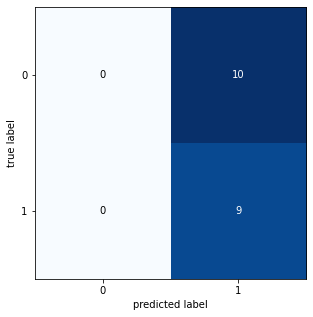

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



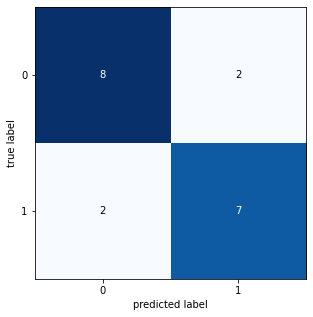

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



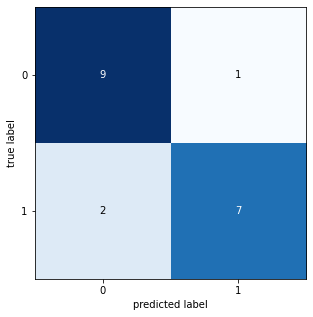

avg accuraccy Breast Cancer =  0.6010526315789473
avg F1_Score Breast Cancer =  0.5142686499887311
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.7975176430009
gene : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

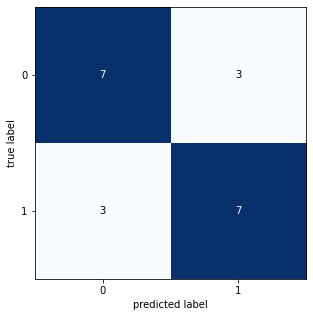

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


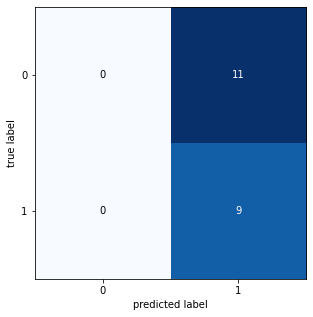

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.4242424242424242
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.50      1.00      0.67         9

    accuracy                           0.53        19
   macro avg       0.75      0.55      0.42        19
weighted avg       0.76      0.53      0.41        19



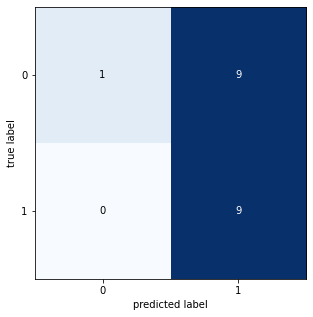

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



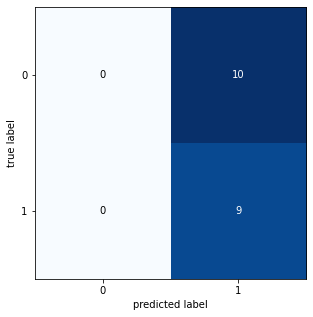

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



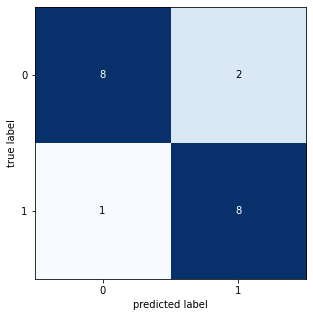

avg accuraccy Breast Cancer =  0.598421052631579
avg F1_Score Breast Cancer =  0.5196242172830194
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8421052631578948
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.546212150999054
gene : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

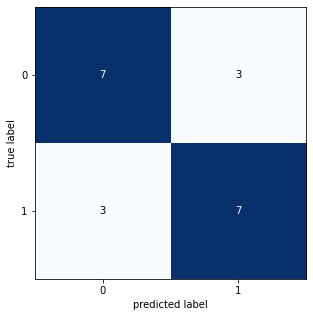

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



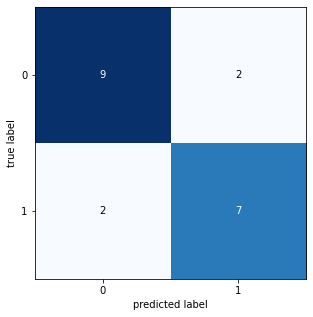

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


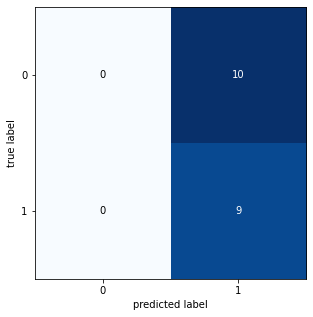

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



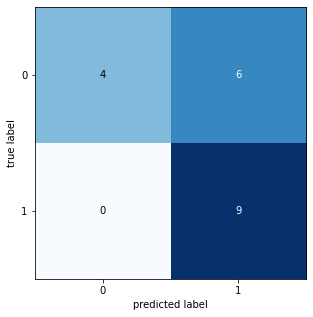

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



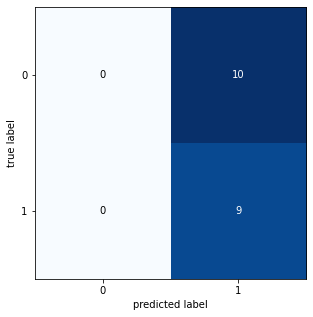

avg accuraccy Breast Cancer =  0.6263157894736843
avg F1_Score Breast Cancer =  0.5603102453102453
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.090786943999774
gen terbaik : [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.6964646270407477  || Akurasi terbaik : 0.7305263157894737  || jumlah fitur : 56

Running Time:  1981.1757265450005


In [14]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 3)

Generation : 0
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00

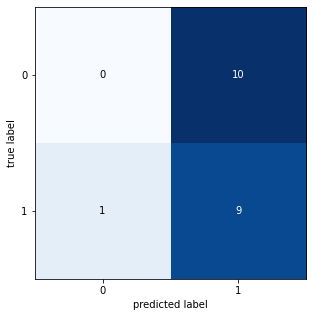

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



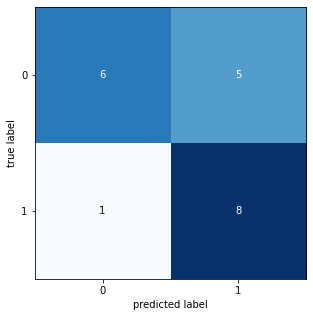

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



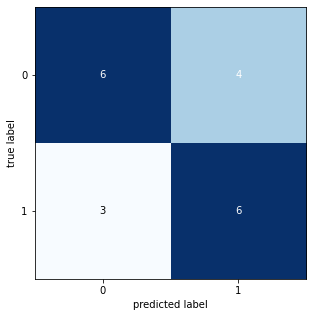

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



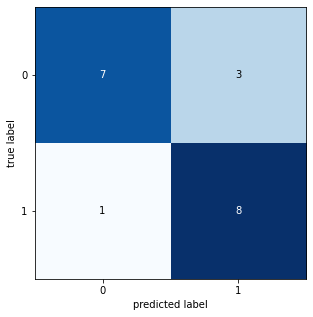

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



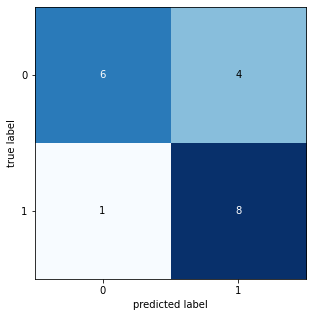

avg accuraccy Breast Cancer =  0.661578947368421
avg F1_Score Breast Cancer =  0.6323351836472366
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.54520250600035
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

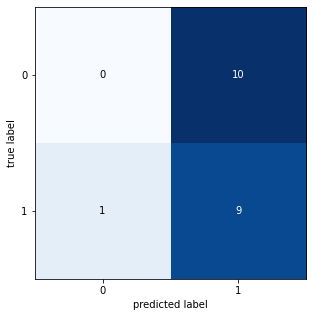

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.3548387096774194
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


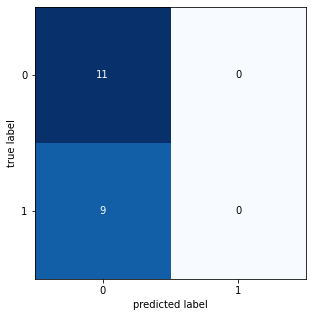

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



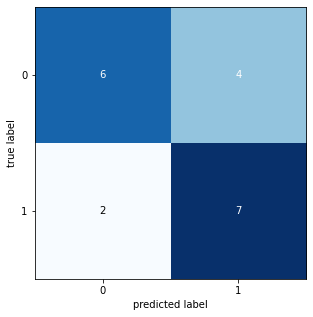

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



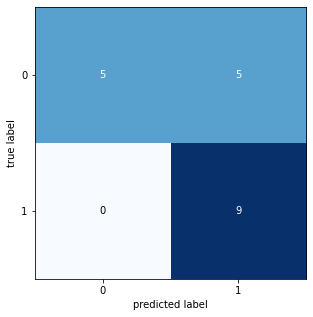

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



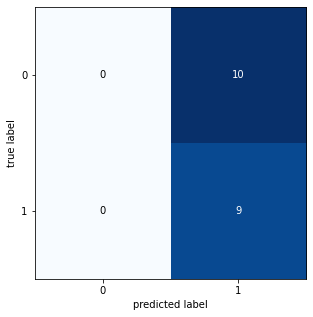

avg accuraccy Breast Cancer =  0.5789473684210527
avg F1_Score Breast Cancer =  0.4789166246369903
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7246376811594203
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.355717829999776
gene : [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


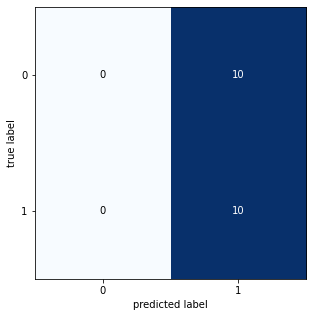

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



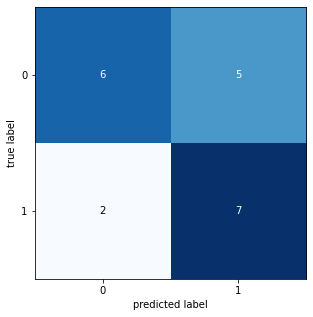

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



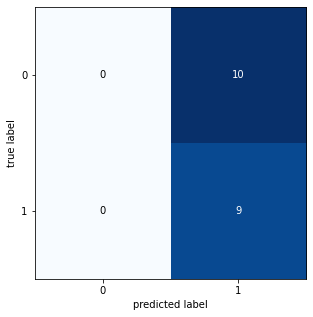

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



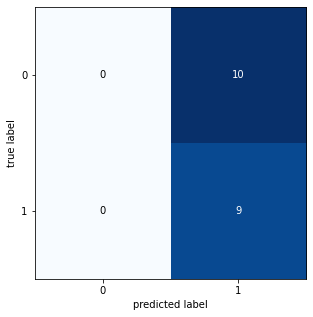

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



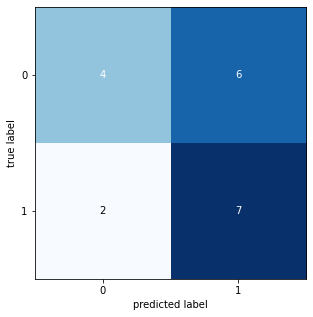

avg accuraccy Breast Cancer =  0.5352631578947368
avg F1_Score Breast Cancer =  0.43869902027796764
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6491228070175439
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.64186926500042
gene : [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


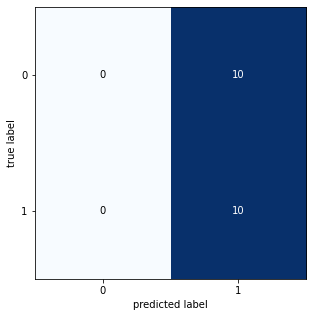

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



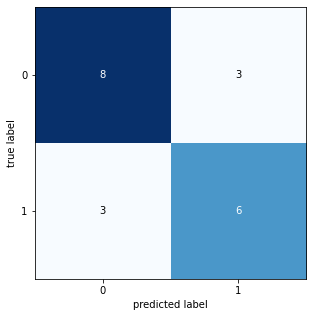

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



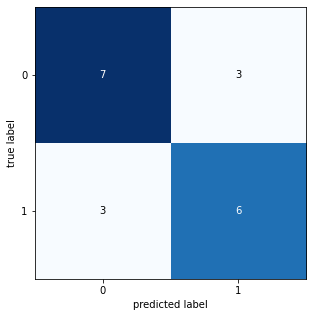

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



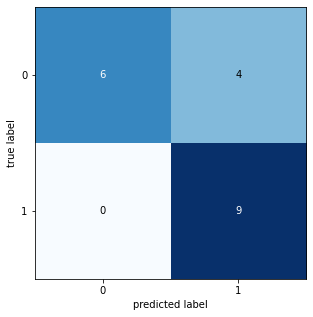

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



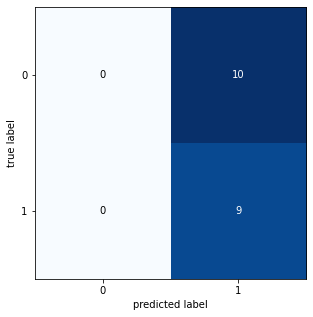

avg accuraccy Breast Cancer =  0.6294736842105264
avg F1_Score Breast Cancer =  0.5638311688311688
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.99723404299948
gene : [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


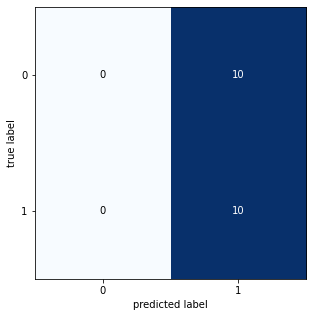

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



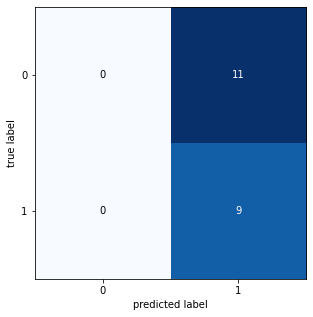

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.4242424242424242
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.50      1.00      0.67         9

    accuracy                           0.53        19
   macro avg       0.75      0.55      0.42        19
weighted avg       0.76      0.53      0.41        19



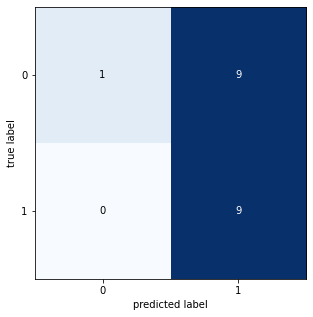

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



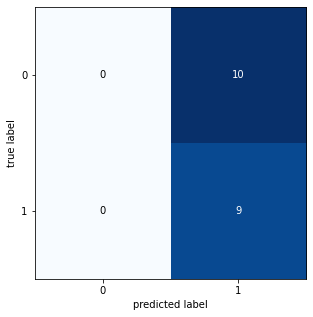

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



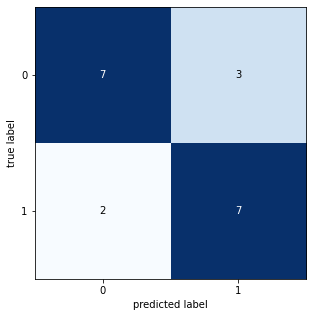

avg accuraccy Breast Cancer =  0.5373684210526315
avg F1_Score Breast Cancer =  0.42523825237073876
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.715716586999406
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

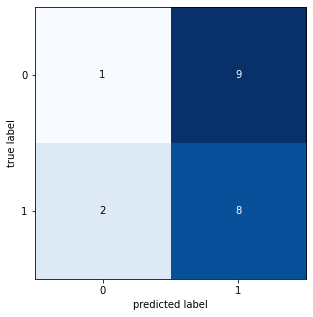

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


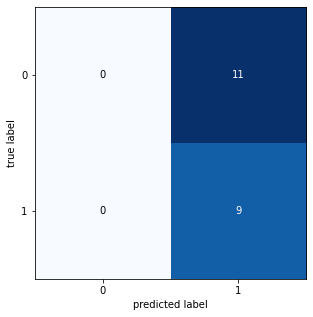

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



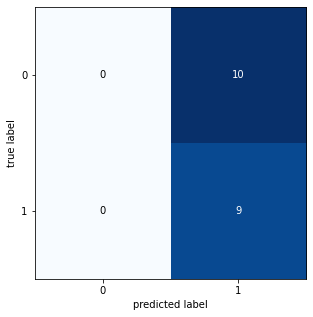

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.4242424242424242
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.50      1.00      0.67         9

    accuracy                           0.53        19
   macro avg       0.75      0.55      0.42        19
weighted avg       0.76      0.53      0.41        19



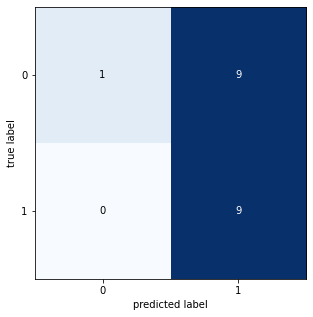

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



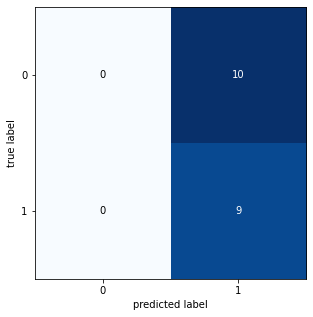

avg accuraccy Breast Cancer =  0.4747368421052632
avg F1_Score Breast Cancer =  0.3501327535810294
max accuraccy Breast Cancer =  0.5263157894736842
max F1_Score Breast Cancer =  0.4242424242424242
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.1099916710009
gene : [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

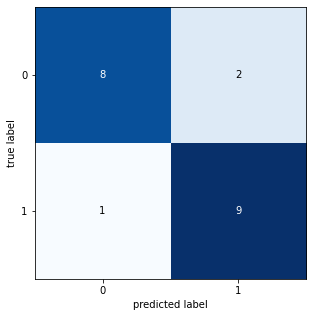

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


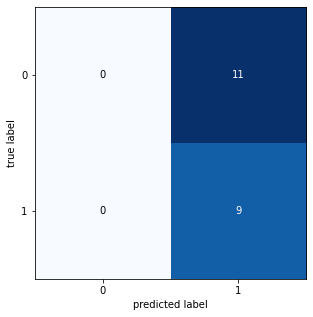

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



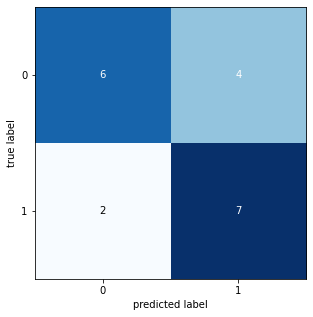

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



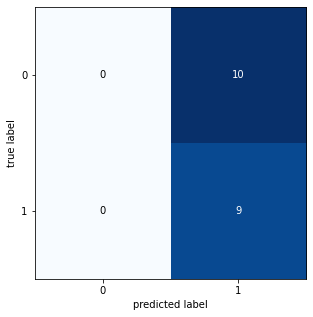

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



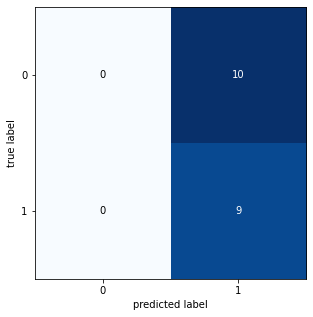

avg accuraccy Breast Cancer =  0.5863157894736843
avg F1_Score Breast Cancer =  0.49723187278541187
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.091473456999665
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

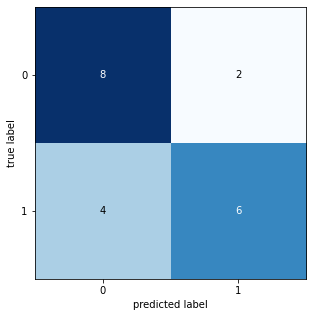

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


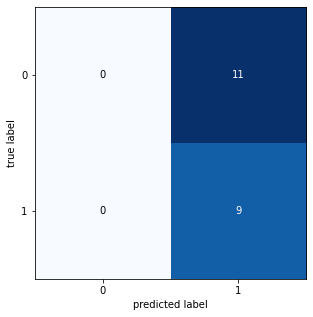

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



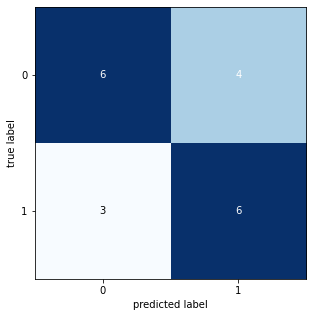

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



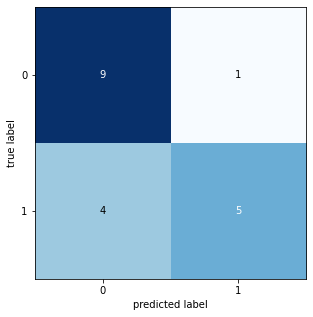

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



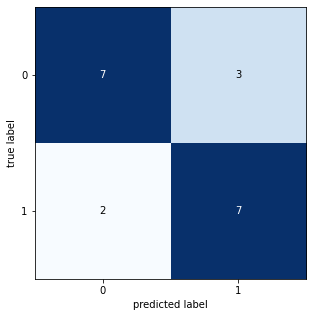

avg accuraccy Breast Cancer =  0.6510526315789473
avg F1_Score Breast Cancer =  0.6200746516693805
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7368421052631577
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.158510450000904
gene : [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

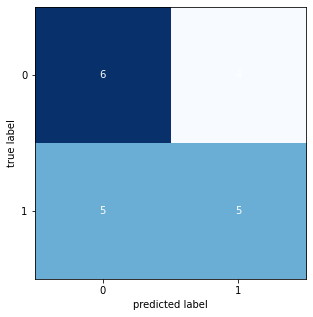

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



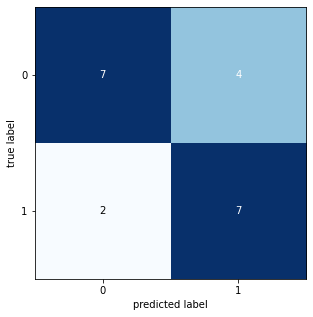

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



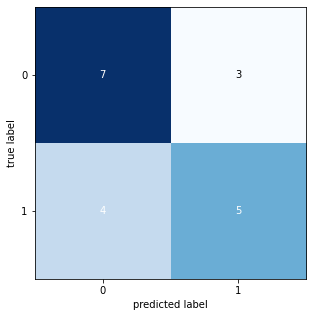

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



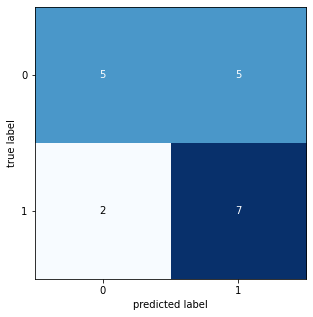

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


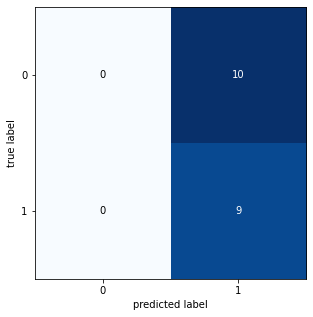

avg accuraccy Breast Cancer =  0.5973684210526315
avg F1_Score Breast Cancer =  0.5650405425328027
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.7000000000000001
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.72341300500011
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

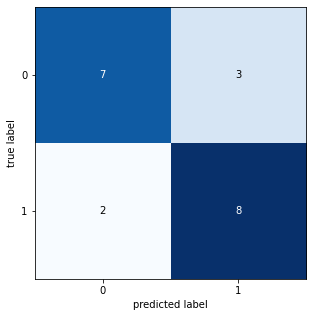

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


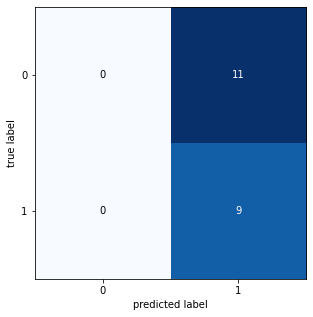

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



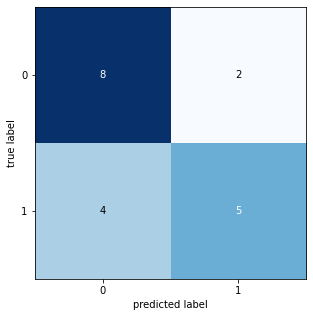

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.60      1.00      0.75         9

    accuracy                           0.68        19
   macro avg       0.80      0.70      0.66        19
weighted avg       0.81      0.68      0.66        19



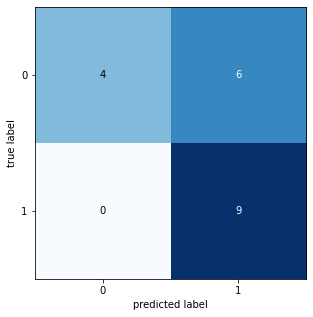

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



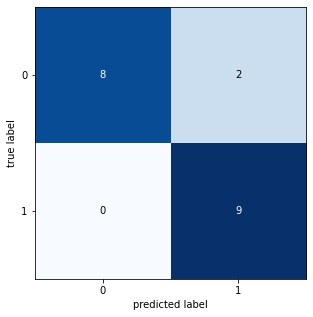

avg accuraccy Breast Cancer =  0.6926315789473685
avg F1_Score Breast Cancer =  0.6582026709930521
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.978714480001145
gen terbaik : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.6582026709930521  || Akurasi terbaik : 0.6926315789473685  || jumlah fitur : 59

Generation : 1
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


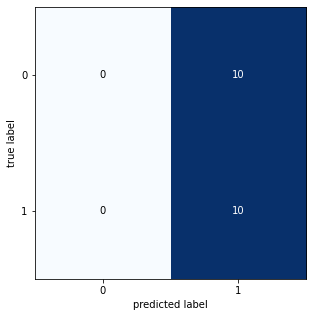

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.75      1.00      0.86         9

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



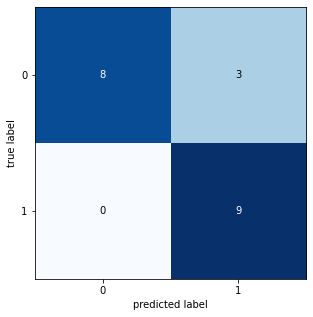

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



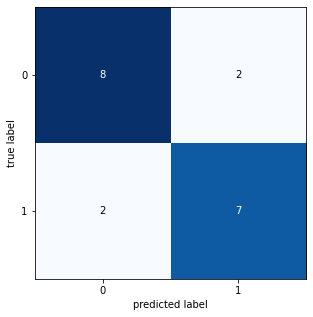

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



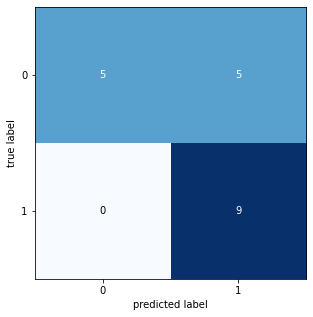

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



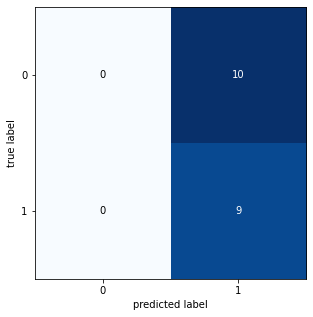

avg accuraccy Breast Cancer =  0.67
avg F1_Score Breast Cancer =  0.603582506992118
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.849624060150376
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.074131117000434
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


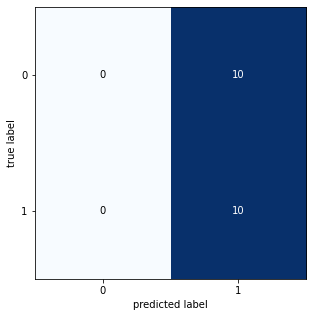

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



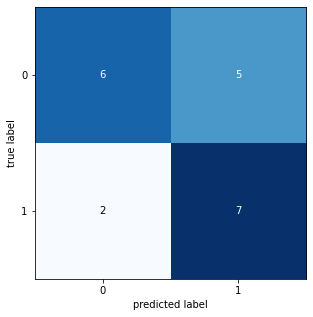

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



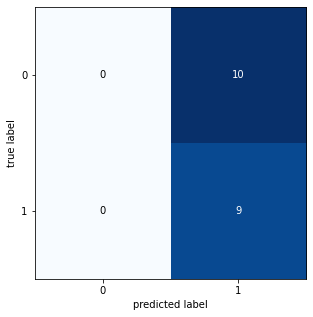

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



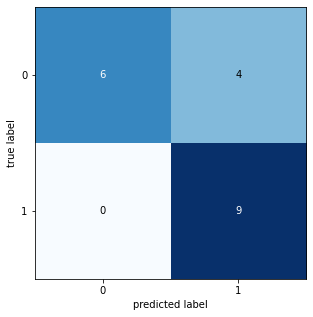

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



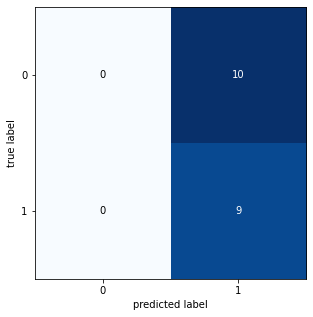

avg accuraccy Breast Cancer =  0.5773684210526315
avg F1_Score Breast Cancer =  0.4818808384597858
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.9261864580003
gene : [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 

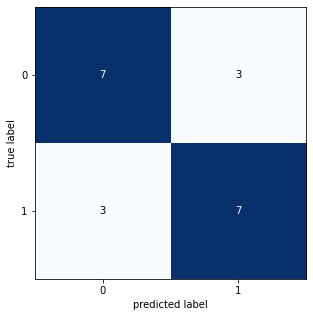

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


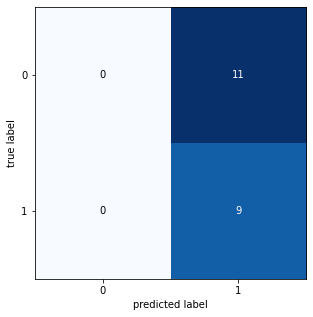

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



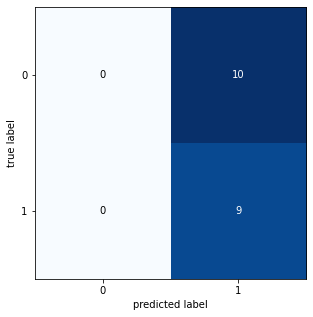

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



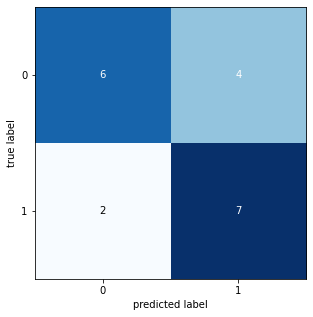

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



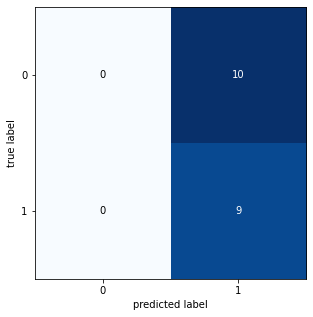

avg accuraccy Breast Cancer =  0.5563157894736842
avg F1_Score Breast Cancer =  0.46730706075533657
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.7
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.03920172399921
gene : [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 

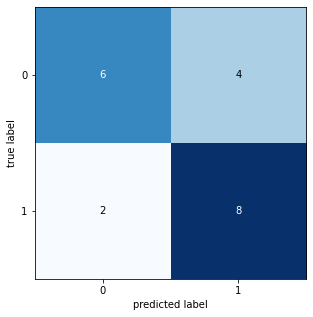

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


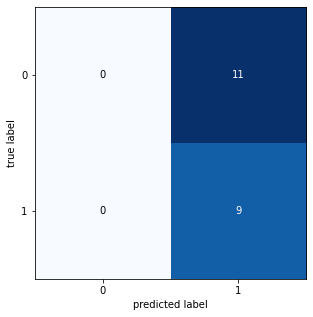

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



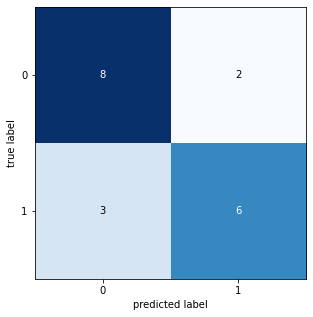

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



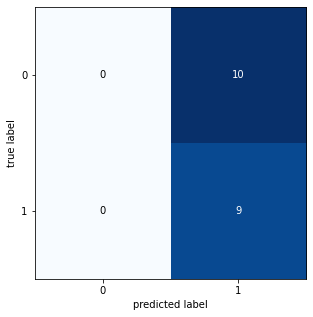

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



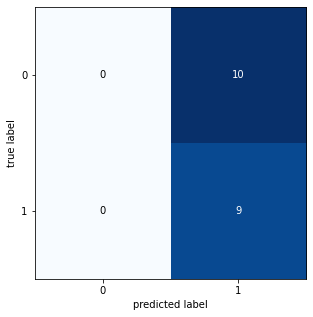

avg accuraccy Breast Cancer =  0.5668421052631579
avg F1_Score Breast Cancer =  0.4768130449672032
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  42.23039806899942
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


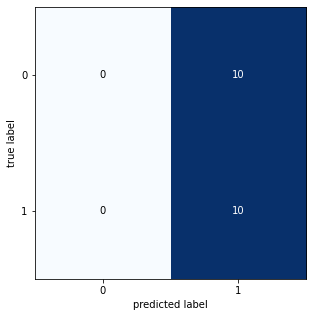

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



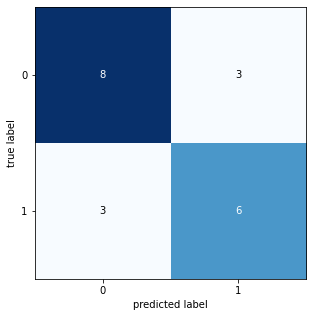

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



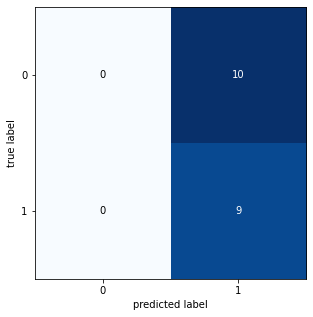

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.4242424242424242
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.50      1.00      0.67         9

    accuracy                           0.53        19
   macro avg       0.75      0.55      0.42        19
weighted avg       0.76      0.53      0.41        19



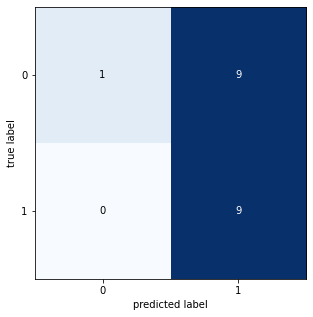

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



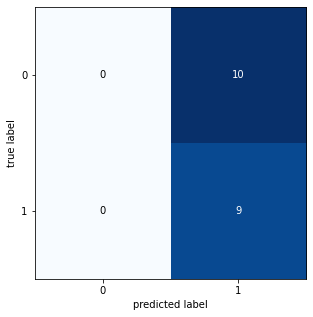

avg accuraccy Breast Cancer =  0.5347368421052632
avg F1_Score Breast Cancer =  0.41948051948051945
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.696969696969697
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.09944133799945
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

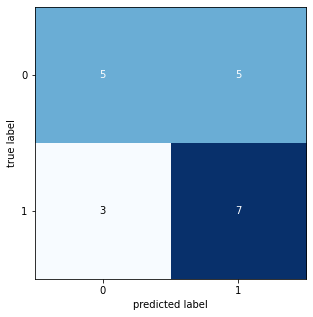

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


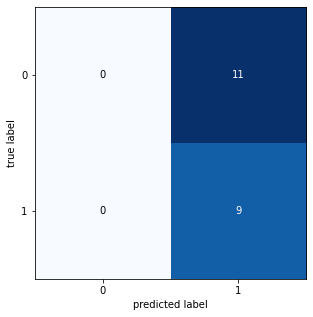

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



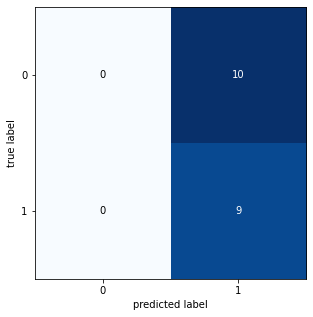

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



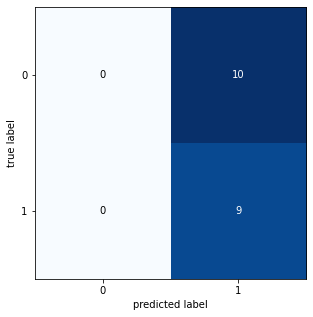

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



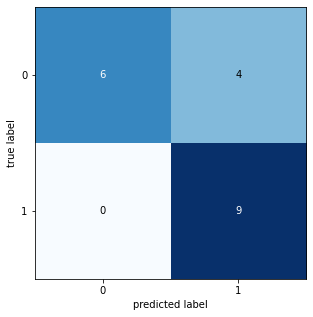

avg accuraccy Breast Cancer =  0.5573684210526315
avg F1_Score Breast Cancer =  0.466650495098771
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.784090909090909
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.89173327299977
gene : [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

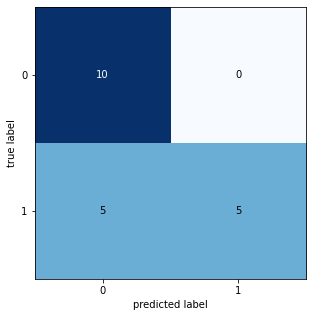

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



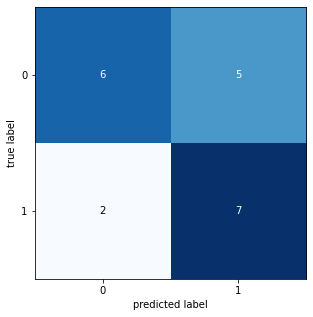

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



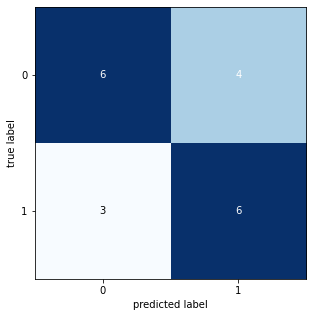

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


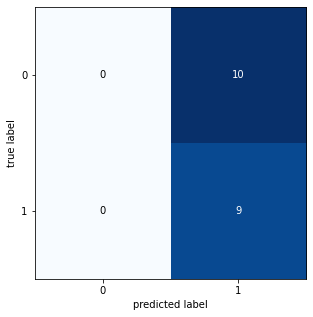

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



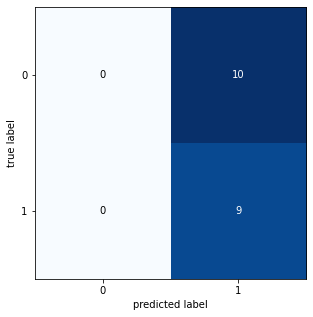

avg accuraccy Breast Cancer =  0.5957894736842105
avg F1_Score Breast Cancer =  0.5313784461152883
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7333333333333334
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.4585315839995
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

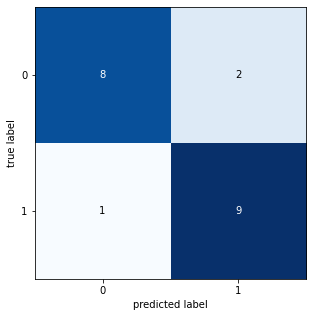

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



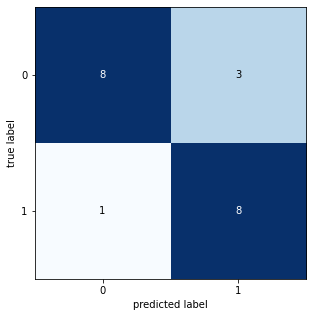

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



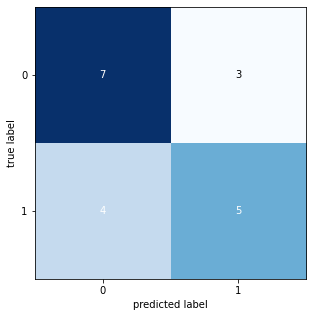

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



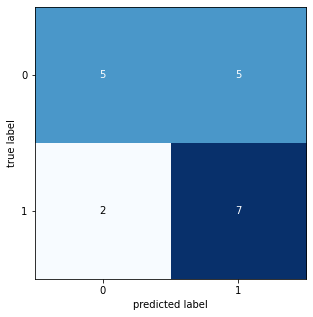

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



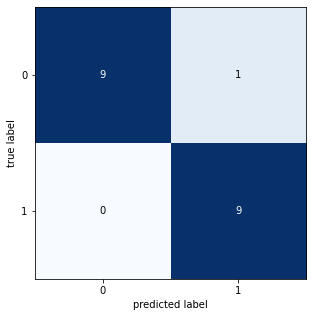

avg accuraccy Breast Cancer =  0.7721052631578946
avg F1_Score Breast Cancer =  0.7703788883974643
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9473684210526316
min accuraccy Breast Cancer =  0.631578947368421
min F1_Score Breast Cancer =  0.6274509803921569
Running Time:  38.3201209380004
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 

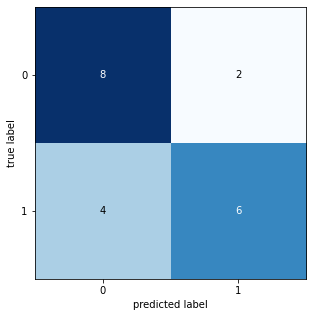

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



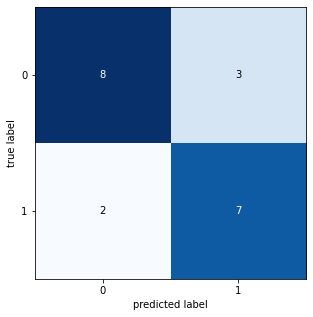

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



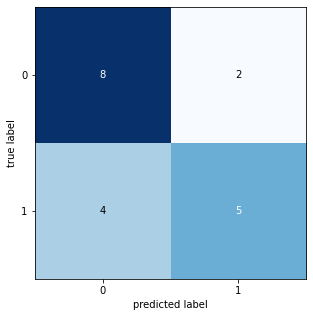

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


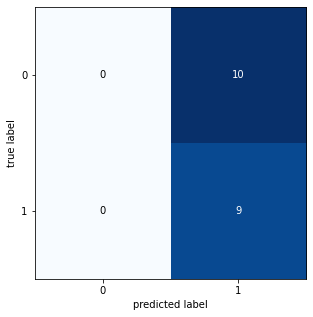

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8920454545454546
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.78      0.88         9

    accuracy                           0.89        19
   macro avg       0.92      0.89      0.89        19
weighted avg       0.91      0.89      0.89        19



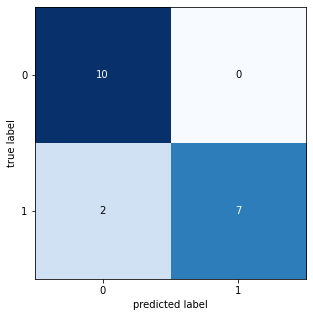

avg accuraccy Breast Cancer =  0.7005263157894738
avg F1_Score Breast Cancer =  0.6671907040328093
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8920454545454546
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.37465314200017
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

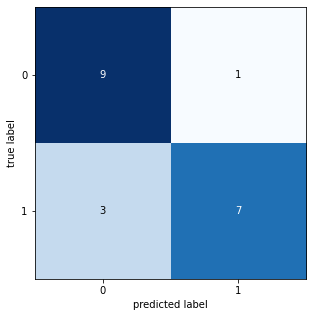

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



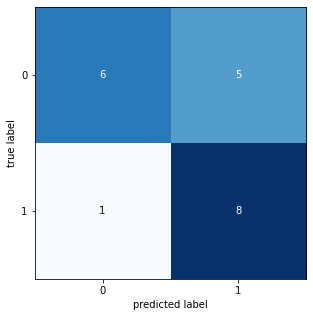

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



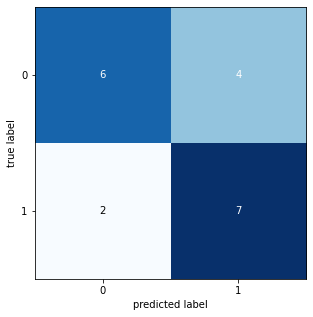

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



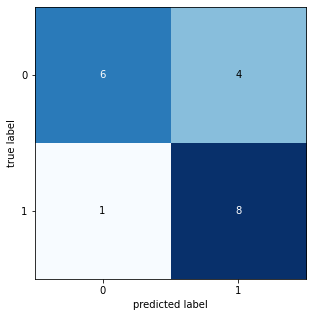

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


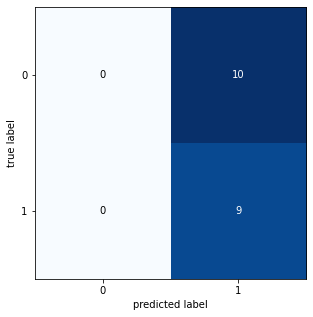

avg accuraccy Breast Cancer =  0.6789473684210526
avg F1_Score Breast Cancer =  0.6467209914268739
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.05546619400047
gen terbaik : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.7703788883974643  || Akurasi terbaik : 0.7721052631578946  || jumlah fitur : 59

Generation : 2
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 

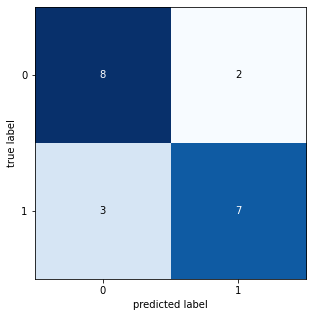

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


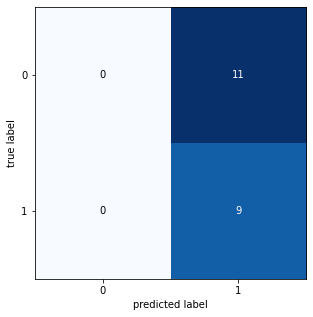

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



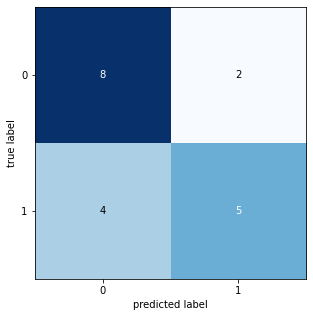

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



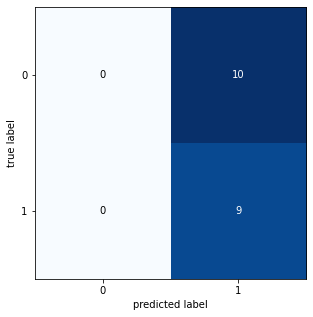

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



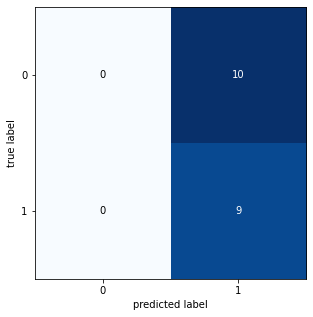

avg accuraccy Breast Cancer =  0.5663157894736843
avg F1_Score Breast Cancer =  0.4757423535327347
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  37.187806291000015
gene : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

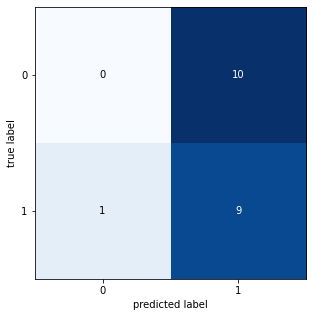

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



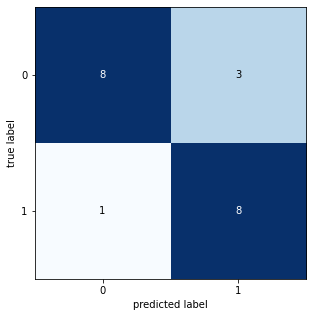

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


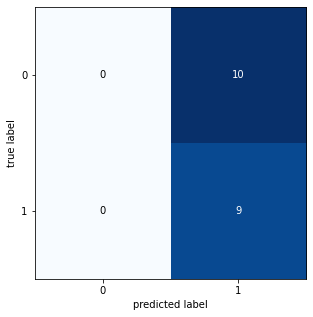

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



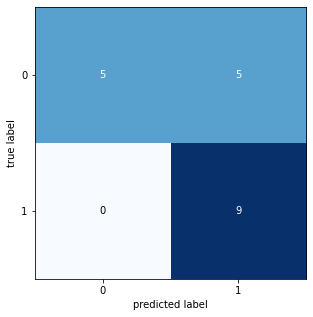

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



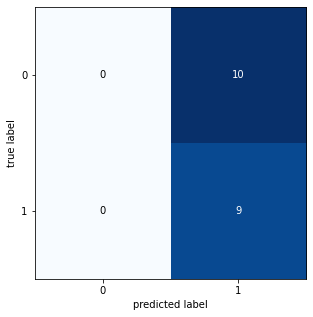

avg accuraccy Breast Cancer =  0.5868421052631578
avg F1_Score Breast Cancer =  0.4955679303205541
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7999999999999999
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.717802445000416
gene : [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


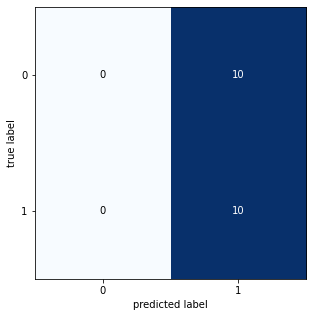

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



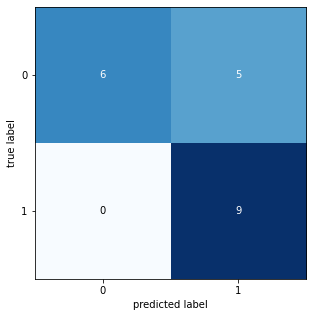

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



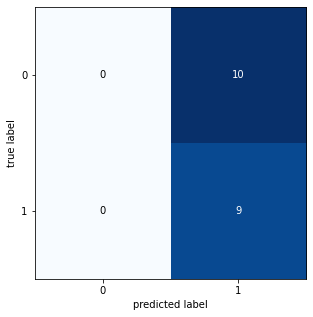

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



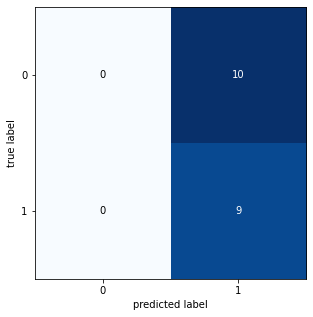

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



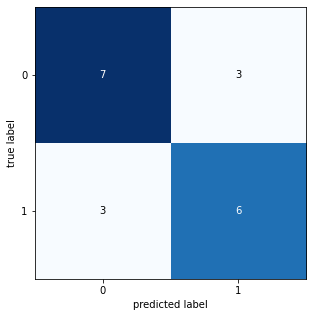

avg accuraccy Breast Cancer =  0.5763157894736841
avg F1_Score Breast Cancer =  0.4807538667640969
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966752
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.19427339699905
gene : [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

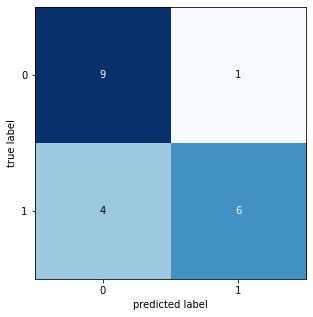

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


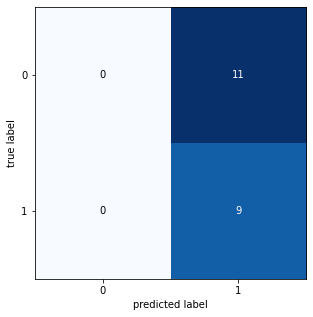

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5521885521885521
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       1.00      0.22      0.36         9

    accuracy                           0.63        19
   macro avg       0.79      0.61      0.55        19
weighted avg       0.78      0.63      0.56        19



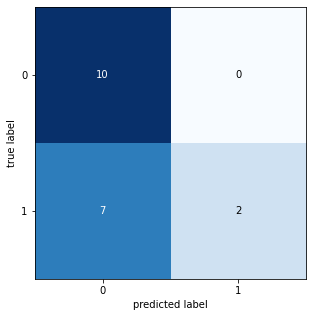

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



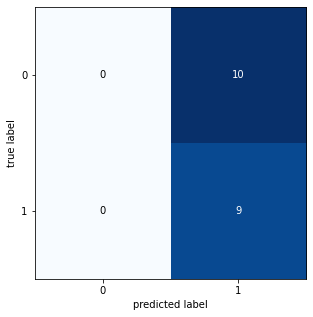

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.3448275862068966
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19



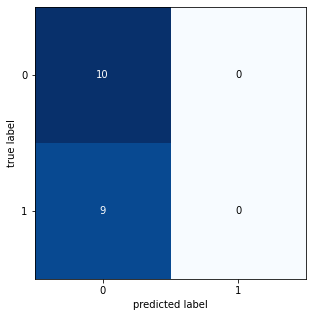

avg accuraccy Breast Cancer =  0.5663157894736842
avg F1_Score Breast Cancer =  0.4546070123413804
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7442455242966751
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.23547798599975
gene : [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

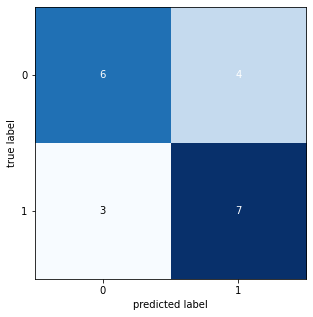

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7999999999999999
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.73      0.89      0.80         9

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



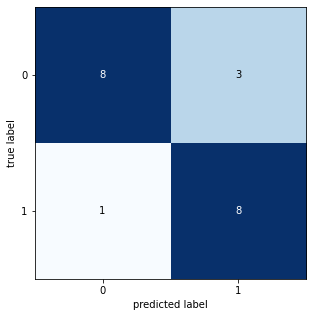

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


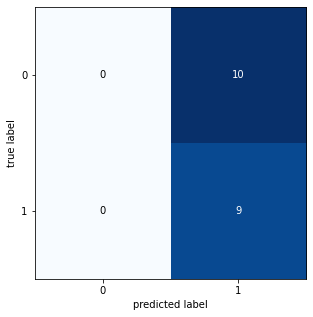

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



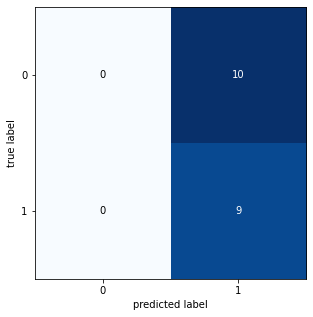

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



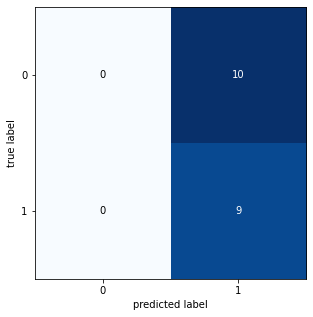

avg accuraccy Breast Cancer =  0.5742105263157895
avg F1_Score Breast Cancer =  0.48268170426065166
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.7999999999999999
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.90414477400009
gene : [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

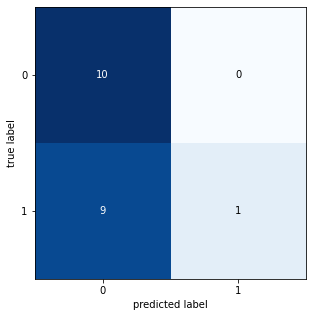

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


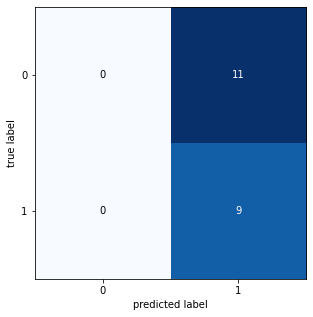

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



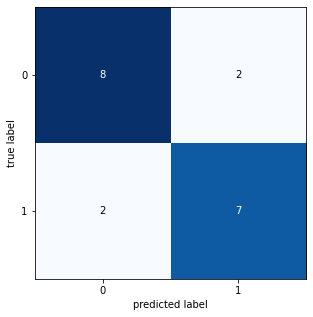

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



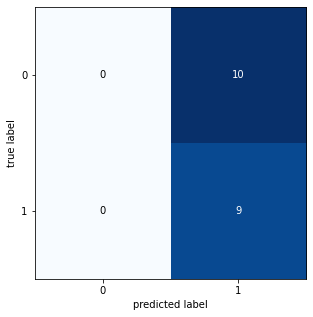

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9467787114845938
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.89      0.94         9

    accuracy                           0.95        19
   macro avg       0.95      0.94      0.95        19
weighted avg       0.95      0.95      0.95        19



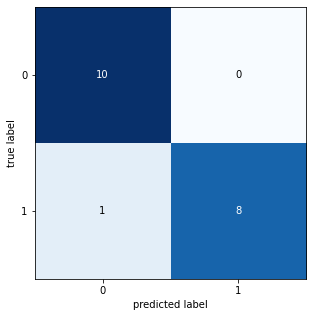

avg accuraccy Breast Cancer =  0.6421052631578947
avg F1_Score Breast Cancer =  0.5606355353008498
max accuraccy Breast Cancer =  0.9473684210526315
max F1_Score Breast Cancer =  0.9467787114845938
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.47127631600051
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


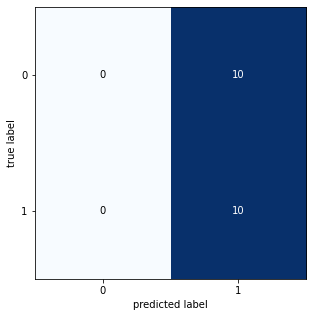

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



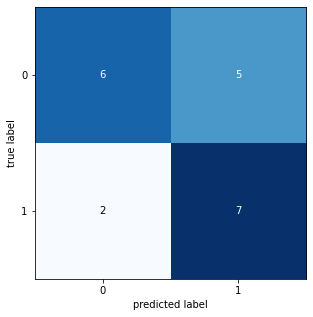

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



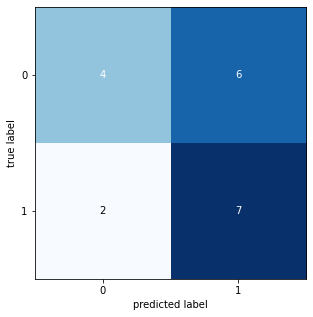

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



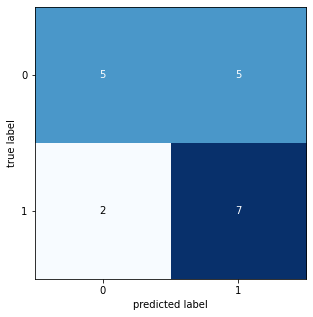

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



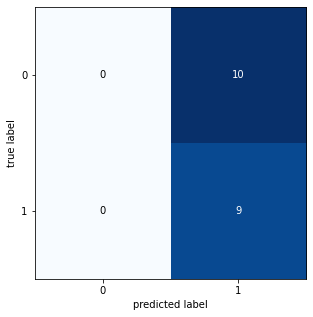

avg accuraccy Breast Cancer =  0.5668421052631579
avg F1_Score Breast Cancer =  0.4999035020706848
max accuraccy Breast Cancer =  0.65
max F1_Score Breast Cancer =  0.6491228070175439
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.21507916099836
gene : [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

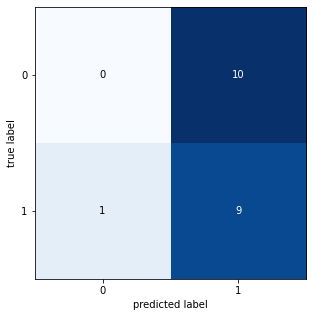

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


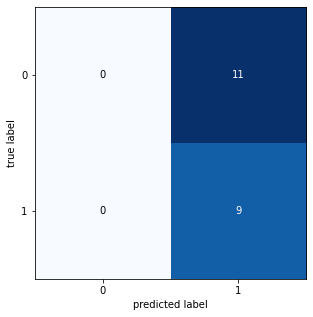

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



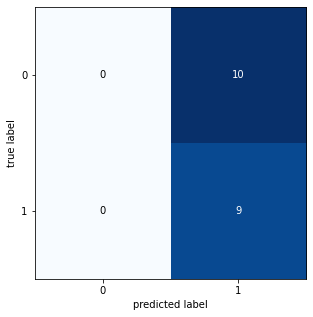

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



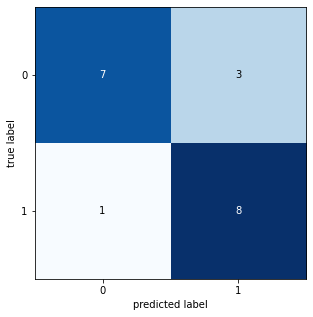

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



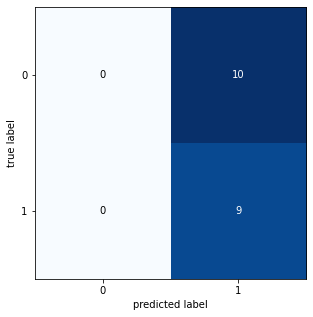

avg accuraccy Breast Cancer =  0.5273684210526316
avg F1_Score Breast Cancer =  0.41048713738368914
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.15523277600005
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

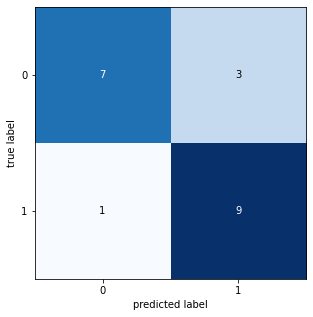

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


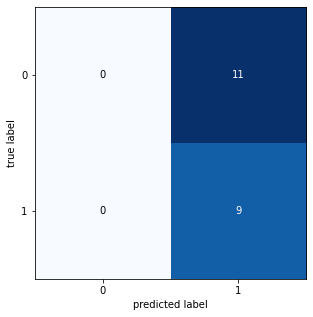

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



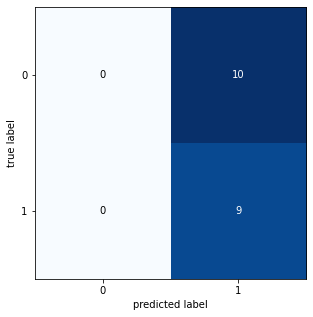

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



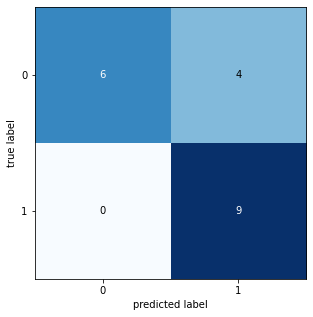

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



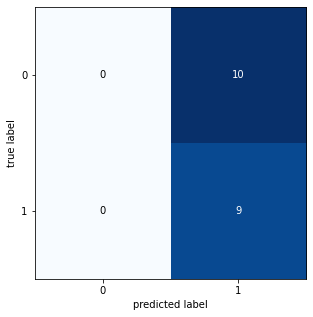

avg accuraccy Breast Cancer =  0.5973684210526315
avg F1_Score Breast Cancer =  0.5070545355028113
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.154153776000385
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

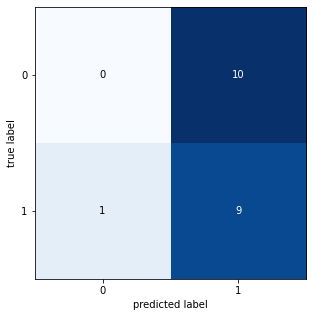

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



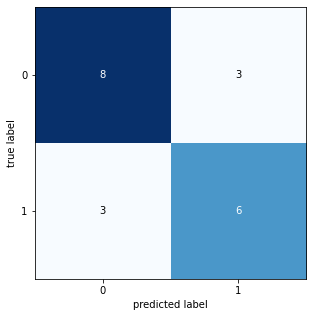

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


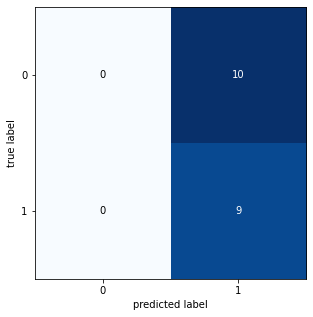

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



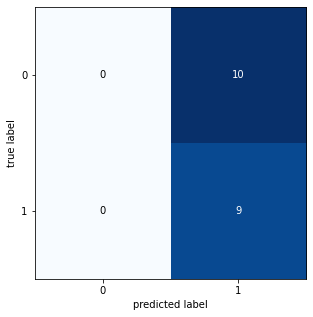

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



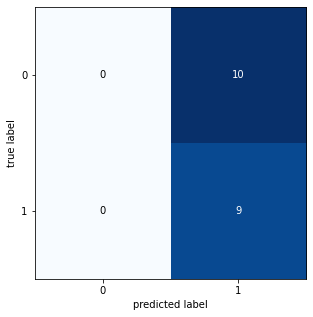

avg accuraccy Breast Cancer =  0.5142105263157895
avg F1_Score Breast Cancer =  0.39432004776832363
max accuraccy Breast Cancer =  0.7
max F1_Score Breast Cancer =  0.696969696969697
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.387982811000256
gen terbaik : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.7703788883974643  || Akurasi terbaik : 0.7721052631578946  || jumlah fitur : 59

Generation : 3
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


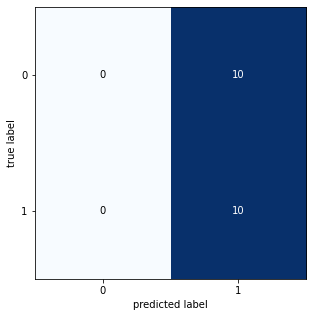

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



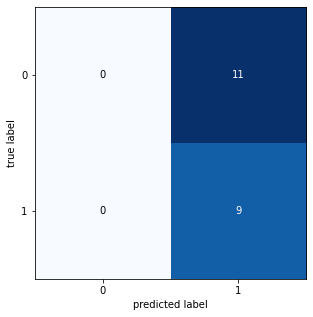

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



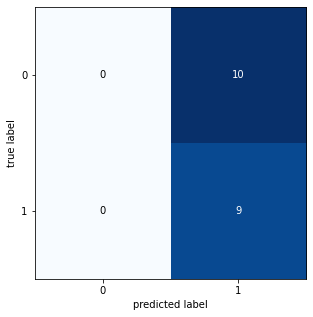

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



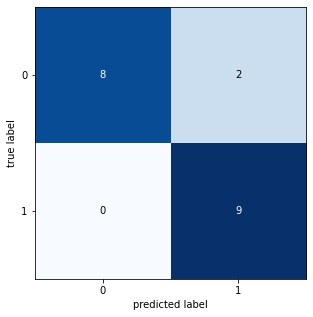

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



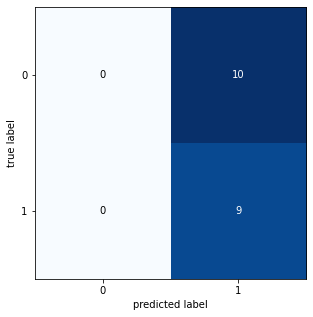

avg accuraccy Breast Cancer =  0.5584210526315789
avg F1_Score Breast Cancer =  0.4361959496442256
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.146317183000065
gene : [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


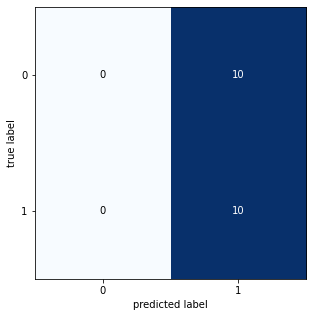

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



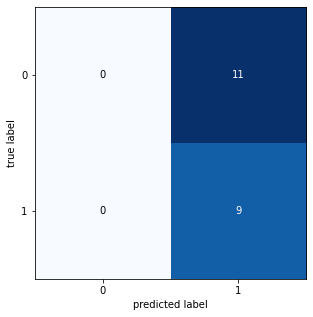

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



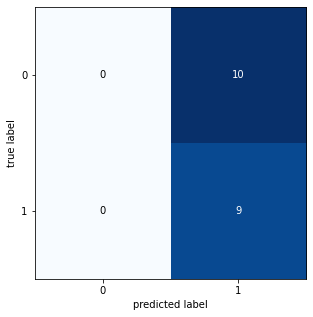

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



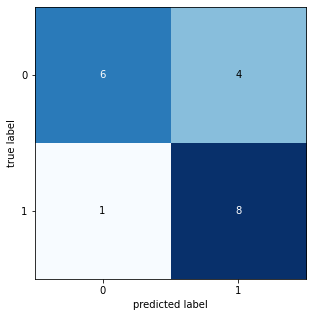

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



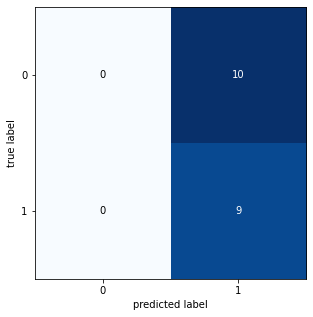

avg accuraccy Breast Cancer =  0.5268421052631579
avg F1_Score Breast Cancer =  0.4040857722399305
max accuraccy Breast Cancer =  0.7368421052631579
max F1_Score Breast Cancer =  0.7338935574229692
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  38.52362114099924
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

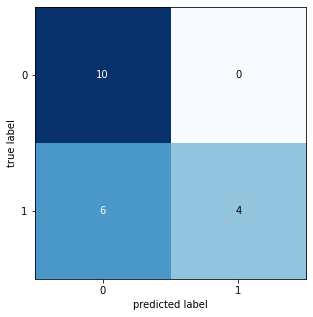

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



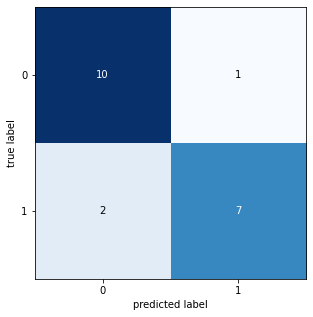

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



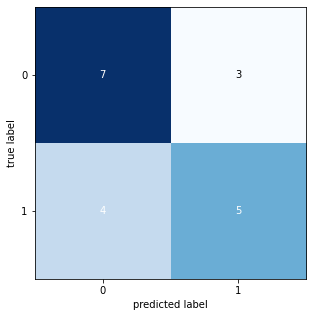

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


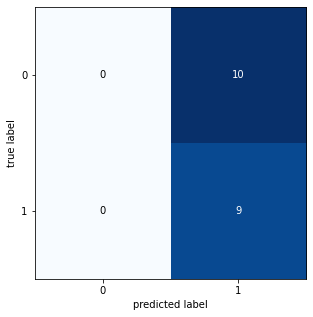

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



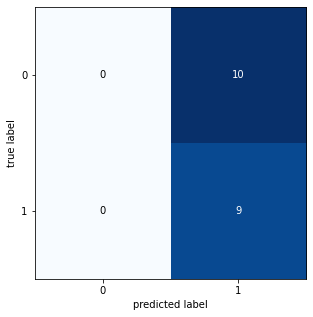

avg accuraccy Breast Cancer =  0.6257894736842106
avg F1_Score Breast Cancer =  0.5574370216313952
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.82783095100058
gene : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

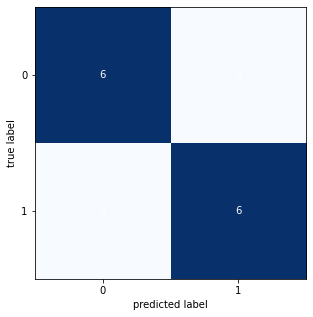

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



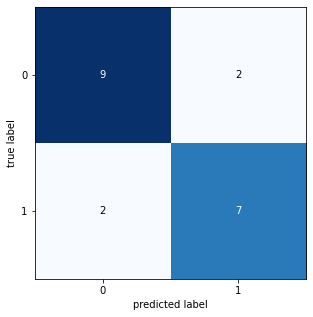

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



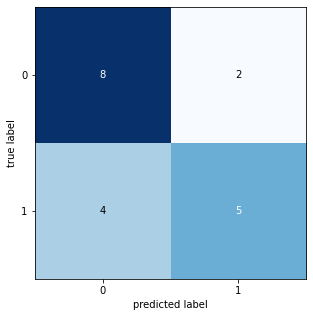

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


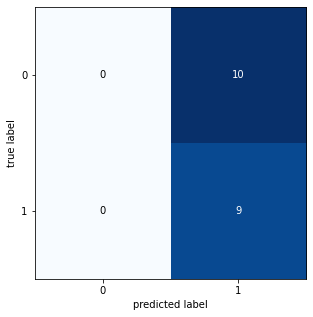

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



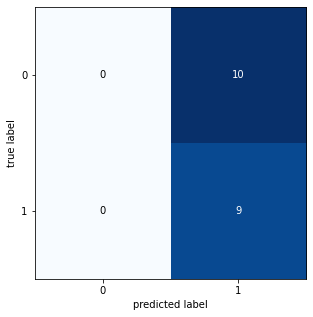

avg accuraccy Breast Cancer =  0.6063157894736843
avg F1_Score Breast Cancer =  0.543394660894661
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.454777278999245
gene : [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


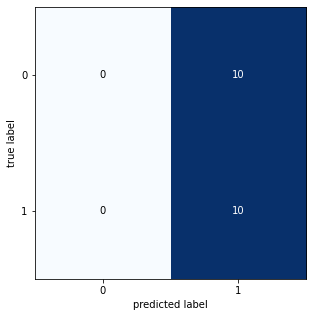

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



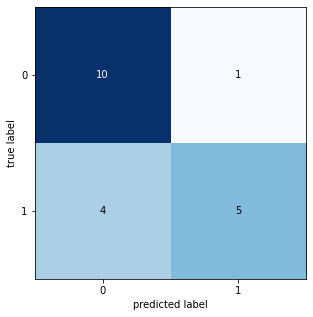

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



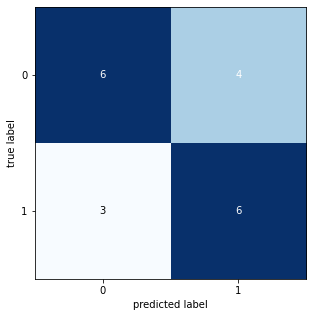

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5128205128205128
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.67      0.22      0.33         9

    accuracy                           0.58        19
   macro avg       0.61      0.56      0.51        19
weighted avg       0.61      0.58      0.52        19



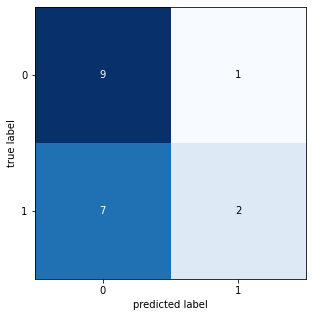

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



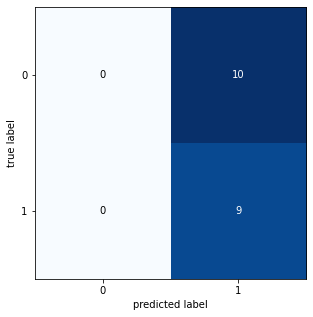

avg accuraccy Breast Cancer =  0.5868421052631578
avg F1_Score Breast Cancer =  0.5064989396568345
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7333333333333334
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  38.83597921399996
gene : [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

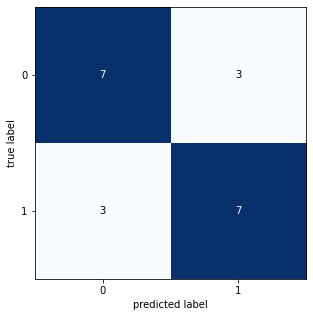

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


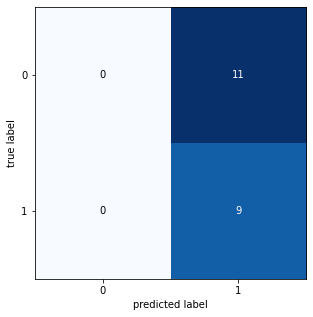

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



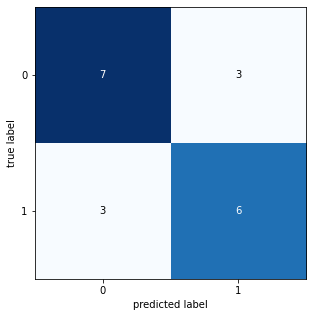

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



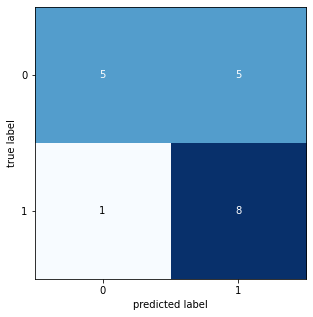

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



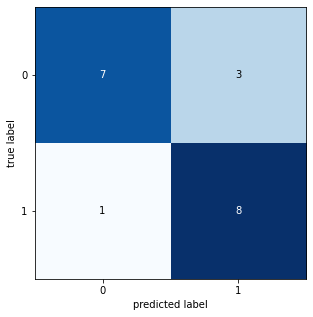

avg accuraccy Breast Cancer =  0.6615789473684209
avg F1_Score Breast Cancer =  0.6317406826889586
max accuraccy Breast Cancer =  0.7894736842105263
max F1_Score Breast Cancer =  0.7888888888888888
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.8166745439994
gene : [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

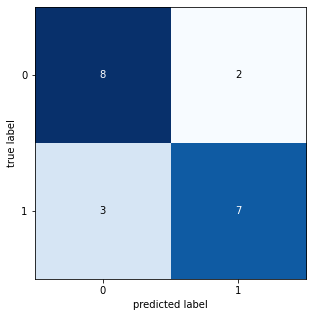

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



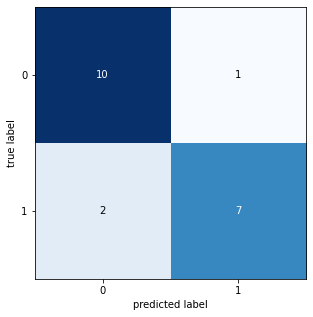

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


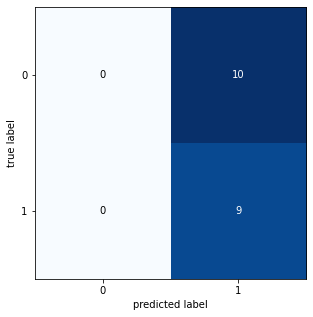

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



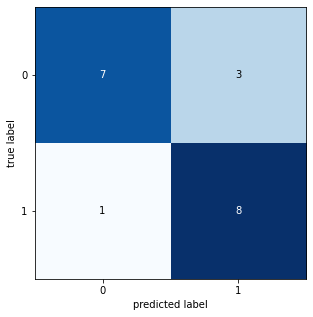

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



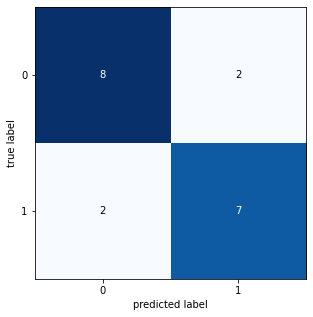

avg accuraccy Breast Cancer =  0.7305263157894737
avg F1_Score Breast Cancer =  0.6990254194736629
max accuraccy Breast Cancer =  0.85
max F1_Score Breast Cancer =  0.8465473145780051
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.44299410500025
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

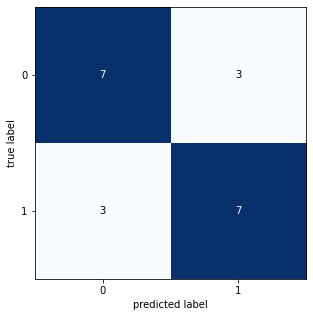

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



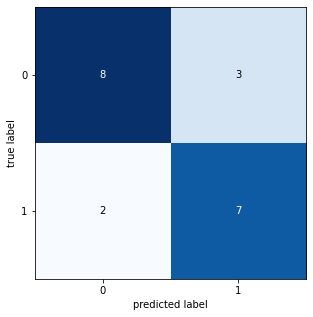

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


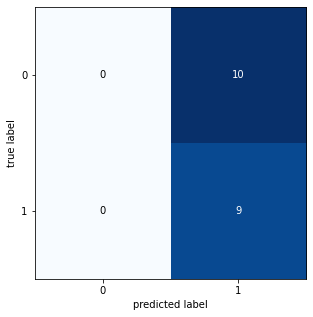

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



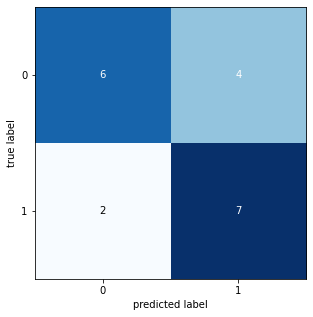

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



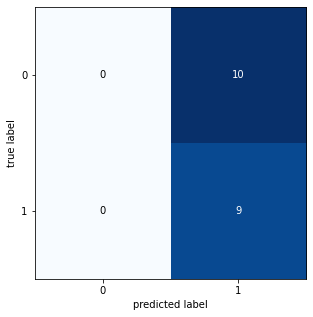

avg accuraccy Breast Cancer =  0.6163157894736842
avg F1_Score Breast Cancer =  0.5551127819548872
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.206096892999994
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

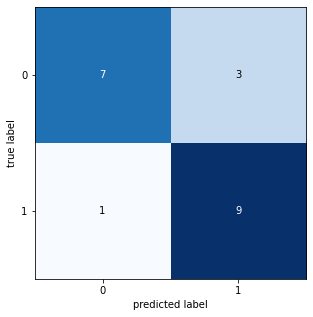

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



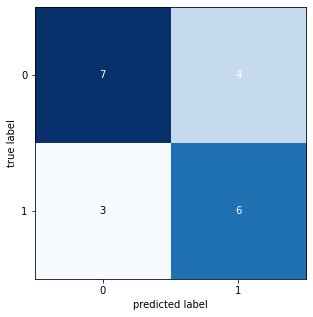

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


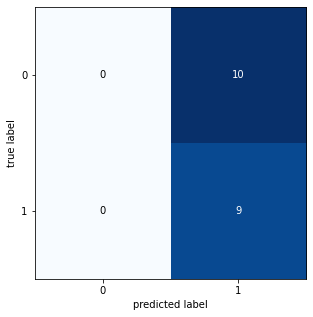

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



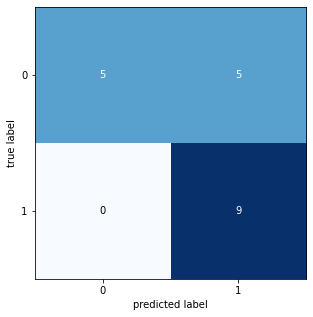

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



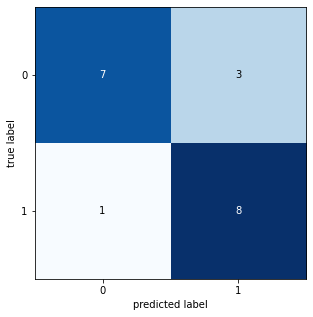

avg accuraccy Breast Cancer =  0.6900000000000001
avg F1_Score Breast Cancer =  0.6564115492948445
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  37.30489939799918
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


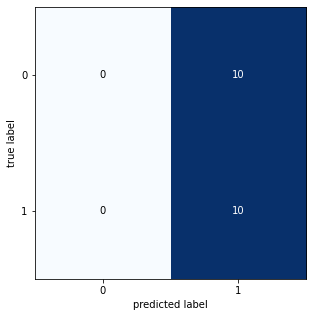

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



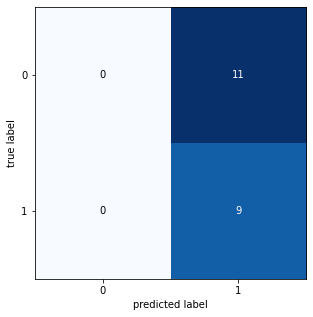

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



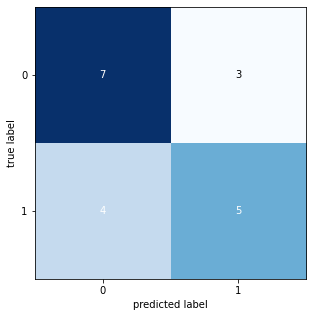

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



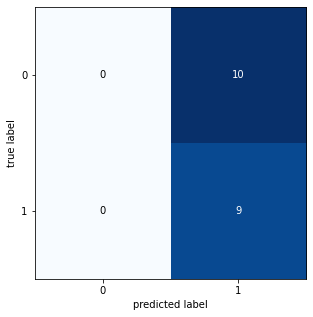

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



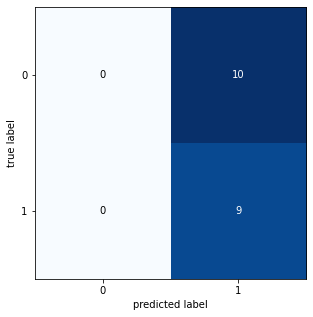

avg accuraccy Breast Cancer =  0.5057894736842106
avg F1_Score Breast Cancer =  0.382797256833768
max accuraccy Breast Cancer =  0.631578947368421
max F1_Score Breast Cancer =  0.6274509803921569
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.47416447999967
gen terbaik : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.7703788883974643  || Akurasi terbaik : 0.7721052631578946  || jumlah fitur : 59

Generation : 4
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


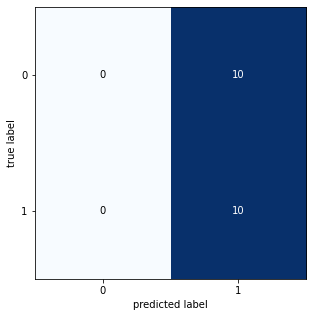

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.75      1.00      0.86         9

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



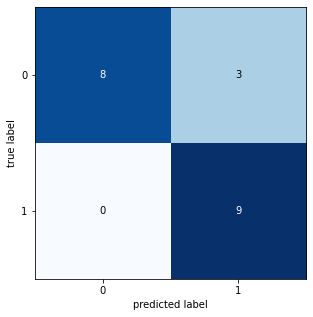

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



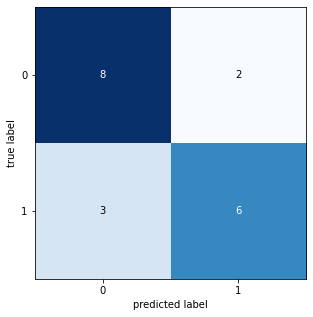

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



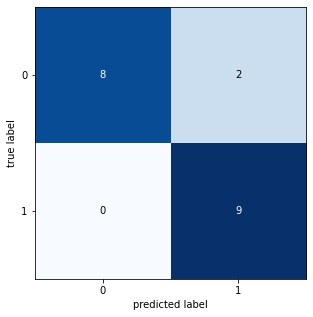

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



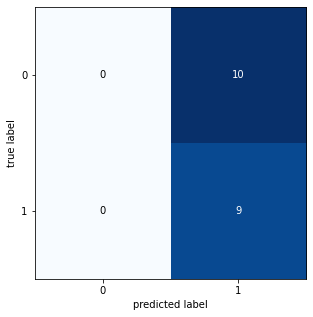

avg accuraccy Breast Cancer =  0.6910526315789475
avg F1_Score Breast Cancer =  0.6265447933559389
max accuraccy Breast Cancer =  0.8947368421052632
max F1_Score Breast Cancer =  0.8944444444444445
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.19938340399858
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


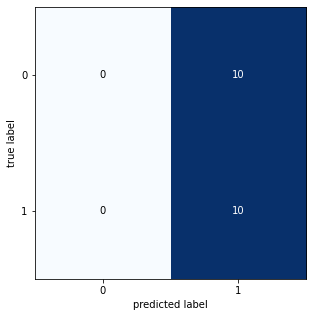

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



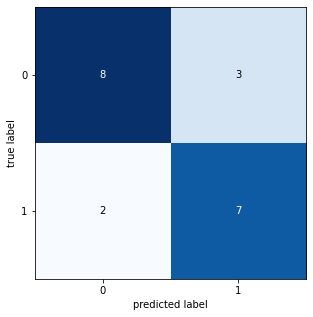

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



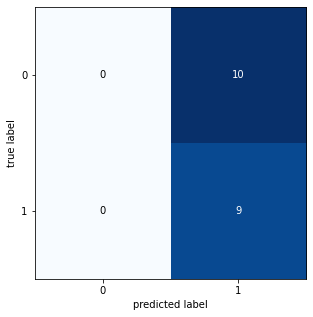

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



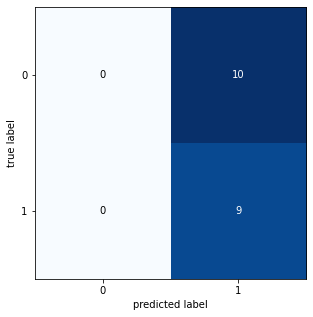

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



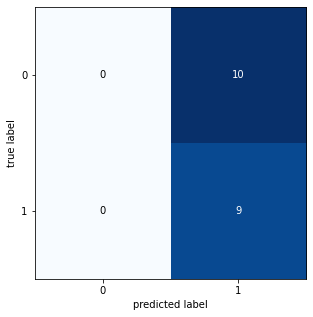

avg accuraccy Breast Cancer =  0.5342105263157895
avg F1_Score Breast Cancer =  0.40939849624060154
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.40911789999882
gene : [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

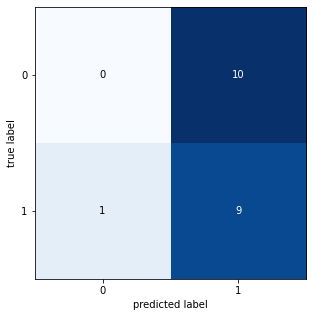

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.57      0.89      0.70         9

    accuracy                           0.65        20
   macro avg       0.70      0.67      0.64        20
weighted avg       0.72      0.65      0.64        20



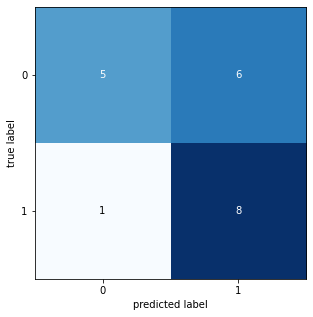

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


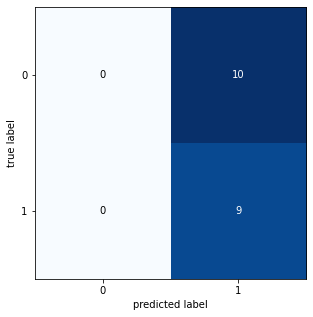

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



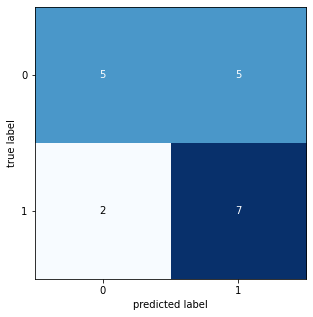

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



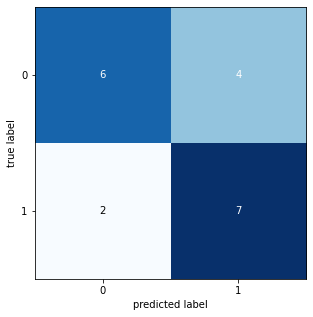

avg accuraccy Breast Cancer =  0.5778947368421052
avg F1_Score Breast Cancer =  0.5169002893511228
max accuraccy Breast Cancer =  0.6842105263157895
max F1_Score Breast Cancer =  0.6833333333333333
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  40.463537896999696
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

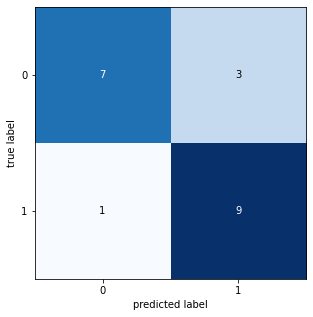

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


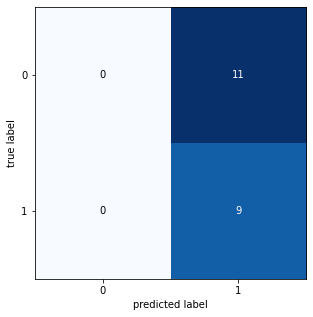

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



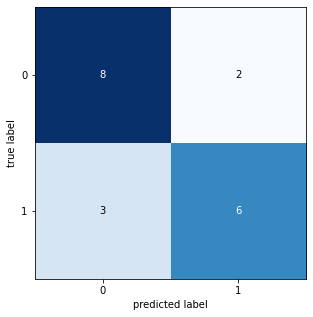

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



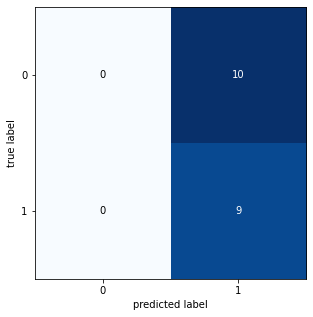

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



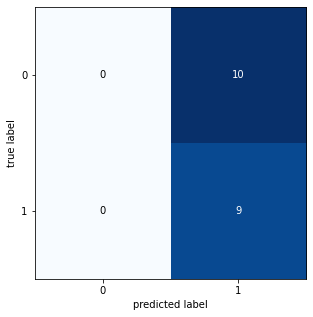

avg accuraccy Breast Cancer =  0.5868421052631579
avg F1_Score Breast Cancer =  0.49701506516922345
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.247750174999965
gene : [0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


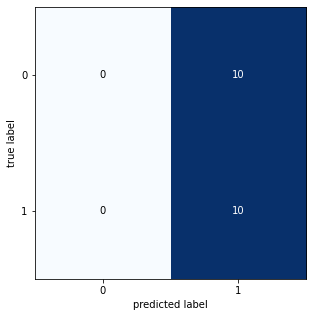

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



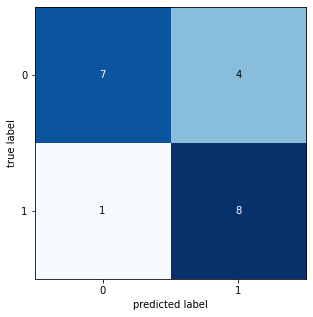

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



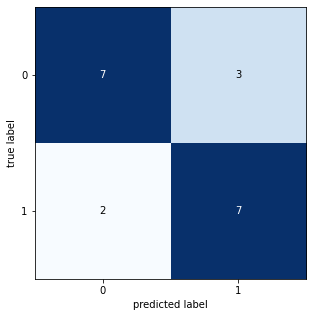

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



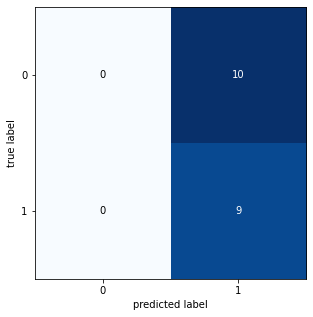

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



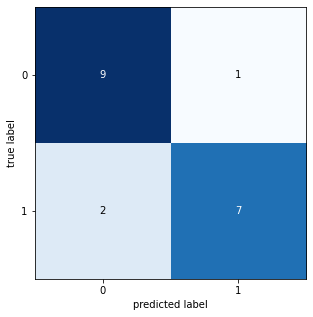

avg accuraccy Breast Cancer =  0.6605263157894737
avg F1_Score Breast Cancer =  0.5962627156125608
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537816
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  40.04606277700077
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


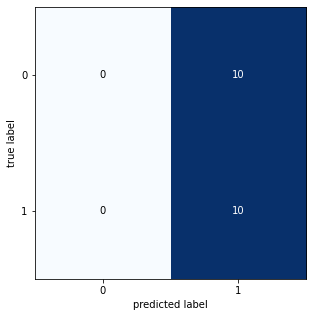

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.3548387096774194
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



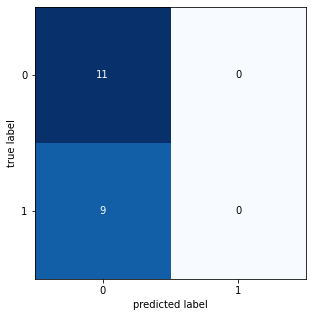

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



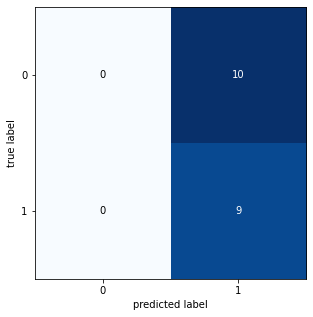

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



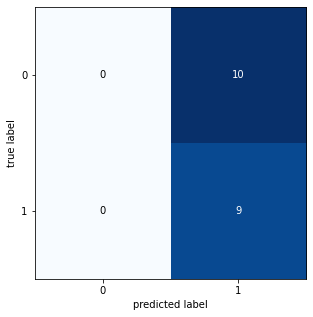

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



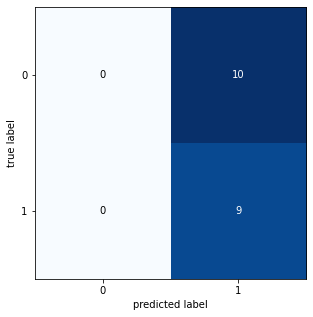

avg accuraccy Breast Cancer =  0.49421052631578943
avg F1_Score Breast Cancer =  0.3304915514592934
max accuraccy Breast Cancer =  0.55
max F1_Score Breast Cancer =  0.3548387096774194
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  39.055681554998955
gene : [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

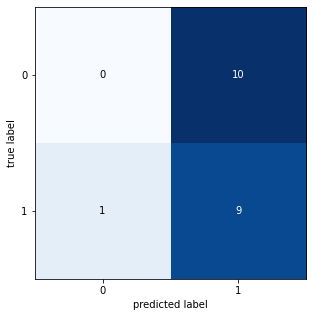

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


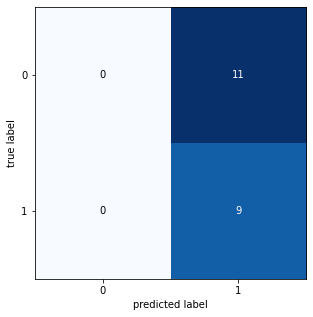

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



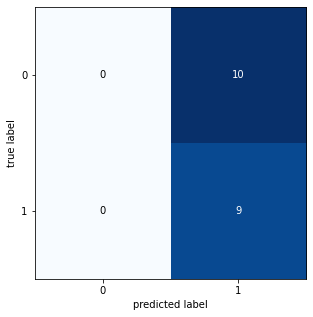

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



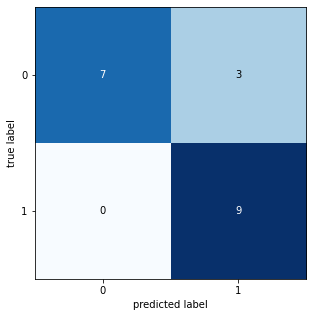

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



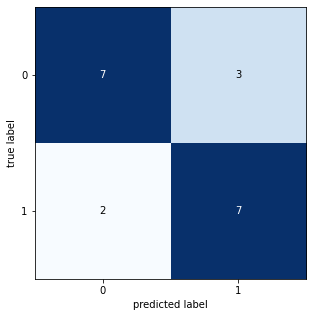

avg accuraccy Breast Cancer =  0.5905263157894737
avg F1_Score Breast Cancer =  0.5038592932635849
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  39.26359980400048
gene : [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

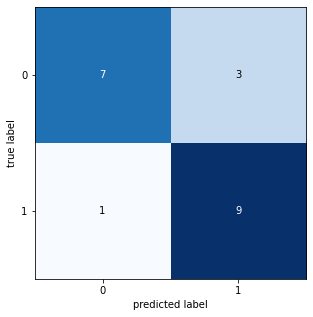

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


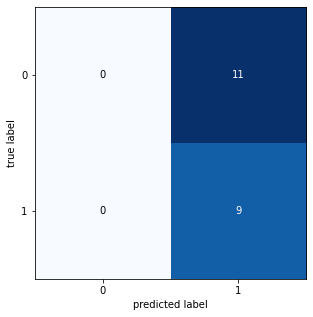

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



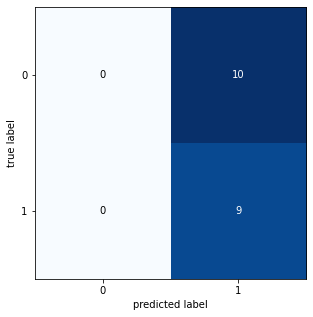

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



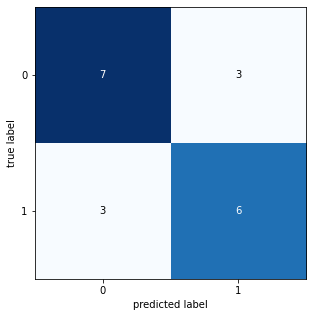

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



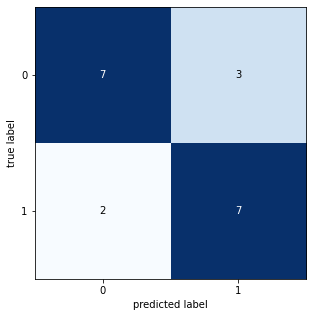

avg accuraccy Breast Cancer =  0.6289473684210527
avg F1_Score Breast Cancer =  0.5699857271182134
max accuraccy Breast Cancer =  0.8
max F1_Score Breast Cancer =  0.797979797979798
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  41.18345074999888
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

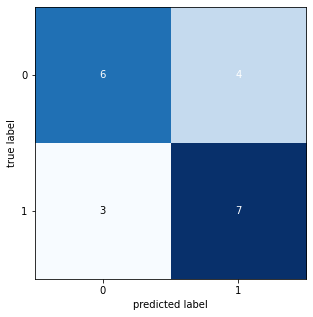

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.3103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


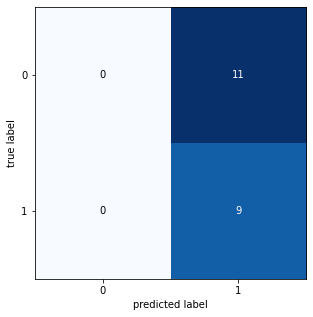

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



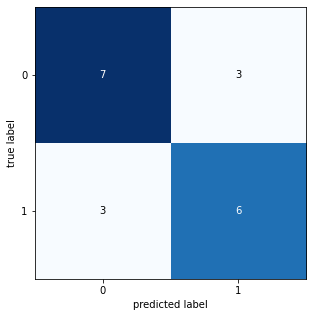

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



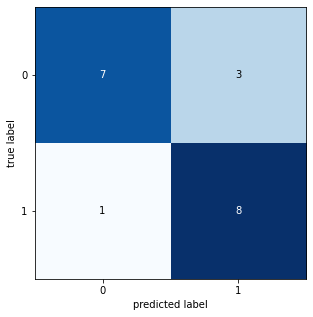

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



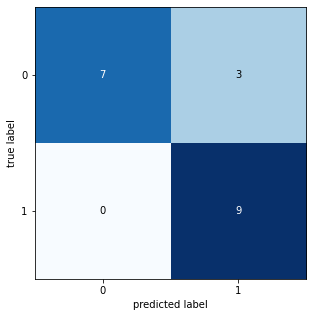

avg accuraccy Breast Cancer =  0.6831578947368421
avg F1_Score Breast Cancer =  0.6544051982559509
max accuraccy Breast Cancer =  0.8421052631578947
max F1_Score Breast Cancer =  0.8403361344537814
min accuraccy Breast Cancer =  0.45
min F1_Score Breast Cancer =  0.3103448275862069
Running Time:  45.800928108001244
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test : [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


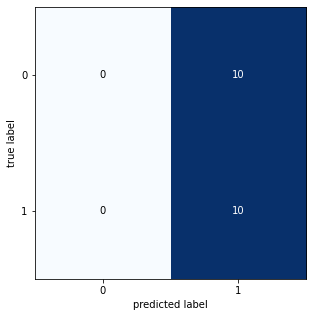

Train : [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test : [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



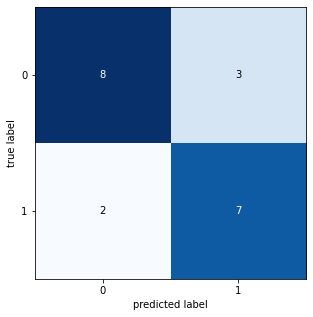

Train : [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test : [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



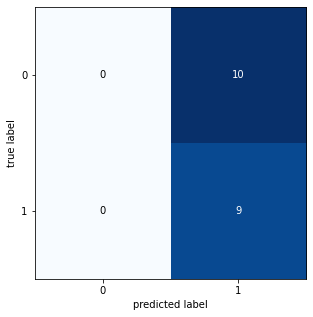

Train : [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test : [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



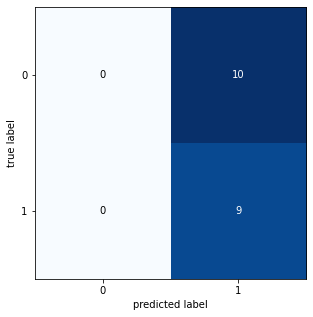

Train : [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test : [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.32142857142857145
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.47      1.00      0.64         9

    accuracy                           0.47        19
   macro avg       0.24      0.50      0.32        19
weighted avg       0.22      0.47      0.30        19



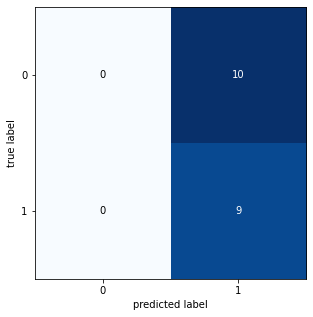

avg accuraccy Breast Cancer =  0.5342105263157895
avg F1_Score Breast Cancer =  0.40939849624060154
max accuraccy Breast Cancer =  0.75
max F1_Score Breast Cancer =  0.7493734335839599
min accuraccy Breast Cancer =  0.47368421052631576
min F1_Score Breast Cancer =  0.32142857142857145
Running Time:  41.074478308000835
gen terbaik : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.7703788883974643  || Akurasi terbaik : 0.7721052631578946  || jumlah fitur : 59

Running Time:  1989.1582645319995


In [15]:
Breast_IG_GA = GeneticAlgorithm(Breast_IG, 4)